# Cross Correlation code for UHF-LI

## Make sure you have all the imports below

In [1]:
import time
import numpy as np
import zhinst.utils
from scipy import signal
import matplotlib.pyplot as plt
import matplotlib as mpl
from datetime import datetime
import os

# Set the name of your device here, and directory to where you would like files to be saved, and signal output parameters

In [2]:
# Choose name of device here
device_id = 'dev2521'

# Configure save directory here
saveDir = r"C:\Users\jsrinivas\Desktop\Data\Cross correlation"

# Checkpoint for saves during run
counter = (1, 10,100,1000,5000,10000)

# Run parameters
scope_length = 2**18
sample_rate = 0
sigouts_amplitude = 1e-3 
sigouts_range = 0.075
repeats = 100000
hann_scaling = 1.5

# Run below cell to initialize connection to device - make sure data server is running

In [3]:
# Initialize connection to device
apilevel = 6
required_devtype = r'UHF|MF'  # Regular expression of supported instruments.
required_options = {}  # No special options required.
required_err_msg = "This example is only compatible with UHF and MF Instruments: " + \
                   "The HF2 Data Server does not support API Levels > 1, which " + \
                   "is required to use the extended scope data structure. " + \
                   "For HF2, see the example zhinst.examples.hf2.example_scope."
(daq, device, props) = zhinst.utils.create_api_session(device_id, apilevel,
                                                       required_devtype=required_devtype,
                                                       required_options=required_options,
                                                       required_err_msg=required_err_msg)

# Configure device
zhinst.utils.api_server_version_check(daq) # Check API versions
daq.setDebugLevel(3) # Enable the API's log.
zhinst.utils.disable_everything(daq, device) # Reset all config/parameters of device

Discovered device `dev2521`: UHFLI with options MF, PID, MOD, AWG, DIG, BOX, CNT.
Creating an API session for device `dev2521` on `127.0.0.1`, `8004` with apilevel `6`.


C:\Users\jsrinivas\AppData\Local\Programs\Python\Python37\lib\site-packages\zhinst\utils.py:168: UserWarning: There is a mismatch between the versions of the API and Data Server. The API reports version `20.01' (revision: 200101211) whilst the Data Server has version `20.03' (revision 200301386). See the ``Compatibility'' Section in the LabOne Programming Manual for more information.
  warnings.warn(message)


[['/dev2521/aucarts/*/enable', 0],
 ['/dev2521/aupolars/*/enable', 0],
 ['/dev2521/awgs/*/enable', 0],
 ['/dev2521/boxcars/*/enable', 0],
 ['/dev2521/cnts/*/enable', 0],
 ['/dev2521/dios/*/drive', 0],
 ['/dev2521/demods/*/enable', 0],
 ['/dev2521/demods/*/trigger', 0],
 ['/dev2521/demods/*/sinc', 0],
 ['/dev2521/demods/*/oscselect', 0],
 ['/dev2521/demods/*/harmonic', 1],
 ['/dev2521/demods/*/phaseshift', 0],
 ['/dev2521/extrefs/*/enable', 0],
 ['/dev2521/inputpwas/*/enable', 0],
 ['/dev2521/mods/*/enable', 0],
 ['/dev2521/outputpwas/*/enable', 0],
 ['/dev2521/pids/*/enable', 0],
 ['/dev2521/sigins/*/ac', 0],
 ['/dev2521/sigins/*/imp50', 0],
 ['/dev2521/sigins/*/diff', 0],
 ['/dev2521/sigouts/*/on', 0],
 ['/dev2521/sigouts/*/enables/*', 0],
 ['/dev2521/sigouts/*/offset', 0.0],
 ['/dev2521/sigouts/*/imp50', 0],
 ['/dev2521/scopes/*/enable', 0],
 ['/dev2521/scopes/*/segments/enable', 0],
 ['/dev2521/scopes/*/stream/enables/*', 0],
 ['/dev2521/triggers/out/*/drive', 0]]

# Creates today's date/time and initializes a folder for saving data/figures

In [4]:
# Create and initialize run directory for saves

today = datetime.now().strftime('%Y-%m-%d')
if not os.path.exists(r"%s\\" % saveDir + today):
    os.mkdir(r"%s\\" % saveDir + today)
    
dirName = r'%s\%s' % (saveDir, today)
idx = 1 + len(os.listdir(dirName))
newDir = '%s\Run %d' % (dirName,idx)
os.mkdir(newDir)
print("Directory " , newDir ,  " Created ")

Directory  C:\Users\jsrinivas\Desktop\Data\Cross correlation\2020-04-28\Run 1  Created 


## Sets parameters for UHF-LI - change any settings here if you would like so

In [5]:
# Configure parameters for the run

exp_setting = [
    # The output signal for 1.
    ['/%s/sigouts/0/on'             % (device), 1],
    ['/%s/sigouts/0/range'          % (device), sigouts_range],
    ['/%s/sigouts/0/amplitudes/%d'  % (device, 0), sigouts_amplitude],
    ['/%s/sigouts/0/enables/%d'     % (device, 0), 1],
    ['/%s/sigouts/0/imp50'          % (device), 0],
    ['/%s/sigins/0/imp50'           % (device), 1],
    ['/%s/sigins/0/ac'              % (device), 0],

    # The output signal for 2
    ['/%s/sigouts/1/on'             % (device), 1],
    ['/%s/sigouts/1/range'          % (device), sigouts_range],
    ['/%s/sigouts/1/amplitudes/%d'  % (device, 0), sigouts_amplitude],
    ['/%s/sigouts/1/amplitudes/%d'  % (device, 2), sigouts_amplitude],
    ['/%s/sigouts/1/enables/%d'     % (device, 0), 1],
    ['/%s/sigouts/1/enables/%d'     % (device, 2), 0],
    ['/%s/sigouts/1/imp50'          % (device), 1],
    ['/%s/sigins/1/imp50'           % (device), 1],
    ['/%s/sigins/1/ac'              % (device), 0],

    # Setting Demod oscillators
    ['/%s/demods/%d/oscselect'      % (device, 1), 1],
    ['/%s/demods/%d/oscselect'      % (device, 2), 2],
    ['/%s/oscs/%d/freq'             % (device, 0), 133.97e6], # Set oscillator 1 to 100,000,000 Hz
    ['/%s/oscs/%d/freq'             % (device, 1), 400e6], # Set oscillator 2 to 400,000,000 Hz
    ['/%s/oscs/%d/freq'             % (device, 2), 100e6], # Set oscillator 3 to 100,000,000 Hz

    # We will use autorange to adjust the sigins range.
    ['/%s/sigins/0/range'          % (device), 10e-3],
    ['/%s/sigins/1/range'          % (device), 10e-3]]


## daq handle parses settings values to your UHF-LI

In [6]:
# Set the parameters

daq.set(exp_setting)


#Get clockbase
clockbase = daq.getInt('/{}/clockbase'.format(device_id))

## Creates a text file with all the settings of the UHFLI, additionally any additional user input which you will be prompted when running below cell

In [7]:
# User prompt for extra details to be stored in text file
details = input('Input extra details to be stored in textfile :: ')

## Save all variables and settings to rundetails.txt
exp_setting.extend([
                  ['Number of repeats/correlations set', repeats],
                  ['Device ID', device_id],
                  ['hann_scaling', hann_scaling],
                  ['counter', str(counter)],
                  ['scope_length', scope_length],
                  ['sample_rate', sample_rate],
                  ['Extra Details by user input',  details]])

with open(f'{newDir}\\rundetails.txt', 'w') as f:
    for item in exp_setting:
        f.write("%s\n\n" % item)

Input extra details to be stored in textfile :: 3x 20 dB attenuation, 10k averages


## Initializes the scope module to be ready for reading signals from two channels

In [8]:
####################################################################################################################
# Configure the scope and obtain data with triggering disabled, correlation performed here (main)
####################################################################################################################

# 'length' : the length of each segment
daq.setInt('/%s/scopes/0/length' % device, scope_length)

# Value 3 enables both channel inputs for the scope
daq.setInt('/%s/scopes/0/channel' % device, 3)

# Select inputs for each scope channel: SI1 for scope channel 1, SI2 for scope channel 2
daq.setInt('/%s/scopes/0/channels/%d/inputselect' % (device, 0), 0)
daq.setInt('/%s/scopes/0/channels/%d/inputselect' % (device, 1), 1)

# 'time' : timescale of the wave, sets the sampling rate to clockbase/2**time.
#   0 - sets the sampling rate to 1.8 GHz
#   1 - sets the sampling rate to 900 MHz
#   ...
#   16 - sets the samptling rate to 27.5 kHz

daq.setInt('/%s/scopes/0/time' % device, sample_rate)

# Set 0 for continous recording of data
daq.setInt('/%s/scopes/0/single' % device, 0)

daq.sync()

# Now initialize and configure the Scope Module.
scopeModule = daq.scopeModule()

# Scope data processing mode: 1 for moving average, scope recording assembled, scaling applied, averaged (if enabled)
scopeModule.set('mode', 1)

#   Set to 1 for no averaging
scopeModule.set('averager/weight', 1)

# 'historylength' : The number of scope records to keep in the Scope Module's memory, when more records
#   arrive in the Module from the device the oldest records are overwritten.
scopeModule.set('historylength', 10)

# Subscribe to the scope's data in the module.
wave_nodepath = '/{}/scopes/0/wave'.format(device)
scopeModule.subscribe(wave_nodepath)

daq.sync()

# Set the Scope Module's mode to return time domain data.
scopeModule.set('mode', 1)

stop = float(1.8e9/(2**sample_rate))/2.0
step = 1/(scope_length/float(1.8e9/(2**sample_rate)))
f = np.arange(0,stop,step)

## Run below cell to begin acquiring data, perform cross-correlation for the n repeats specified, and save data

Correlation number : 1
saving in: 1 , %s\Run %d\%d correlation plot.png


C:\Users\jsrinivas\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:120: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
C:\Users\jsrinivas\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Correlation number : 2
Correlation number : 3
Correlation number : 4
Correlation number : 5
Correlation number : 6
Correlation number : 7
Correlation number : 8
Correlation number : 9
Correlation number : 10
saving in: 10 , %s\Run %d\%d correlation plot.png


C:\Users\jsrinivas\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:120: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
C:\Users\jsrinivas\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Correlation number : 11
Correlation number : 12
Correlation number : 13
Correlation number : 14
Correlation number : 15
Correlation number : 16
Correlation number : 17
Correlation number : 18
Correlation number : 19
Correlation number : 20
Correlation number : 21
Correlation number : 22
Correlation number : 23
Correlation number : 24
Correlation number : 25
Correlation number : 26
Correlation number : 27
Correlation number : 28
Correlation number : 29
Correlation number : 30
Correlation number : 31
Correlation number : 32
Correlation number : 33
Correlation number : 34
Correlation number : 35
Correlation number : 36
Correlation number : 37
Correlation number : 38
Correlation number : 39
Correlation number : 40
Correlation number : 41
Correlation number : 42
Correlation number : 43
Correlation number : 44
Correlation number : 45
Correlation number : 46
Correlation number : 47
Correlation number : 48
Correlation number : 49
Correlation number : 50
saving in: 50 , %s\Run %d\%d correlation

C:\Users\jsrinivas\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:120: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
C:\Users\jsrinivas\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Correlation number : 51
Correlation number : 52
Correlation number : 53
Correlation number : 54
Correlation number : 55
Correlation number : 56
Correlation number : 57
Correlation number : 58
Correlation number : 59
Correlation number : 60
Correlation number : 61
Correlation number : 62
Correlation number : 63
Correlation number : 64
Correlation number : 65
Correlation number : 66
Correlation number : 67
Correlation number : 68
Correlation number : 69
Correlation number : 70
Correlation number : 71
Correlation number : 72
Correlation number : 73
Correlation number : 74
Correlation number : 75
Correlation number : 76
Correlation number : 77
Correlation number : 78
Correlation number : 79
Correlation number : 80
Correlation number : 81
Correlation number : 82
Correlation number : 83
Correlation number : 84
Correlation number : 85
Correlation number : 86
Correlation number : 87
Correlation number : 88
Correlation number : 89
Correlation number : 90
Correlation number : 91
Correlation numb

C:\Users\jsrinivas\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:120: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
C:\Users\jsrinivas\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Correlation number : 101
Correlation number : 102
Correlation number : 103
Correlation number : 104
Correlation number : 105
Correlation number : 106
Correlation number : 107
Correlation number : 108
Correlation number : 109
Correlation number : 110
Correlation number : 111
Correlation number : 112
Correlation number : 113
Correlation number : 114
Correlation number : 115
Correlation number : 116
Correlation number : 117
Correlation number : 118
Correlation number : 119
Correlation number : 120
Correlation number : 121
Correlation number : 122
Correlation number : 123
Correlation number : 124
Correlation number : 125
Correlation number : 126
Correlation number : 127
Correlation number : 128
Correlation number : 129
Correlation number : 130
Correlation number : 131
Correlation number : 132
Correlation number : 133
Correlation number : 134
Correlation number : 135
Correlation number : 136
Correlation number : 137
Correlation number : 138
Correlation number : 139
Correlation number : 140


Correlation number : 429
Correlation number : 430
Correlation number : 431
Correlation number : 432
Correlation number : 433
Correlation number : 434
Correlation number : 435
Correlation number : 436
Correlation number : 437
Correlation number : 438
Correlation number : 439
Correlation number : 440
Correlation number : 441
Correlation number : 442
Correlation number : 443
Correlation number : 444
Correlation number : 445
Correlation number : 446
Correlation number : 447
Correlation number : 448
Correlation number : 449
Correlation number : 450
Correlation number : 451
Correlation number : 452
Correlation number : 453
Correlation number : 454
Correlation number : 455
Correlation number : 456
Correlation number : 457
Correlation number : 458
Correlation number : 459
Correlation number : 460
Correlation number : 461
Correlation number : 462
Correlation number : 463
Correlation number : 464
Correlation number : 465
Correlation number : 466
Correlation number : 467
Correlation number : 468


C:\Users\jsrinivas\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:120: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
C:\Users\jsrinivas\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Correlation number : 501
Correlation number : 502
Correlation number : 503
Correlation number : 504
Correlation number : 505
Correlation number : 506
Correlation number : 507
Correlation number : 508
Correlation number : 509
Correlation number : 510
Correlation number : 511
Correlation number : 512
Correlation number : 513
Correlation number : 514
Correlation number : 515
Correlation number : 516
Correlation number : 517
Correlation number : 518
Correlation number : 519
Correlation number : 520
Correlation number : 521
Correlation number : 522
Correlation number : 523
Correlation number : 524
Correlation number : 525
Correlation number : 526
Correlation number : 527
Correlation number : 528
Correlation number : 529
Correlation number : 530
Correlation number : 531
Correlation number : 532
Correlation number : 533
Correlation number : 534
Correlation number : 535
Correlation number : 536
Correlation number : 537
Correlation number : 538
Correlation number : 539
Correlation number : 540


C:\Users\jsrinivas\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:120: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
C:\Users\jsrinivas\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Correlation number : 1001
Correlation number : 1002
Correlation number : 1003
Correlation number : 1004
Correlation number : 1005
Correlation number : 1006
Correlation number : 1007
Correlation number : 1008
Correlation number : 1009
Correlation number : 1010
Correlation number : 1011
Correlation number : 1012
Correlation number : 1013
Correlation number : 1014
Correlation number : 1015
Correlation number : 1016
Correlation number : 1017
Correlation number : 1018
Correlation number : 1019
Correlation number : 1020
Correlation number : 1021
Correlation number : 1022
Correlation number : 1023
Correlation number : 1024
Correlation number : 1025
Correlation number : 1026
Correlation number : 1027
Correlation number : 1028
Correlation number : 1029
Correlation number : 1030
Correlation number : 1031
Correlation number : 1032
Correlation number : 1033
Correlation number : 1034
Correlation number : 1035
Correlation number : 1036
Correlation number : 1037
Correlation number : 1038
Correlation 

Correlation number : 1317
Correlation number : 1318
Correlation number : 1319
Correlation number : 1320
Correlation number : 1321
Correlation number : 1322
Correlation number : 1323
Correlation number : 1324
Correlation number : 1325
Correlation number : 1326
Correlation number : 1327
Correlation number : 1328
Correlation number : 1329
Correlation number : 1330
Correlation number : 1331
Correlation number : 1332
Correlation number : 1333
Correlation number : 1334
Correlation number : 1335
Correlation number : 1336
Correlation number : 1337
Correlation number : 1338
Correlation number : 1339
Correlation number : 1340
Correlation number : 1341
Correlation number : 1342
Correlation number : 1343
Correlation number : 1344
Correlation number : 1345
Correlation number : 1346
Correlation number : 1347
Correlation number : 1348
Correlation number : 1349
Correlation number : 1350
Correlation number : 1351
Correlation number : 1352
Correlation number : 1353
Correlation number : 1354
Correlation 

Correlation number : 1633
Correlation number : 1634
Correlation number : 1635
Correlation number : 1636
Correlation number : 1637
Correlation number : 1638
Correlation number : 1639
Correlation number : 1640
Correlation number : 1641
Correlation number : 1642
Correlation number : 1643
Correlation number : 1644
Correlation number : 1645
Correlation number : 1646
Correlation number : 1647
Correlation number : 1648
Correlation number : 1649
Correlation number : 1650
Correlation number : 1651
Correlation number : 1652
Correlation number : 1653
Correlation number : 1654
Correlation number : 1655
Correlation number : 1656
Correlation number : 1657
Correlation number : 1658
Correlation number : 1659
Correlation number : 1660
Correlation number : 1661
Correlation number : 1662
Correlation number : 1663
Correlation number : 1664
Correlation number : 1665
Correlation number : 1666
Correlation number : 1667
Correlation number : 1668
Correlation number : 1669
Correlation number : 1670
Correlation 

Correlation number : 1949
Correlation number : 1950
Correlation number : 1951
Correlation number : 1952
Correlation number : 1953
Correlation number : 1954
Correlation number : 1955
Correlation number : 1956
Correlation number : 1957
Correlation number : 1958
Correlation number : 1959
Correlation number : 1960
Correlation number : 1961
Correlation number : 1962
Correlation number : 1963
Correlation number : 1964
Correlation number : 1965
Correlation number : 1966
Correlation number : 1967
Correlation number : 1968
Correlation number : 1969
Correlation number : 1970
Correlation number : 1971
Correlation number : 1972
Correlation number : 1973
Correlation number : 1974
Correlation number : 1975
Correlation number : 1976
Correlation number : 1977
Correlation number : 1978
Correlation number : 1979
Correlation number : 1980
Correlation number : 1981
Correlation number : 1982
Correlation number : 1983
Correlation number : 1984
Correlation number : 1985
Correlation number : 1986
Correlation 

C:\Users\jsrinivas\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:120: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
C:\Users\jsrinivas\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Correlation number : 2001
Correlation number : 2002
Correlation number : 2003
Correlation number : 2004
Correlation number : 2005
Correlation number : 2006
Correlation number : 2007
Correlation number : 2008
Correlation number : 2009
Correlation number : 2010
Correlation number : 2011
Correlation number : 2012
Correlation number : 2013
Correlation number : 2014
Correlation number : 2015
Correlation number : 2016
Correlation number : 2017
Correlation number : 2018
Correlation number : 2019
Correlation number : 2020
Correlation number : 2021
Correlation number : 2022
Correlation number : 2023
Correlation number : 2024
Correlation number : 2025
Correlation number : 2026
Correlation number : 2027
Correlation number : 2028
Correlation number : 2029
Correlation number : 2030
Correlation number : 2031
Correlation number : 2032
Correlation number : 2033
Correlation number : 2034
Correlation number : 2035
Correlation number : 2036
Correlation number : 2037
Correlation number : 2038
Correlation 

Correlation number : 2317
Correlation number : 2318
Correlation number : 2319
Correlation number : 2320
Correlation number : 2321
Correlation number : 2322
Correlation number : 2323
Correlation number : 2324
Correlation number : 2325
Correlation number : 2326
Correlation number : 2327
Correlation number : 2328
Correlation number : 2329
Correlation number : 2330
Correlation number : 2331
Correlation number : 2332
Correlation number : 2333
Correlation number : 2334
Correlation number : 2335
Correlation number : 2336
Correlation number : 2337
Correlation number : 2338
Correlation number : 2339
Correlation number : 2340
Correlation number : 2341
Correlation number : 2342
Correlation number : 2343
Correlation number : 2344
Correlation number : 2345
Correlation number : 2346
Correlation number : 2347
Correlation number : 2348
Correlation number : 2349
Correlation number : 2350
Correlation number : 2351
Correlation number : 2352
Correlation number : 2353
Correlation number : 2354
Correlation 

Correlation number : 2633
Correlation number : 2634
Correlation number : 2635
Correlation number : 2636
Correlation number : 2637
Correlation number : 2638
Correlation number : 2639
Correlation number : 2640
Correlation number : 2641
Correlation number : 2642
Correlation number : 2643
Correlation number : 2644
Correlation number : 2645
Correlation number : 2646
Correlation number : 2647
Correlation number : 2648
Correlation number : 2649
Correlation number : 2650
Correlation number : 2651
Correlation number : 2652
Correlation number : 2653
Correlation number : 2654
Correlation number : 2655
Correlation number : 2656
Correlation number : 2657
Correlation number : 2658
Correlation number : 2659
Correlation number : 2660
Correlation number : 2661
Correlation number : 2662
Correlation number : 2663
Correlation number : 2664
Correlation number : 2665
Correlation number : 2666
Correlation number : 2667
Correlation number : 2668
Correlation number : 2669
Correlation number : 2670
Correlation 

Correlation number : 2949
Correlation number : 2950
Correlation number : 2951
Correlation number : 2952
Correlation number : 2953
Correlation number : 2954
Correlation number : 2955
Correlation number : 2956
Correlation number : 2957
Correlation number : 2958
Correlation number : 2959
Correlation number : 2960
Correlation number : 2961
Correlation number : 2962
Correlation number : 2963
Correlation number : 2964
Correlation number : 2965
Correlation number : 2966
Correlation number : 2967
Correlation number : 2968
Correlation number : 2969
Correlation number : 2970
Correlation number : 2971
Correlation number : 2972
Correlation number : 2973
Correlation number : 2974
Correlation number : 2975
Correlation number : 2976
Correlation number : 2977
Correlation number : 2978
Correlation number : 2979
Correlation number : 2980
Correlation number : 2981
Correlation number : 2982
Correlation number : 2983
Correlation number : 2984
Correlation number : 2985
Correlation number : 2986
Correlation 

Correlation number : 3265
Correlation number : 3266
Correlation number : 3267
Correlation number : 3268
Correlation number : 3269
Correlation number : 3270
Correlation number : 3271
Correlation number : 3272
Correlation number : 3273
Correlation number : 3274
Correlation number : 3275
Correlation number : 3276
Correlation number : 3277
Correlation number : 3278
Correlation number : 3279
Correlation number : 3280
Correlation number : 3281
Correlation number : 3282
Correlation number : 3283
Correlation number : 3284
Correlation number : 3285
Correlation number : 3286
Correlation number : 3287
Correlation number : 3288
Correlation number : 3289
Correlation number : 3290
Correlation number : 3291
Correlation number : 3292
Correlation number : 3293
Correlation number : 3294
Correlation number : 3295
Correlation number : 3296
Correlation number : 3297
Correlation number : 3298
Correlation number : 3299
Correlation number : 3300
Correlation number : 3301
Correlation number : 3302
Correlation 

Correlation number : 3581
Correlation number : 3582
Correlation number : 3583
Correlation number : 3584
Correlation number : 3585
Correlation number : 3586
Correlation number : 3587
Correlation number : 3588
Correlation number : 3589
Correlation number : 3590
Correlation number : 3591
Correlation number : 3592
Correlation number : 3593
Correlation number : 3594
Correlation number : 3595
Correlation number : 3596
Correlation number : 3597
Correlation number : 3598
Correlation number : 3599
Correlation number : 3600
Correlation number : 3601
Correlation number : 3602
Correlation number : 3603
Correlation number : 3604
Correlation number : 3605
Correlation number : 3606
Correlation number : 3607
Correlation number : 3608
Correlation number : 3609
Correlation number : 3610
Correlation number : 3611
Correlation number : 3612
Correlation number : 3613
Correlation number : 3614
Correlation number : 3615
Correlation number : 3616
Correlation number : 3617
Correlation number : 3618
Correlation 

Correlation number : 3897
Correlation number : 3898
Correlation number : 3899
Correlation number : 3900
Correlation number : 3901
Correlation number : 3902
Correlation number : 3903
Correlation number : 3904
Correlation number : 3905
Correlation number : 3906
Correlation number : 3907
Correlation number : 3908
Correlation number : 3909
Correlation number : 3910
Correlation number : 3911
Correlation number : 3912
Correlation number : 3913
Correlation number : 3914
Correlation number : 3915
Correlation number : 3916
Correlation number : 3917
Correlation number : 3918
Correlation number : 3919
Correlation number : 3920
Correlation number : 3921
Correlation number : 3922
Correlation number : 3923
Correlation number : 3924
Correlation number : 3925
Correlation number : 3926
Correlation number : 3927
Correlation number : 3928
Correlation number : 3929
Correlation number : 3930
Correlation number : 3931
Correlation number : 3932
Correlation number : 3933
Correlation number : 3934
Correlation 

C:\Users\jsrinivas\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:120: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
C:\Users\jsrinivas\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Correlation number : 4001
Correlation number : 4002
Correlation number : 4003
Correlation number : 4004
Correlation number : 4005
Correlation number : 4006
Correlation number : 4007
Correlation number : 4008
Correlation number : 4009
Correlation number : 4010
Correlation number : 4011
Correlation number : 4012
Correlation number : 4013
Correlation number : 4014
Correlation number : 4015
Correlation number : 4016
Correlation number : 4017
Correlation number : 4018
Correlation number : 4019
Correlation number : 4020
Correlation number : 4021
Correlation number : 4022
Correlation number : 4023
Correlation number : 4024
Correlation number : 4025
Correlation number : 4026
Correlation number : 4027
Correlation number : 4028
Correlation number : 4029
Correlation number : 4030
Correlation number : 4031
Correlation number : 4032
Correlation number : 4033
Correlation number : 4034
Correlation number : 4035
Correlation number : 4036
Correlation number : 4037
Correlation number : 4038
Correlation 

Correlation number : 4633
Correlation number : 4634
Correlation number : 4635
Correlation number : 4636
Correlation number : 4637
Correlation number : 4638
Correlation number : 4639
Correlation number : 4640
Correlation number : 4641
Correlation number : 4642
Correlation number : 4643
Correlation number : 4644
Correlation number : 4645
Correlation number : 4646
Correlation number : 4647
Correlation number : 4648
Correlation number : 4649
Correlation number : 4650
Correlation number : 4651
Correlation number : 4652
Correlation number : 4653
Correlation number : 4654
Correlation number : 4655
Correlation number : 4656
Correlation number : 4657
Correlation number : 4658
Correlation number : 4659
Correlation number : 4660
Correlation number : 4661
Correlation number : 4662
Correlation number : 4663
Correlation number : 4664
Correlation number : 4665
Correlation number : 4666
Correlation number : 4667
Correlation number : 4668
Correlation number : 4669
Correlation number : 4670
Correlation 

Correlation number : 4949
Correlation number : 4950
Correlation number : 4951
Correlation number : 4952
Correlation number : 4953
Correlation number : 4954
Correlation number : 4955
Correlation number : 4956
Correlation number : 4957
Correlation number : 4958
Correlation number : 4959
Correlation number : 4960
Correlation number : 4961
Correlation number : 4962
Correlation number : 4963
Correlation number : 4964
Correlation number : 4965
Correlation number : 4966
Correlation number : 4967
Correlation number : 4968
Correlation number : 4969
Correlation number : 4970
Correlation number : 4971
Correlation number : 4972
Correlation number : 4973
Correlation number : 4974
Correlation number : 4975
Correlation number : 4976
Correlation number : 4977
Correlation number : 4978
Correlation number : 4979
Correlation number : 4980
Correlation number : 4981
Correlation number : 4982
Correlation number : 4983
Correlation number : 4984
Correlation number : 4985
Correlation number : 4986
Correlation 

C:\Users\jsrinivas\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:120: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
C:\Users\jsrinivas\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Correlation number : 5001
Correlation number : 5002
Correlation number : 5003
Correlation number : 5004
Correlation number : 5005
Correlation number : 5006
Correlation number : 5007
Correlation number : 5008
Correlation number : 5009
Correlation number : 5010
Correlation number : 5011
Correlation number : 5012
Correlation number : 5013
Correlation number : 5014
Correlation number : 5015
Correlation number : 5016
Correlation number : 5017
Correlation number : 5018
Correlation number : 5019
Correlation number : 5020
Correlation number : 5021
Correlation number : 5022
Correlation number : 5023
Correlation number : 5024
Correlation number : 5025
Correlation number : 5026
Correlation number : 5027
Correlation number : 5028
Correlation number : 5029
Correlation number : 5030
Correlation number : 5031
Correlation number : 5032
Correlation number : 5033
Correlation number : 5034
Correlation number : 5035
Correlation number : 5036
Correlation number : 5037
Correlation number : 5038
Correlation 

Correlation number : 5318
Correlation number : 5319
Correlation number : 5320
Correlation number : 5321
Correlation number : 5322
Correlation number : 5323
Correlation number : 5324
Correlation number : 5325
Correlation number : 5326
Correlation number : 5327
Correlation number : 5328
Correlation number : 5329
Correlation number : 5330
Correlation number : 5331
Correlation number : 5332
Correlation number : 5333
Correlation number : 5334
Correlation number : 5335
Correlation number : 5336
Correlation number : 5337
Correlation number : 5338
Correlation number : 5339
Correlation number : 5340
Correlation number : 5341
Correlation number : 5342
Correlation number : 5343
Correlation number : 5344
Correlation number : 5345
Correlation number : 5346
Correlation number : 5347
Correlation number : 5348
Correlation number : 5349
Correlation number : 5350
Correlation number : 5351
Correlation number : 5352
Correlation number : 5353
Correlation number : 5354
Correlation number : 5355
Correlation 

Correlation number : 5634
Correlation number : 5635
Correlation number : 5636
Correlation number : 5637
Correlation number : 5638
Correlation number : 5639
Correlation number : 5640
Correlation number : 5641
Correlation number : 5642
Correlation number : 5643
Correlation number : 5644
Correlation number : 5645
Correlation number : 5646
Correlation number : 5647
Correlation number : 5648
Correlation number : 5649
Correlation number : 5650
Correlation number : 5651
Correlation number : 5652
Correlation number : 5653
Correlation number : 5654
Correlation number : 5655
Correlation number : 5656
Correlation number : 5657
Correlation number : 5658
Correlation number : 5659
Correlation number : 5660
Correlation number : 5661
Correlation number : 5662
Correlation number : 5663
Correlation number : 5664
Correlation number : 5665
Correlation number : 5666
Correlation number : 5667
Correlation number : 5668
Correlation number : 5669
Correlation number : 5670
Correlation number : 5671
Correlation 

Correlation number : 5950
Correlation number : 5951
Correlation number : 5952
Correlation number : 5953
Correlation number : 5954
Correlation number : 5955
Correlation number : 5956
Correlation number : 5957
Correlation number : 5958
Correlation number : 5959
Correlation number : 5960
Correlation number : 5961
Correlation number : 5962
Correlation number : 5963
Correlation number : 5964
Correlation number : 5965
Correlation number : 5966
Correlation number : 5967
Correlation number : 5968
Correlation number : 5969
Correlation number : 5970
Correlation number : 5971
Correlation number : 5972
Correlation number : 5973
Correlation number : 5974
Correlation number : 5975
Correlation number : 5976
Correlation number : 5977
Correlation number : 5978
Correlation number : 5979
Correlation number : 5980
Correlation number : 5981
Correlation number : 5982
Correlation number : 5983
Correlation number : 5984
Correlation number : 5985
Correlation number : 5986
Correlation number : 5987
Correlation 

Correlation number : 6266
Correlation number : 6267
Correlation number : 6268
Correlation number : 6269
Correlation number : 6270
Correlation number : 6271
Correlation number : 6272
Correlation number : 6273
Correlation number : 6274
Correlation number : 6275
Correlation number : 6276
Correlation number : 6277
Correlation number : 6278
Correlation number : 6279
Correlation number : 6280
Correlation number : 6281
Correlation number : 6282
Correlation number : 6283
Correlation number : 6284
Correlation number : 6285
Correlation number : 6286
Correlation number : 6287
Correlation number : 6288
Correlation number : 6289
Correlation number : 6290
Correlation number : 6291
Correlation number : 6292
Correlation number : 6293
Correlation number : 6294
Correlation number : 6295
Correlation number : 6296
Correlation number : 6297
Correlation number : 6298
Correlation number : 6299
Correlation number : 6300
Correlation number : 6301
Correlation number : 6302
Correlation number : 6303
Correlation 

Correlation number : 6582
Correlation number : 6583
Correlation number : 6584
Correlation number : 6585
Correlation number : 6586
Correlation number : 6587
Correlation number : 6588
Correlation number : 6589
Correlation number : 6590
Correlation number : 6591
Correlation number : 6592
Correlation number : 6593
Correlation number : 6594
Correlation number : 6595
Correlation number : 6596
Correlation number : 6597
Correlation number : 6598
Correlation number : 6599
Correlation number : 6600
Correlation number : 6601
Correlation number : 6602
Correlation number : 6603
Correlation number : 6604
Correlation number : 6605
Correlation number : 6606
Correlation number : 6607
Correlation number : 6608
Correlation number : 6609
Correlation number : 6610
Correlation number : 6611
Correlation number : 6612
Correlation number : 6613
Correlation number : 6614
Correlation number : 6615
Correlation number : 6616
Correlation number : 6617
Correlation number : 6618
Correlation number : 6619
Correlation 

Correlation number : 6899
Correlation number : 6900
Correlation number : 6901
Correlation number : 6902
Correlation number : 6903
Correlation number : 6904
Correlation number : 6905
Correlation number : 6906
Correlation number : 6907
Correlation number : 6908
Correlation number : 6909
Correlation number : 6910
Correlation number : 6911
Correlation number : 6912
Correlation number : 6913
Correlation number : 6914
Correlation number : 6915
Correlation number : 6916
Correlation number : 6917
Correlation number : 6918
Correlation number : 6919
Correlation number : 6920
Correlation number : 6921
Correlation number : 6922
Correlation number : 6923
Correlation number : 6924
Correlation number : 6925
Correlation number : 6926
Correlation number : 6927
Correlation number : 6928
Correlation number : 6929
Correlation number : 6930
Correlation number : 6931
Correlation number : 6932
Correlation number : 6933
Correlation number : 6934
Correlation number : 6935
Correlation number : 6936
Correlation 

C:\Users\jsrinivas\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:120: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
C:\Users\jsrinivas\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Correlation number : 7001
Correlation number : 7002
Correlation number : 7003
Correlation number : 7004
Correlation number : 7005
Correlation number : 7006
Correlation number : 7007
Correlation number : 7008
Correlation number : 7009
Correlation number : 7010
Correlation number : 7011
Correlation number : 7012
Correlation number : 7013
Correlation number : 7014
Correlation number : 7015
Correlation number : 7016
Correlation number : 7017
Correlation number : 7018
Correlation number : 7019
Correlation number : 7020
Correlation number : 7021
Correlation number : 7022
Correlation number : 7023
Correlation number : 7024
Correlation number : 7025
Correlation number : 7026
Correlation number : 7027
Correlation number : 7028
Correlation number : 7029
Correlation number : 7030
Correlation number : 7031
Correlation number : 7032
Correlation number : 7033
Correlation number : 7034
Correlation number : 7035
Correlation number : 7036
Correlation number : 7037
Correlation number : 7038
Correlation 

Correlation number : 7317
Correlation number : 7318
Correlation number : 7319
Correlation number : 7320
Correlation number : 7321
Correlation number : 7322
Correlation number : 7323
Correlation number : 7324
Correlation number : 7325
Correlation number : 7326
Correlation number : 7327
Correlation number : 7328
Correlation number : 7329
Correlation number : 7330
Correlation number : 7331
Correlation number : 7332
Correlation number : 7333
Correlation number : 7334
Correlation number : 7335
Correlation number : 7336
Correlation number : 7337
Correlation number : 7338
Correlation number : 7339
Correlation number : 7340
Correlation number : 7341
Correlation number : 7342
Correlation number : 7343
Correlation number : 7344
Correlation number : 7345
Correlation number : 7346
Correlation number : 7347
Correlation number : 7348
Correlation number : 7349
Correlation number : 7350
Correlation number : 7351
Correlation number : 7352
Correlation number : 7353
Correlation number : 7354
Correlation 

Correlation number : 7633
Correlation number : 7634
Correlation number : 7635
Correlation number : 7636
Correlation number : 7637
Correlation number : 7638
Correlation number : 7639
Correlation number : 7640
Correlation number : 7641
Correlation number : 7642
Correlation number : 7643
Correlation number : 7644
Correlation number : 7645
Correlation number : 7646
Correlation number : 7647
Correlation number : 7648
Correlation number : 7649
Correlation number : 7650
Correlation number : 7651
Correlation number : 7652
Correlation number : 7653
Correlation number : 7654
Correlation number : 7655
Correlation number : 7656
Correlation number : 7657
Correlation number : 7658
Correlation number : 7659
Correlation number : 7660
Correlation number : 7661
Correlation number : 7662
Correlation number : 7663
Correlation number : 7664
Correlation number : 7665
Correlation number : 7666
Correlation number : 7667
Correlation number : 7668
Correlation number : 7669
Correlation number : 7670
Correlation 

Correlation number : 7949
Correlation number : 7950
Correlation number : 7951
Correlation number : 7952
Correlation number : 7953
Correlation number : 7954
Correlation number : 7955
Correlation number : 7956
Correlation number : 7957
Correlation number : 7958
Correlation number : 7959
Correlation number : 7960
Correlation number : 7961
Correlation number : 7962
Correlation number : 7963
Correlation number : 7964
Correlation number : 7965
Correlation number : 7966
Correlation number : 7967
Correlation number : 7968
Correlation number : 7969
Correlation number : 7970
Correlation number : 7971
Correlation number : 7972
Correlation number : 7973
Correlation number : 7974
Correlation number : 7975
Correlation number : 7976
Correlation number : 7977
Correlation number : 7978
Correlation number : 7979
Correlation number : 7980
Correlation number : 7981
Correlation number : 7982
Correlation number : 7983
Correlation number : 7984
Correlation number : 7985
Correlation number : 7986
Correlation 

Correlation number : 8265
Correlation number : 8266
Correlation number : 8267
Correlation number : 8268
Correlation number : 8269
Correlation number : 8270
Correlation number : 8271
Correlation number : 8272
Correlation number : 8273
Correlation number : 8274
Correlation number : 8275
Correlation number : 8276
Correlation number : 8277
Correlation number : 8278
Correlation number : 8279
Correlation number : 8280
Correlation number : 8281
Correlation number : 8282
Correlation number : 8283
Correlation number : 8284
Correlation number : 8285
Correlation number : 8286
Correlation number : 8287
Correlation number : 8288
Correlation number : 8289
Correlation number : 8290
Correlation number : 8291
Correlation number : 8292
Correlation number : 8293
Correlation number : 8294
Correlation number : 8295
Correlation number : 8296
Correlation number : 8297
Correlation number : 8298
Correlation number : 8299
Correlation number : 8300
Correlation number : 8301
Correlation number : 8302
Correlation 

Correlation number : 8581
Correlation number : 8582
Correlation number : 8583
Correlation number : 8584
Correlation number : 8585
Correlation number : 8586
Correlation number : 8587
Correlation number : 8588
Correlation number : 8589
Correlation number : 8590
Correlation number : 8591
Correlation number : 8592
Correlation number : 8593
Correlation number : 8594
Correlation number : 8595
Correlation number : 8596
Correlation number : 8597
Correlation number : 8598
Correlation number : 8599
Correlation number : 8600
Correlation number : 8601
Correlation number : 8602
Correlation number : 8603
Correlation number : 8604
Correlation number : 8605
Correlation number : 8606
Correlation number : 8607
Correlation number : 8608
Correlation number : 8609
Correlation number : 8610
Correlation number : 8611
Correlation number : 8612
Correlation number : 8613
Correlation number : 8614
Correlation number : 8615
Correlation number : 8616
Correlation number : 8617
Correlation number : 8618
Correlation 

C:\Users\jsrinivas\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:120: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
C:\Users\jsrinivas\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Correlation number : 9001
Correlation number : 9002
Correlation number : 9003
Correlation number : 9004
Correlation number : 9005
Correlation number : 9006
Correlation number : 9007
Correlation number : 9008
Correlation number : 9009
Correlation number : 9010
Correlation number : 9011
Correlation number : 9012
Correlation number : 9013
Correlation number : 9014
Correlation number : 9015
Correlation number : 9016
Correlation number : 9017
Correlation number : 9018
Correlation number : 9019
Correlation number : 9020
Correlation number : 9021
Correlation number : 9022
Correlation number : 9023
Correlation number : 9024
Correlation number : 9025
Correlation number : 9026
Correlation number : 9027
Correlation number : 9028
Correlation number : 9029
Correlation number : 9030
Correlation number : 9031
Correlation number : 9032
Correlation number : 9033
Correlation number : 9034
Correlation number : 9035
Correlation number : 9036
Correlation number : 9037
Correlation number : 9038
Correlation 

Correlation number : 9317
Correlation number : 9318
Correlation number : 9319
Correlation number : 9320
Correlation number : 9321
Correlation number : 9322
Correlation number : 9323
Correlation number : 9324
Correlation number : 9325
Correlation number : 9326
Correlation number : 9327
Correlation number : 9328
Correlation number : 9329
Correlation number : 9330
Correlation number : 9331
Correlation number : 9332
Correlation number : 9333
Correlation number : 9334
Correlation number : 9335
Correlation number : 9336
Correlation number : 9337
Correlation number : 9338
Correlation number : 9339
Correlation number : 9340
Correlation number : 9341
Correlation number : 9342
Correlation number : 9343
Correlation number : 9344
Correlation number : 9345
Correlation number : 9346
Correlation number : 9347
Correlation number : 9348
Correlation number : 9349
Correlation number : 9350
Correlation number : 9351
Correlation number : 9352
Correlation number : 9353
Correlation number : 9354
Correlation 

Correlation number : 9633
Correlation number : 9634
Correlation number : 9635
Correlation number : 9636
Correlation number : 9637
Correlation number : 9638
Correlation number : 9639
Correlation number : 9640
Correlation number : 9641
Correlation number : 9642
Correlation number : 9643
Correlation number : 9644
Correlation number : 9645
Correlation number : 9646
Correlation number : 9647
Correlation number : 9648
Correlation number : 9649
Correlation number : 9650
Correlation number : 9651
Correlation number : 9652
Correlation number : 9653
Correlation number : 9654
Correlation number : 9655
Correlation number : 9656
Correlation number : 9657
Correlation number : 9658
Correlation number : 9659
Correlation number : 9660
Correlation number : 9661
Correlation number : 9662
Correlation number : 9663
Correlation number : 9664
Correlation number : 9665
Correlation number : 9666
Correlation number : 9667
Correlation number : 9668
Correlation number : 9669
Correlation number : 9670
Correlation 

Correlation number : 9949
Correlation number : 9950
Correlation number : 9951
Correlation number : 9952
Correlation number : 9953
Correlation number : 9954
Correlation number : 9955
Correlation number : 9956
Correlation number : 9957
Correlation number : 9958
Correlation number : 9959
Correlation number : 9960
Correlation number : 9961
Correlation number : 9962
Correlation number : 9963
Correlation number : 9964
Correlation number : 9965
Correlation number : 9966
Correlation number : 9967
Correlation number : 9968
Correlation number : 9969
Correlation number : 9970
Correlation number : 9971
Correlation number : 9972
Correlation number : 9973
Correlation number : 9974
Correlation number : 9975
Correlation number : 9976
Correlation number : 9977
Correlation number : 9978
Correlation number : 9979
Correlation number : 9980
Correlation number : 9981
Correlation number : 9982
Correlation number : 9983
Correlation number : 9984
Correlation number : 9985
Correlation number : 9986
Correlation 

C:\Users\jsrinivas\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:120: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
C:\Users\jsrinivas\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Correlation number : 10001
Correlation number : 10002
Correlation number : 10003
Correlation number : 10004
Correlation number : 10005
Correlation number : 10006
Correlation number : 10007
Correlation number : 10008
Correlation number : 10009
Correlation number : 10010
Correlation number : 10011
Correlation number : 10012
Correlation number : 10013
Correlation number : 10014
Correlation number : 10015
Correlation number : 10016
Correlation number : 10017
Correlation number : 10018
Correlation number : 10019
Correlation number : 10020
Correlation number : 10021
Correlation number : 10022
Correlation number : 10023
Correlation number : 10024
Correlation number : 10025
Correlation number : 10026
Correlation number : 10027
Correlation number : 10028
Correlation number : 10029
Correlation number : 10030
Correlation number : 10031
Correlation number : 10032
Correlation number : 10033
Correlation number : 10034
Correlation number : 10035
Correlation number : 10036
Correlation number : 10037
C

Correlation number : 10305
Correlation number : 10306
Correlation number : 10307
Correlation number : 10308
Correlation number : 10309
Correlation number : 10310
Correlation number : 10311
Correlation number : 10312
Correlation number : 10313
Correlation number : 10314
Correlation number : 10315
Correlation number : 10316
Correlation number : 10317
Correlation number : 10318
Correlation number : 10319
Correlation number : 10320
Correlation number : 10321
Correlation number : 10322
Correlation number : 10323
Correlation number : 10324
Correlation number : 10325
Correlation number : 10326
Correlation number : 10327
Correlation number : 10328
Correlation number : 10329
Correlation number : 10330
Correlation number : 10331
Correlation number : 10332
Correlation number : 10333
Correlation number : 10334
Correlation number : 10335
Correlation number : 10336
Correlation number : 10337
Correlation number : 10338
Correlation number : 10339
Correlation number : 10340
Correlation number : 10341
C

Correlation number : 10609
Correlation number : 10610
Correlation number : 10611
Correlation number : 10612
Correlation number : 10613
Correlation number : 10614
Correlation number : 10615
Correlation number : 10616
Correlation number : 10617
Correlation number : 10618
Correlation number : 10619
Correlation number : 10620
Correlation number : 10621
Correlation number : 10622
Correlation number : 10623
Correlation number : 10624
Correlation number : 10625
Correlation number : 10626
Correlation number : 10627
Correlation number : 10628
Correlation number : 10629
Correlation number : 10630
Correlation number : 10631
Correlation number : 10632
Correlation number : 10633
Correlation number : 10634
Correlation number : 10635
Correlation number : 10636
Correlation number : 10637
Correlation number : 10638
Correlation number : 10639
Correlation number : 10640
Correlation number : 10641
Correlation number : 10642
Correlation number : 10643
Correlation number : 10644
Correlation number : 10645
C

Correlation number : 10913
Correlation number : 10914
Correlation number : 10915
Correlation number : 10916
Correlation number : 10917
Correlation number : 10918
Correlation number : 10919
Correlation number : 10920
Correlation number : 10921
Correlation number : 10922
Correlation number : 10923
Correlation number : 10924
Correlation number : 10925
Correlation number : 10926
Correlation number : 10927
Correlation number : 10928
Correlation number : 10929
Correlation number : 10930
Correlation number : 10931
Correlation number : 10932
Correlation number : 10933
Correlation number : 10934
Correlation number : 10935
Correlation number : 10936
Correlation number : 10937
Correlation number : 10938
Correlation number : 10939
Correlation number : 10940
Correlation number : 10941
Correlation number : 10942
Correlation number : 10943
Correlation number : 10944
Correlation number : 10945
Correlation number : 10946
Correlation number : 10947
Correlation number : 10948
Correlation number : 10949
C

Correlation number : 11218
Correlation number : 11219
Correlation number : 11220
Correlation number : 11221
Correlation number : 11222
Correlation number : 11223
Correlation number : 11224
Correlation number : 11225
Correlation number : 11226
Correlation number : 11227
Correlation number : 11228
Correlation number : 11229
Correlation number : 11230
Correlation number : 11231
Correlation number : 11232
Correlation number : 11233
Correlation number : 11234
Correlation number : 11235
Correlation number : 11236
Correlation number : 11237
Correlation number : 11238
Correlation number : 11239
Correlation number : 11240
Correlation number : 11241
Correlation number : 11242
Correlation number : 11243
Correlation number : 11244
Correlation number : 11245
Correlation number : 11246
Correlation number : 11247
Correlation number : 11248
Correlation number : 11249
Correlation number : 11250
Correlation number : 11251
Correlation number : 11252
Correlation number : 11253
Correlation number : 11254
C

Correlation number : 11522
Correlation number : 11523
Correlation number : 11524
Correlation number : 11525
Correlation number : 11526
Correlation number : 11527
Correlation number : 11528
Correlation number : 11529
Correlation number : 11530
Correlation number : 11531
Correlation number : 11532
Correlation number : 11533
Correlation number : 11534
Correlation number : 11535
Correlation number : 11536
Correlation number : 11537
Correlation number : 11538
Correlation number : 11539
Correlation number : 11540
Correlation number : 11541
Correlation number : 11542
Correlation number : 11543
Correlation number : 11544
Correlation number : 11545
Correlation number : 11546
Correlation number : 11547
Correlation number : 11548
Correlation number : 11549
Correlation number : 11550
Correlation number : 11551
Correlation number : 11552
Correlation number : 11553
Correlation number : 11554
Correlation number : 11555
Correlation number : 11556
Correlation number : 11557
Correlation number : 11558
C

Correlation number : 11826
Correlation number : 11827
Correlation number : 11828
Correlation number : 11829
Correlation number : 11830
Correlation number : 11831
Correlation number : 11832
Correlation number : 11833
Correlation number : 11834
Correlation number : 11835
Correlation number : 11836
Correlation number : 11837
Correlation number : 11838
Correlation number : 11839
Correlation number : 11840
Correlation number : 11841
Correlation number : 11842
Correlation number : 11843
Correlation number : 11844
Correlation number : 11845
Correlation number : 11846
Correlation number : 11847
Correlation number : 11848
Correlation number : 11849
Correlation number : 11850
Correlation number : 11851
Correlation number : 11852
Correlation number : 11853
Correlation number : 11854
Correlation number : 11855
Correlation number : 11856
Correlation number : 11857
Correlation number : 11858
Correlation number : 11859
Correlation number : 11860
Correlation number : 11861
Correlation number : 11862
C

Correlation number : 12130
Correlation number : 12131
Correlation number : 12132
Correlation number : 12133
Correlation number : 12134
Correlation number : 12135
Correlation number : 12136
Correlation number : 12137
Correlation number : 12138
Correlation number : 12139
Correlation number : 12140
Correlation number : 12141
Correlation number : 12142
Correlation number : 12143
Correlation number : 12144
Correlation number : 12145
Correlation number : 12146
Correlation number : 12147
Correlation number : 12148
Correlation number : 12149
Correlation number : 12150
Correlation number : 12151
Correlation number : 12152
Correlation number : 12153
Correlation number : 12154
Correlation number : 12155
Correlation number : 12156
Correlation number : 12157
Correlation number : 12158
Correlation number : 12159
Correlation number : 12160
Correlation number : 12161
Correlation number : 12162
Correlation number : 12163
Correlation number : 12164
Correlation number : 12165
Correlation number : 12166
C

Correlation number : 12434
Correlation number : 12435
Correlation number : 12436
Correlation number : 12437
Correlation number : 12438
Correlation number : 12439
Correlation number : 12440
Correlation number : 12441
Correlation number : 12442
Correlation number : 12443
Correlation number : 12444
Correlation number : 12445
Correlation number : 12446
Correlation number : 12447
Correlation number : 12448
Correlation number : 12449
Correlation number : 12450
Correlation number : 12451
Correlation number : 12452
Correlation number : 12453
Correlation number : 12454
Correlation number : 12455
Correlation number : 12456
Correlation number : 12457
Correlation number : 12458
Correlation number : 12459
Correlation number : 12460
Correlation number : 12461
Correlation number : 12462
Correlation number : 12463
Correlation number : 12464
Correlation number : 12465
Correlation number : 12466
Correlation number : 12467
Correlation number : 12468
Correlation number : 12469
Correlation number : 12470
C

Correlation number : 12738
Correlation number : 12739
Correlation number : 12740
Correlation number : 12741
Correlation number : 12742
Correlation number : 12743
Correlation number : 12744
Correlation number : 12745
Correlation number : 12746
Correlation number : 12747
Correlation number : 12748
Correlation number : 12749
Correlation number : 12750
Correlation number : 12751
Correlation number : 12752
Correlation number : 12753
Correlation number : 12754
Correlation number : 12755
Correlation number : 12756
Correlation number : 12757
Correlation number : 12758
Correlation number : 12759
Correlation number : 12760
Correlation number : 12761
Correlation number : 12762
Correlation number : 12763
Correlation number : 12764
Correlation number : 12765
Correlation number : 12766
Correlation number : 12767
Correlation number : 12768
Correlation number : 12769
Correlation number : 12770
Correlation number : 12771
Correlation number : 12772
Correlation number : 12773
Correlation number : 12774
C

Correlation number : 13042
Correlation number : 13043
Correlation number : 13044
Correlation number : 13045
Correlation number : 13046
Correlation number : 13047
Correlation number : 13048
Correlation number : 13049
Correlation number : 13050
Correlation number : 13051
Correlation number : 13052
Correlation number : 13053
Correlation number : 13054
Correlation number : 13055
Correlation number : 13056
Correlation number : 13057
Correlation number : 13058
Correlation number : 13059
Correlation number : 13060
Correlation number : 13061
Correlation number : 13062
Correlation number : 13063
Correlation number : 13064
Correlation number : 13065
Correlation number : 13066
Correlation number : 13067
Correlation number : 13068
Correlation number : 13069
Correlation number : 13070
Correlation number : 13071
Correlation number : 13072
Correlation number : 13073
Correlation number : 13074
Correlation number : 13075
Correlation number : 13076
Correlation number : 13077
Correlation number : 13078
C

Correlation number : 13347
Correlation number : 13348
Correlation number : 13349
Correlation number : 13350
Correlation number : 13351
Correlation number : 13352
Correlation number : 13353
Correlation number : 13354
Correlation number : 13355
Correlation number : 13356
Correlation number : 13357
Correlation number : 13358
Correlation number : 13359
Correlation number : 13360
Correlation number : 13361
Correlation number : 13362
Correlation number : 13363
Correlation number : 13364
Correlation number : 13365
Correlation number : 13366
Correlation number : 13367
Correlation number : 13368
Correlation number : 13369
Correlation number : 13370
Correlation number : 13371
Correlation number : 13372
Correlation number : 13373
Correlation number : 13374
Correlation number : 13375
Correlation number : 13376
Correlation number : 13377
Correlation number : 13378
Correlation number : 13379
Correlation number : 13380
Correlation number : 13381
Correlation number : 13382
Correlation number : 13383
C

Correlation number : 13651
Correlation number : 13652
Correlation number : 13653
Correlation number : 13654
Correlation number : 13655
Correlation number : 13656
Correlation number : 13657
Correlation number : 13658
Correlation number : 13659
Correlation number : 13660
Correlation number : 13661
Correlation number : 13662
Correlation number : 13663
Correlation number : 13664
Correlation number : 13665
Correlation number : 13666
Correlation number : 13667
Correlation number : 13668
Correlation number : 13669
Correlation number : 13670
Correlation number : 13671
Correlation number : 13672
Correlation number : 13673
Correlation number : 13674
Correlation number : 13675
Correlation number : 13676
Correlation number : 13677
Correlation number : 13678
Correlation number : 13679
Correlation number : 13680
Correlation number : 13681
Correlation number : 13682
Correlation number : 13683
Correlation number : 13684
Correlation number : 13685
Correlation number : 13686
Correlation number : 13687
C

Correlation number : 13956
Correlation number : 13957
Correlation number : 13958
Correlation number : 13959
Correlation number : 13960
Correlation number : 13961
Correlation number : 13962
Correlation number : 13963
Correlation number : 13964
Correlation number : 13965
Correlation number : 13966
Correlation number : 13967
Correlation number : 13968
Correlation number : 13969
Correlation number : 13970
Correlation number : 13971
Correlation number : 13972
Correlation number : 13973
Correlation number : 13974
Correlation number : 13975
Correlation number : 13976
Correlation number : 13977
Correlation number : 13978
Correlation number : 13979
Correlation number : 13980
Correlation number : 13981
Correlation number : 13982
Correlation number : 13983
Correlation number : 13984
Correlation number : 13985
Correlation number : 13986
Correlation number : 13987
Correlation number : 13988
Correlation number : 13989
Correlation number : 13990
Correlation number : 13991
Correlation number : 13992
C

Correlation number : 14260
Correlation number : 14261
Correlation number : 14262
Correlation number : 14263
Correlation number : 14264
Correlation number : 14265
Correlation number : 14266
Correlation number : 14267
Correlation number : 14268
Correlation number : 14269
Correlation number : 14270
Correlation number : 14271
Correlation number : 14272
Correlation number : 14273
Correlation number : 14274
Correlation number : 14275
Correlation number : 14276
Correlation number : 14277
Correlation number : 14278
Correlation number : 14279
Correlation number : 14280
Correlation number : 14281
Correlation number : 14282
Correlation number : 14283
Correlation number : 14284
Correlation number : 14285
Correlation number : 14286
Correlation number : 14287
Correlation number : 14288
Correlation number : 14289
Correlation number : 14290
Correlation number : 14291
Correlation number : 14292
Correlation number : 14293
Correlation number : 14294
Correlation number : 14295
Correlation number : 14296
C

Correlation number : 14564
Correlation number : 14565
Correlation number : 14566
Correlation number : 14567
Correlation number : 14568
Correlation number : 14569
Correlation number : 14570
Correlation number : 14571
Correlation number : 14572
Correlation number : 14573
Correlation number : 14574
Correlation number : 14575
Correlation number : 14576
Correlation number : 14577
Correlation number : 14578
Correlation number : 14579
Correlation number : 14580
Correlation number : 14581
Correlation number : 14582
Correlation number : 14583
Correlation number : 14584
Correlation number : 14585
Correlation number : 14586
Correlation number : 14587
Correlation number : 14588
Correlation number : 14589
Correlation number : 14590
Correlation number : 14591
Correlation number : 14592
Correlation number : 14593
Correlation number : 14594
Correlation number : 14595
Correlation number : 14596
Correlation number : 14597
Correlation number : 14598
Correlation number : 14599
Correlation number : 14600
C

Correlation number : 14868
Correlation number : 14869
Correlation number : 14870
Correlation number : 14871
Correlation number : 14872
Correlation number : 14873
Correlation number : 14874
Correlation number : 14875
Correlation number : 14876
Correlation number : 14877
Correlation number : 14878
Correlation number : 14879
Correlation number : 14880
Correlation number : 14881
Correlation number : 14882
Correlation number : 14883
Correlation number : 14884
Correlation number : 14885
Correlation number : 14886
Correlation number : 14887
Correlation number : 14888
Correlation number : 14889
Correlation number : 14890
Correlation number : 14891
Correlation number : 14892
Correlation number : 14893
Correlation number : 14894
Correlation number : 14895
Correlation number : 14896
Correlation number : 14897
Correlation number : 14898
Correlation number : 14899
Correlation number : 14900
Correlation number : 14901
Correlation number : 14902
Correlation number : 14903
Correlation number : 14904
C

C:\Users\jsrinivas\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:120: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
C:\Users\jsrinivas\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Correlation number : 15001
Correlation number : 15002
Correlation number : 15003
Correlation number : 15004
Correlation number : 15005
Correlation number : 15006
Correlation number : 15007
Correlation number : 15008
Correlation number : 15009
Correlation number : 15010
Correlation number : 15011
Correlation number : 15012
Correlation number : 15013
Correlation number : 15014
Correlation number : 15015
Correlation number : 15016
Correlation number : 15017
Correlation number : 15018
Correlation number : 15019
Correlation number : 15020
Correlation number : 15021
Correlation number : 15022
Correlation number : 15023
Correlation number : 15024
Correlation number : 15025
Correlation number : 15026
Correlation number : 15027
Correlation number : 15028
Correlation number : 15029
Correlation number : 15030
Correlation number : 15031
Correlation number : 15032
Correlation number : 15033
Correlation number : 15034
Correlation number : 15035
Correlation number : 15036
Correlation number : 15037
C

Correlation number : 15305
Correlation number : 15306
Correlation number : 15307
Correlation number : 15308
Correlation number : 15309
Correlation number : 15310
Correlation number : 15311
Correlation number : 15312
Correlation number : 15313
Correlation number : 15314
Correlation number : 15315
Correlation number : 15316
Correlation number : 15317
Correlation number : 15318
Correlation number : 15319
Correlation number : 15320
Correlation number : 15321
Correlation number : 15322
Correlation number : 15323
Correlation number : 15324
Correlation number : 15325
Correlation number : 15326
Correlation number : 15327
Correlation number : 15328
Correlation number : 15329
Correlation number : 15330
Correlation number : 15331
Correlation number : 15332
Correlation number : 15333
Correlation number : 15334
Correlation number : 15335
Correlation number : 15336
Correlation number : 15337
Correlation number : 15338
Correlation number : 15339
Correlation number : 15340
Correlation number : 15341
C

Correlation number : 15610
Correlation number : 15611
Correlation number : 15612
Correlation number : 15613
Correlation number : 15614
Correlation number : 15615
Correlation number : 15616
Correlation number : 15617
Correlation number : 15618
Correlation number : 15619
Correlation number : 15620
Correlation number : 15621
Correlation number : 15622
Correlation number : 15623
Correlation number : 15624
Correlation number : 15625
Correlation number : 15626
Correlation number : 15627
Correlation number : 15628
Correlation number : 15629
Correlation number : 15630
Correlation number : 15631
Correlation number : 15632
Correlation number : 15633
Correlation number : 15634
Correlation number : 15635
Correlation number : 15636
Correlation number : 15637
Correlation number : 15638
Correlation number : 15639
Correlation number : 15640
Correlation number : 15641
Correlation number : 15642
Correlation number : 15643
Correlation number : 15644
Correlation number : 15645
Correlation number : 15646
C

Correlation number : 15914
Correlation number : 15915
Correlation number : 15916
Correlation number : 15917
Correlation number : 15918
Correlation number : 15919
Correlation number : 15920
Correlation number : 15921
Correlation number : 15922
Correlation number : 15923
Correlation number : 15924
Correlation number : 15925
Correlation number : 15926
Correlation number : 15927
Correlation number : 15928
Correlation number : 15929
Correlation number : 15930
Correlation number : 15931
Correlation number : 15932
Correlation number : 15933
Correlation number : 15934
Correlation number : 15935
Correlation number : 15936
Correlation number : 15937
Correlation number : 15938
Correlation number : 15939
Correlation number : 15940
Correlation number : 15941
Correlation number : 15942
Correlation number : 15943
Correlation number : 15944
Correlation number : 15945
Correlation number : 15946
Correlation number : 15947
Correlation number : 15948
Correlation number : 15949
Correlation number : 15950
C

Correlation number : 16521
Correlation number : 16522
Correlation number : 16523
Correlation number : 16524
Correlation number : 16525
Correlation number : 16526
Correlation number : 16527
Correlation number : 16528
Correlation number : 16529
Correlation number : 16530
Correlation number : 16531
Correlation number : 16532
Correlation number : 16533
Correlation number : 16534
Correlation number : 16535
Correlation number : 16536
Correlation number : 16537
Correlation number : 16538
Correlation number : 16539
Correlation number : 16540
Correlation number : 16541
Correlation number : 16542
Correlation number : 16543
Correlation number : 16544
Correlation number : 16545
Correlation number : 16546
Correlation number : 16547
Correlation number : 16548
Correlation number : 16549
Correlation number : 16550
Correlation number : 16551
Correlation number : 16552
Correlation number : 16553
Correlation number : 16554
Correlation number : 16555
Correlation number : 16556
Correlation number : 16557
C

Correlation number : 16825
Correlation number : 16826
Correlation number : 16827
Correlation number : 16828
Correlation number : 16829
Correlation number : 16830
Correlation number : 16831
Correlation number : 16832
Correlation number : 16833
Correlation number : 16834
Correlation number : 16835
Correlation number : 16836
Correlation number : 16837
Correlation number : 16838
Correlation number : 16839
Correlation number : 16840
Correlation number : 16841
Correlation number : 16842
Correlation number : 16843
Correlation number : 16844
Correlation number : 16845
Correlation number : 16846
Correlation number : 16847
Correlation number : 16848
Correlation number : 16849
Correlation number : 16850
Correlation number : 16851
Correlation number : 16852
Correlation number : 16853
Correlation number : 16854
Correlation number : 16855
Correlation number : 16856
Correlation number : 16857
Correlation number : 16858
Correlation number : 16859
Correlation number : 16860
Correlation number : 16861
C

Correlation number : 17129
Correlation number : 17130
Correlation number : 17131
Correlation number : 17132
Correlation number : 17133
Correlation number : 17134
Correlation number : 17135
Correlation number : 17136
Correlation number : 17137
Correlation number : 17138
Correlation number : 17139
Correlation number : 17140
Correlation number : 17141
Correlation number : 17142
Correlation number : 17143
Correlation number : 17144
Correlation number : 17145
Correlation number : 17146
Correlation number : 17147
Correlation number : 17148
Correlation number : 17149
Correlation number : 17150
Correlation number : 17151
Correlation number : 17152
Correlation number : 17153
Correlation number : 17154
Correlation number : 17155
Correlation number : 17156
Correlation number : 17157
Correlation number : 17158
Correlation number : 17159
Correlation number : 17160
Correlation number : 17161
Correlation number : 17162
Correlation number : 17163
Correlation number : 17164
Correlation number : 17165
C

Correlation number : 17433
Correlation number : 17434
Correlation number : 17435
Correlation number : 17436
Correlation number : 17437
Correlation number : 17438
Correlation number : 17439
Correlation number : 17440
Correlation number : 17441
Correlation number : 17442
Correlation number : 17443
Correlation number : 17444
Correlation number : 17445
Correlation number : 17446
Correlation number : 17447
Correlation number : 17448
Correlation number : 17449
Correlation number : 17450
Correlation number : 17451
Correlation number : 17452
Correlation number : 17453
Correlation number : 17454
Correlation number : 17455
Correlation number : 17456
Correlation number : 17457
Correlation number : 17458
Correlation number : 17459
Correlation number : 17460
Correlation number : 17461
Correlation number : 17462
Correlation number : 17463
Correlation number : 17464
Correlation number : 17465
Correlation number : 17466
Correlation number : 17467
Correlation number : 17468
Correlation number : 17469
C

Correlation number : 18040
Correlation number : 18041
Correlation number : 18042
Correlation number : 18043
Correlation number : 18044
Correlation number : 18045
Correlation number : 18046
Correlation number : 18047
Correlation number : 18048
Correlation number : 18049
Correlation number : 18050
Correlation number : 18051
Correlation number : 18052
Correlation number : 18053
Correlation number : 18054
Correlation number : 18055
Correlation number : 18056
Correlation number : 18057
Correlation number : 18058
Correlation number : 18059
Correlation number : 18060
Correlation number : 18061
Correlation number : 18062
Correlation number : 18063
Correlation number : 18064
Correlation number : 18065
Correlation number : 18066
Correlation number : 18067
Correlation number : 18068
Correlation number : 18069
Correlation number : 18070
Correlation number : 18071
Correlation number : 18072
Correlation number : 18073
Correlation number : 18074
Correlation number : 18075
Correlation number : 18076
C

Correlation number : 18344
Correlation number : 18345
Correlation number : 18346
Correlation number : 18347
Correlation number : 18348
Correlation number : 18349
Correlation number : 18350
Correlation number : 18351
Correlation number : 18352
Correlation number : 18353
Correlation number : 18354
Correlation number : 18355
Correlation number : 18356
Correlation number : 18357
Correlation number : 18358
Correlation number : 18359
Correlation number : 18360
Correlation number : 18361
Correlation number : 18362
Correlation number : 18363
Correlation number : 18364
Correlation number : 18365
Correlation number : 18366
Correlation number : 18367
Correlation number : 18368
Correlation number : 18369
Correlation number : 18370
Correlation number : 18371
Correlation number : 18372
Correlation number : 18373
Correlation number : 18374
Correlation number : 18375
Correlation number : 18376
Correlation number : 18377
Correlation number : 18378
Correlation number : 18379
Correlation number : 18380
C

Correlation number : 18648
Correlation number : 18649
Correlation number : 18650
Correlation number : 18651
Correlation number : 18652
Correlation number : 18653
Correlation number : 18654
Correlation number : 18655
Correlation number : 18656
Correlation number : 18657
Correlation number : 18658
Correlation number : 18659
Correlation number : 18660
Correlation number : 18661
Correlation number : 18662
Correlation number : 18663
Correlation number : 18664
Correlation number : 18665
Correlation number : 18666
Correlation number : 18667
Correlation number : 18668
Correlation number : 18669
Correlation number : 18670
Correlation number : 18671
Correlation number : 18672
Correlation number : 18673
Correlation number : 18674
Correlation number : 18675
Correlation number : 18676
Correlation number : 18677
Correlation number : 18678
Correlation number : 18679
Correlation number : 18680
Correlation number : 18681
Correlation number : 18682
Correlation number : 18683
Correlation number : 18684
C

Correlation number : 18952
Correlation number : 18953
Correlation number : 18954
Correlation number : 18955
Correlation number : 18956
Correlation number : 18957
Correlation number : 18958
Correlation number : 18959
Correlation number : 18960
Correlation number : 18961
Correlation number : 18962
Correlation number : 18963
Correlation number : 18964
Correlation number : 18965
Correlation number : 18966
Correlation number : 18967
Correlation number : 18968
Correlation number : 18969
Correlation number : 18970
Correlation number : 18971
Correlation number : 18972
Correlation number : 18973
Correlation number : 18974
Correlation number : 18975
Correlation number : 18976
Correlation number : 18977
Correlation number : 18978
Correlation number : 18979
Correlation number : 18980
Correlation number : 18981
Correlation number : 18982
Correlation number : 18983
Correlation number : 18984
Correlation number : 18985
Correlation number : 18986
Correlation number : 18987
Correlation number : 18988
C

Correlation number : 19256
Correlation number : 19257
Correlation number : 19258
Correlation number : 19259
Correlation number : 19260
Correlation number : 19261
Correlation number : 19262
Correlation number : 19263
Correlation number : 19264
Correlation number : 19265
Correlation number : 19266
Correlation number : 19267
Correlation number : 19268
Correlation number : 19269
Correlation number : 19270
Correlation number : 19271
Correlation number : 19272
Correlation number : 19273
Correlation number : 19274
Correlation number : 19275
Correlation number : 19276
Correlation number : 19277
Correlation number : 19278
Correlation number : 19279
Correlation number : 19280
Correlation number : 19281
Correlation number : 19282
Correlation number : 19283
Correlation number : 19284
Correlation number : 19285
Correlation number : 19286
Correlation number : 19287
Correlation number : 19288
Correlation number : 19289
Correlation number : 19290
Correlation number : 19291
Correlation number : 19292
C

Correlation number : 19560
Correlation number : 19561
Correlation number : 19562
Correlation number : 19563
Correlation number : 19564
Correlation number : 19565
Correlation number : 19566
Correlation number : 19567
Correlation number : 19568
Correlation number : 19569
Correlation number : 19570
Correlation number : 19571
Correlation number : 19572
Correlation number : 19573
Correlation number : 19574
Correlation number : 19575
Correlation number : 19576
Correlation number : 19577
Correlation number : 19578
Correlation number : 19579
Correlation number : 19580
Correlation number : 19581
Correlation number : 19582
Correlation number : 19583
Correlation number : 19584
Correlation number : 19585
Correlation number : 19586
Correlation number : 19587
Correlation number : 19588
Correlation number : 19589
Correlation number : 19590
Correlation number : 19591
Correlation number : 19592
Correlation number : 19593
Correlation number : 19594
Correlation number : 19595
Correlation number : 19596
C

Correlation number : 19864
Correlation number : 19865
Correlation number : 19866
Correlation number : 19867
Correlation number : 19868
Correlation number : 19869
Correlation number : 19870
Correlation number : 19871
Correlation number : 19872
Correlation number : 19873
Correlation number : 19874
Correlation number : 19875
Correlation number : 19876
Correlation number : 19877
Correlation number : 19878
Correlation number : 19879
Correlation number : 19880
Correlation number : 19881
Correlation number : 19882
Correlation number : 19883
Correlation number : 19884
Correlation number : 19885
Correlation number : 19886
Correlation number : 19887
Correlation number : 19888
Correlation number : 19889
Correlation number : 19890
Correlation number : 19891
Correlation number : 19892
Correlation number : 19893
Correlation number : 19894
Correlation number : 19895
Correlation number : 19896
Correlation number : 19897
Correlation number : 19898
Correlation number : 19899
Correlation number : 19900
C

C:\Users\jsrinivas\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:120: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
C:\Users\jsrinivas\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Correlation number : 20001
Correlation number : 20002
Correlation number : 20003
Correlation number : 20004
Correlation number : 20005
Correlation number : 20006
Correlation number : 20007
Correlation number : 20008
Correlation number : 20009
Correlation number : 20010
Correlation number : 20011
Correlation number : 20012
Correlation number : 20013
Correlation number : 20014
Correlation number : 20015
Correlation number : 20016
Correlation number : 20017
Correlation number : 20018
Correlation number : 20019
Correlation number : 20020
Correlation number : 20021
Correlation number : 20022
Correlation number : 20023
Correlation number : 20024
Correlation number : 20025
Correlation number : 20026
Correlation number : 20027
Correlation number : 20028
Correlation number : 20029
Correlation number : 20030
Correlation number : 20031
Correlation number : 20032
Correlation number : 20033
Correlation number : 20034
Correlation number : 20035
Correlation number : 20036
Correlation number : 20037
C

Correlation number : 20306
Correlation number : 20307
Correlation number : 20308
Correlation number : 20309
Correlation number : 20310
Correlation number : 20311
Correlation number : 20312
Correlation number : 20313
Correlation number : 20314
Correlation number : 20315
Correlation number : 20316
Correlation number : 20317
Correlation number : 20318
Correlation number : 20319
Correlation number : 20320
Correlation number : 20321
Correlation number : 20322
Correlation number : 20323
Correlation number : 20324
Correlation number : 20325
Correlation number : 20326
Correlation number : 20327
Correlation number : 20328
Correlation number : 20329
Correlation number : 20330
Correlation number : 20331
Correlation number : 20332
Correlation number : 20333
Correlation number : 20334
Correlation number : 20335
Correlation number : 20336
Correlation number : 20337
Correlation number : 20338
Correlation number : 20339
Correlation number : 20340
Correlation number : 20341
Correlation number : 20342
C

Correlation number : 20610
Correlation number : 20611
Correlation number : 20612
Correlation number : 20613
Correlation number : 20614
Correlation number : 20615
Correlation number : 20616
Correlation number : 20617
Correlation number : 20618
Correlation number : 20619
Correlation number : 20620
Correlation number : 20621
Correlation number : 20622
Correlation number : 20623
Correlation number : 20624
Correlation number : 20625
Correlation number : 20626
Correlation number : 20627
Correlation number : 20628
Correlation number : 20629
Correlation number : 20630
Correlation number : 20631
Correlation number : 20632
Correlation number : 20633
Correlation number : 20634
Correlation number : 20635
Correlation number : 20636
Correlation number : 20637
Correlation number : 20638
Correlation number : 20639
Correlation number : 20640
Correlation number : 20641
Correlation number : 20642
Correlation number : 20643
Correlation number : 20644
Correlation number : 20645
Correlation number : 20646
C

Correlation number : 20914
Correlation number : 20915
Correlation number : 20916
Correlation number : 20917
Correlation number : 20918
Correlation number : 20919
Correlation number : 20920
Correlation number : 20921
Correlation number : 20922
Correlation number : 20923
Correlation number : 20924
Correlation number : 20925
Correlation number : 20926
Correlation number : 20927
Correlation number : 20928
Correlation number : 20929
Correlation number : 20930
Correlation number : 20931
Correlation number : 20932
Correlation number : 20933
Correlation number : 20934
Correlation number : 20935
Correlation number : 20936
Correlation number : 20937
Correlation number : 20938
Correlation number : 20939
Correlation number : 20940
Correlation number : 20941
Correlation number : 20942
Correlation number : 20943
Correlation number : 20944
Correlation number : 20945
Correlation number : 20946
Correlation number : 20947
Correlation number : 20948
Correlation number : 20949
Correlation number : 20950
C

Correlation number : 21218
Correlation number : 21219
Correlation number : 21220
Correlation number : 21221
Correlation number : 21222
Correlation number : 21223
Correlation number : 21224
Correlation number : 21225
Correlation number : 21226
Correlation number : 21227
Correlation number : 21228
Correlation number : 21229
Correlation number : 21230
Correlation number : 21231
Correlation number : 21232
Correlation number : 21233
Correlation number : 21234
Correlation number : 21235
Correlation number : 21236
Correlation number : 21237
Correlation number : 21238
Correlation number : 21239
Correlation number : 21240
Correlation number : 21241
Correlation number : 21242
Correlation number : 21243
Correlation number : 21244
Correlation number : 21245
Correlation number : 21246
Correlation number : 21247
Correlation number : 21248
Correlation number : 21249
Correlation number : 21250
Correlation number : 21251
Correlation number : 21252
Correlation number : 21253
Correlation number : 21254
C

Correlation number : 21523
Correlation number : 21524
Correlation number : 21525
Correlation number : 21526
Correlation number : 21527
Correlation number : 21528
Correlation number : 21529
Correlation number : 21530
Correlation number : 21531
Correlation number : 21532
Correlation number : 21533
Correlation number : 21534
Correlation number : 21535
Correlation number : 21536
Correlation number : 21537
Correlation number : 21538
Correlation number : 21539
Correlation number : 21540
Correlation number : 21541
Correlation number : 21542
Correlation number : 21543
Correlation number : 21544
Correlation number : 21545
Correlation number : 21546
Correlation number : 21547
Correlation number : 21548
Correlation number : 21549
Correlation number : 21550
Correlation number : 21551
Correlation number : 21552
Correlation number : 21553
Correlation number : 21554
Correlation number : 21555
Correlation number : 21556
Correlation number : 21557
Correlation number : 21558
Correlation number : 21559
C

Correlation number : 22131
Correlation number : 22132
Correlation number : 22133
Correlation number : 22134
Correlation number : 22135
Correlation number : 22136
Correlation number : 22137
Correlation number : 22138
Correlation number : 22139
Correlation number : 22140
Correlation number : 22141
Correlation number : 22142
Correlation number : 22143
Correlation number : 22144
Correlation number : 22145
Correlation number : 22146
Correlation number : 22147
Correlation number : 22148
Correlation number : 22149
Correlation number : 22150
Correlation number : 22151
Correlation number : 22152
Correlation number : 22153
Correlation number : 22154
Correlation number : 22155
Correlation number : 22156
Correlation number : 22157
Correlation number : 22158
Correlation number : 22159
Correlation number : 22160
Correlation number : 22161
Correlation number : 22162
Correlation number : 22163
Correlation number : 22164
Correlation number : 22165
Correlation number : 22166
Correlation number : 22167
C

Correlation number : 22738
Correlation number : 22739
Correlation number : 22740
Correlation number : 22741
Correlation number : 22742
Correlation number : 22743
Correlation number : 22744
Correlation number : 22745
Correlation number : 22746
Correlation number : 22747
Correlation number : 22748
Correlation number : 22749
Correlation number : 22750
Correlation number : 22751
Correlation number : 22752
Correlation number : 22753
Correlation number : 22754
Correlation number : 22755
Correlation number : 22756
Correlation number : 22757
Correlation number : 22758
Correlation number : 22759
Correlation number : 22760
Correlation number : 22761
Correlation number : 22762
Correlation number : 22763
Correlation number : 22764
Correlation number : 22765
Correlation number : 22766
Correlation number : 22767
Correlation number : 22768
Correlation number : 22769
Correlation number : 22770
Correlation number : 22771
Correlation number : 22772
Correlation number : 22773
Correlation number : 22774
C

Correlation number : 23042
Correlation number : 23043
Correlation number : 23044
Correlation number : 23045
Correlation number : 23046
Correlation number : 23047
Correlation number : 23048
Correlation number : 23049
Correlation number : 23050
Correlation number : 23051
Correlation number : 23052
Correlation number : 23053
Correlation number : 23054
Correlation number : 23055
Correlation number : 23056
Correlation number : 23057
Correlation number : 23058
Correlation number : 23059
Correlation number : 23060
Correlation number : 23061
Correlation number : 23062
Correlation number : 23063
Correlation number : 23064
Correlation number : 23065
Correlation number : 23066
Correlation number : 23067
Correlation number : 23068
Correlation number : 23069
Correlation number : 23070
Correlation number : 23071
Correlation number : 23072
Correlation number : 23073
Correlation number : 23074
Correlation number : 23075
Correlation number : 23076
Correlation number : 23077
Correlation number : 23078
C

Correlation number : 23346
Correlation number : 23347
Correlation number : 23348
Correlation number : 23349
Correlation number : 23350
Correlation number : 23351
Correlation number : 23352
Correlation number : 23353
Correlation number : 23354
Correlation number : 23355
Correlation number : 23356
Correlation number : 23357
Correlation number : 23358
Correlation number : 23359
Correlation number : 23360
Correlation number : 23361
Correlation number : 23362
Correlation number : 23363
Correlation number : 23364
Correlation number : 23365
Correlation number : 23366
Correlation number : 23367
Correlation number : 23368
Correlation number : 23369
Correlation number : 23370
Correlation number : 23371
Correlation number : 23372
Correlation number : 23373
Correlation number : 23374
Correlation number : 23375
Correlation number : 23376
Correlation number : 23377
Correlation number : 23378
Correlation number : 23379
Correlation number : 23380
Correlation number : 23381
Correlation number : 23382
C

Correlation number : 23651
Correlation number : 23652
Correlation number : 23653
Correlation number : 23654
Correlation number : 23655
Correlation number : 23656
Correlation number : 23657
Correlation number : 23658
Correlation number : 23659
Correlation number : 23660
Correlation number : 23661
Correlation number : 23662
Correlation number : 23663
Correlation number : 23664
Correlation number : 23665
Correlation number : 23666
Correlation number : 23667
Correlation number : 23668
Correlation number : 23669
Correlation number : 23670
Correlation number : 23671
Correlation number : 23672
Correlation number : 23673
Correlation number : 23674
Correlation number : 23675
Correlation number : 23676
Correlation number : 23677
Correlation number : 23678
Correlation number : 23679
Correlation number : 23680
Correlation number : 23681
Correlation number : 23682
Correlation number : 23683
Correlation number : 23684
Correlation number : 23685
Correlation number : 23686
Correlation number : 23687
C

Correlation number : 23955
Correlation number : 23956
Correlation number : 23957
Correlation number : 23958
Correlation number : 23959
Correlation number : 23960
Correlation number : 23961
Correlation number : 23962
Correlation number : 23963
Correlation number : 23964
Correlation number : 23965
Correlation number : 23966
Correlation number : 23967
Correlation number : 23968
Correlation number : 23969
Correlation number : 23970
Correlation number : 23971
Correlation number : 23972
Correlation number : 23973
Correlation number : 23974
Correlation number : 23975
Correlation number : 23976
Correlation number : 23977
Correlation number : 23978
Correlation number : 23979
Correlation number : 23980
Correlation number : 23981
Correlation number : 23982
Correlation number : 23983
Correlation number : 23984
Correlation number : 23985
Correlation number : 23986
Correlation number : 23987
Correlation number : 23988
Correlation number : 23989
Correlation number : 23990
Correlation number : 23991
C

Correlation number : 24259
Correlation number : 24260
Correlation number : 24261
Correlation number : 24262
Correlation number : 24263
Correlation number : 24264
Correlation number : 24265
Correlation number : 24266
Correlation number : 24267
Correlation number : 24268
Correlation number : 24269
Correlation number : 24270
Correlation number : 24271
Correlation number : 24272
Correlation number : 24273
Correlation number : 24274
Correlation number : 24275
Correlation number : 24276
Correlation number : 24277
Correlation number : 24278
Correlation number : 24279
Correlation number : 24280
Correlation number : 24281
Correlation number : 24282
Correlation number : 24283
Correlation number : 24284
Correlation number : 24285
Correlation number : 24286
Correlation number : 24287
Correlation number : 24288
Correlation number : 24289
Correlation number : 24290
Correlation number : 24291
Correlation number : 24292
Correlation number : 24293
Correlation number : 24294
Correlation number : 24295
C

Correlation number : 24563
Correlation number : 24564
Correlation number : 24565
Correlation number : 24566
Correlation number : 24567
Correlation number : 24568
Correlation number : 24569
Correlation number : 24570
Correlation number : 24571
Correlation number : 24572
Correlation number : 24573
Correlation number : 24574
Correlation number : 24575
Correlation number : 24576
Correlation number : 24577
Correlation number : 24578
Correlation number : 24579
Correlation number : 24580
Correlation number : 24581
Correlation number : 24582
Correlation number : 24583
Correlation number : 24584
Correlation number : 24585
Correlation number : 24586
Correlation number : 24587
Correlation number : 24588
Correlation number : 24589
Correlation number : 24590
Correlation number : 24591
Correlation number : 24592
Correlation number : 24593
Correlation number : 24594
Correlation number : 24595
Correlation number : 24596
Correlation number : 24597
Correlation number : 24598
Correlation number : 24599
C

Correlation number : 24867
Correlation number : 24868
Correlation number : 24869
Correlation number : 24870
Correlation number : 24871
Correlation number : 24872
Correlation number : 24873
Correlation number : 24874
Correlation number : 24875
Correlation number : 24876
Correlation number : 24877
Correlation number : 24878
Correlation number : 24879
Correlation number : 24880
Correlation number : 24881
Correlation number : 24882
Correlation number : 24883
Correlation number : 24884
Correlation number : 24885
Correlation number : 24886
Correlation number : 24887
Correlation number : 24888
Correlation number : 24889
Correlation number : 24890
Correlation number : 24891
Correlation number : 24892
Correlation number : 24893
Correlation number : 24894
Correlation number : 24895
Correlation number : 24896
Correlation number : 24897
Correlation number : 24898
Correlation number : 24899
Correlation number : 24900
Correlation number : 24901
Correlation number : 24902
Correlation number : 24903
C

C:\Users\jsrinivas\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:120: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
C:\Users\jsrinivas\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Correlation number : 25001
Correlation number : 25002
Correlation number : 25003
Correlation number : 25004
Correlation number : 25005
Correlation number : 25006
Correlation number : 25007
Correlation number : 25008
Correlation number : 25009
Correlation number : 25010
Correlation number : 25011
Correlation number : 25012
Correlation number : 25013
Correlation number : 25014
Correlation number : 25015
Correlation number : 25016
Correlation number : 25017
Correlation number : 25018
Correlation number : 25019
Correlation number : 25020
Correlation number : 25021
Correlation number : 25022
Correlation number : 25023
Correlation number : 25024
Correlation number : 25025
Correlation number : 25026
Correlation number : 25027
Correlation number : 25028
Correlation number : 25029
Correlation number : 25030
Correlation number : 25031
Correlation number : 25032
Correlation number : 25033
Correlation number : 25034
Correlation number : 25035
Correlation number : 25036
Correlation number : 25037
C

Correlation number : 25305
Correlation number : 25306
Correlation number : 25307
Correlation number : 25308
Correlation number : 25309
Correlation number : 25310
Correlation number : 25311
Correlation number : 25312
Correlation number : 25313
Correlation number : 25314
Correlation number : 25315
Correlation number : 25316
Correlation number : 25317
Correlation number : 25318
Correlation number : 25319
Correlation number : 25320
Correlation number : 25321
Correlation number : 25322
Correlation number : 25323
Correlation number : 25324
Correlation number : 25325
Correlation number : 25326
Correlation number : 25327
Correlation number : 25328
Correlation number : 25329
Correlation number : 25330
Correlation number : 25331
Correlation number : 25332
Correlation number : 25333
Correlation number : 25334
Correlation number : 25335
Correlation number : 25336
Correlation number : 25337
Correlation number : 25338
Correlation number : 25339
Correlation number : 25340
Correlation number : 25341
C

Correlation number : 25610
Correlation number : 25611
Correlation number : 25612
Correlation number : 25613
Correlation number : 25614
Correlation number : 25615
Correlation number : 25616
Correlation number : 25617
Correlation number : 25618
Correlation number : 25619
Correlation number : 25620
Correlation number : 25621
Correlation number : 25622
Correlation number : 25623
Correlation number : 25624
Correlation number : 25625
Correlation number : 25626
Correlation number : 25627
Correlation number : 25628
Correlation number : 25629
Correlation number : 25630
Correlation number : 25631
Correlation number : 25632
Correlation number : 25633
Correlation number : 25634
Correlation number : 25635
Correlation number : 25636
Correlation number : 25637
Correlation number : 25638
Correlation number : 25639
Correlation number : 25640
Correlation number : 25641
Correlation number : 25642
Correlation number : 25643
Correlation number : 25644
Correlation number : 25645
Correlation number : 25646
C

Correlation number : 25914
Correlation number : 25915
Correlation number : 25916
Correlation number : 25917
Correlation number : 25918
Correlation number : 25919
Correlation number : 25920
Correlation number : 25921
Correlation number : 25922
Correlation number : 25923
Correlation number : 25924
Correlation number : 25925
Correlation number : 25926
Correlation number : 25927
Correlation number : 25928
Correlation number : 25929
Correlation number : 25930
Correlation number : 25931
Correlation number : 25932
Correlation number : 25933
Correlation number : 25934
Correlation number : 25935
Correlation number : 25936
Correlation number : 25937
Correlation number : 25938
Correlation number : 25939
Correlation number : 25940
Correlation number : 25941
Correlation number : 25942
Correlation number : 25943
Correlation number : 25944
Correlation number : 25945
Correlation number : 25946
Correlation number : 25947
Correlation number : 25948
Correlation number : 25949
Correlation number : 25950
C

Correlation number : 26218
Correlation number : 26219
Correlation number : 26220
Correlation number : 26221
Correlation number : 26222
Correlation number : 26223
Correlation number : 26224
Correlation number : 26225
Correlation number : 26226
Correlation number : 26227
Correlation number : 26228
Correlation number : 26229
Correlation number : 26230
Correlation number : 26231
Correlation number : 26232
Correlation number : 26233
Correlation number : 26234
Correlation number : 26235
Correlation number : 26236
Correlation number : 26237
Correlation number : 26238
Correlation number : 26239
Correlation number : 26240
Correlation number : 26241
Correlation number : 26242
Correlation number : 26243
Correlation number : 26244
Correlation number : 26245
Correlation number : 26246
Correlation number : 26247
Correlation number : 26248
Correlation number : 26249
Correlation number : 26250
Correlation number : 26251
Correlation number : 26252
Correlation number : 26253
Correlation number : 26254
C

Correlation number : 26522
Correlation number : 26523
Correlation number : 26524
Correlation number : 26525
Correlation number : 26526
Correlation number : 26527
Correlation number : 26528
Correlation number : 26529
Correlation number : 26530
Correlation number : 26531
Correlation number : 26532
Correlation number : 26533
Correlation number : 26534
Correlation number : 26535
Correlation number : 26536
Correlation number : 26537
Correlation number : 26538
Correlation number : 26539
Correlation number : 26540
Correlation number : 26541
Correlation number : 26542
Correlation number : 26543
Correlation number : 26544
Correlation number : 26545
Correlation number : 26546
Correlation number : 26547
Correlation number : 26548
Correlation number : 26549
Correlation number : 26550
Correlation number : 26551
Correlation number : 26552
Correlation number : 26553
Correlation number : 26554
Correlation number : 26555
Correlation number : 26556
Correlation number : 26557
Correlation number : 26558
C

Correlation number : 26826
Correlation number : 26827
Correlation number : 26828
Correlation number : 26829
Correlation number : 26830
Correlation number : 26831
Correlation number : 26832
Correlation number : 26833
Correlation number : 26834
Correlation number : 26835
Correlation number : 26836
Correlation number : 26837
Correlation number : 26838
Correlation number : 26839
Correlation number : 26840
Correlation number : 26841
Correlation number : 26842
Correlation number : 26843
Correlation number : 26844
Correlation number : 26845
Correlation number : 26846
Correlation number : 26847
Correlation number : 26848
Correlation number : 26849
Correlation number : 26850
Correlation number : 26851
Correlation number : 26852
Correlation number : 26853
Correlation number : 26854
Correlation number : 26855
Correlation number : 26856
Correlation number : 26857
Correlation number : 26858
Correlation number : 26859
Correlation number : 26860
Correlation number : 26861
Correlation number : 26862
C

Correlation number : 27130
Correlation number : 27131
Correlation number : 27132
Correlation number : 27133
Correlation number : 27134
Correlation number : 27135
Correlation number : 27136
Correlation number : 27137
Correlation number : 27138
Correlation number : 27139
Correlation number : 27140
Correlation number : 27141
Correlation number : 27142
Correlation number : 27143
Correlation number : 27144
Correlation number : 27145
Correlation number : 27146
Correlation number : 27147
Correlation number : 27148
Correlation number : 27149
Correlation number : 27150
Correlation number : 27151
Correlation number : 27152
Correlation number : 27153
Correlation number : 27154
Correlation number : 27155
Correlation number : 27156
Correlation number : 27157
Correlation number : 27158
Correlation number : 27159
Correlation number : 27160
Correlation number : 27161
Correlation number : 27162
Correlation number : 27163
Correlation number : 27164
Correlation number : 27165
Correlation number : 27166
C

Correlation number : 27434
Correlation number : 27435
Correlation number : 27436
Correlation number : 27437
Correlation number : 27438
Correlation number : 27439
Correlation number : 27440
Correlation number : 27441
Correlation number : 27442
Correlation number : 27443
Correlation number : 27444
Correlation number : 27445
Correlation number : 27446
Correlation number : 27447
Correlation number : 27448
Correlation number : 27449
Correlation number : 27450
Correlation number : 27451
Correlation number : 27452
Correlation number : 27453
Correlation number : 27454
Correlation number : 27455
Correlation number : 27456
Correlation number : 27457
Correlation number : 27458
Correlation number : 27459
Correlation number : 27460
Correlation number : 27461
Correlation number : 27462
Correlation number : 27463
Correlation number : 27464
Correlation number : 27465
Correlation number : 27466
Correlation number : 27467
Correlation number : 27468
Correlation number : 27469
Correlation number : 27470
C

Correlation number : 27738
Correlation number : 27739
Correlation number : 27740
Correlation number : 27741
Correlation number : 27742
Correlation number : 27743
Correlation number : 27744
Correlation number : 27745
Correlation number : 27746
Correlation number : 27747
Correlation number : 27748
Correlation number : 27749
Correlation number : 27750
Correlation number : 27751
Correlation number : 27752
Correlation number : 27753
Correlation number : 27754
Correlation number : 27755
Correlation number : 27756
Correlation number : 27757
Correlation number : 27758
Correlation number : 27759
Correlation number : 27760
Correlation number : 27761
Correlation number : 27762
Correlation number : 27763
Correlation number : 27764
Correlation number : 27765
Correlation number : 27766
Correlation number : 27767
Correlation number : 27768
Correlation number : 27769
Correlation number : 27770
Correlation number : 27771
Correlation number : 27772
Correlation number : 27773
Correlation number : 27774
C

Correlation number : 28043
Correlation number : 28044
Correlation number : 28045
Correlation number : 28046
Correlation number : 28047
Correlation number : 28048
Correlation number : 28049
Correlation number : 28050
Correlation number : 28051
Correlation number : 28052
Correlation number : 28053
Correlation number : 28054
Correlation number : 28055
Correlation number : 28056
Correlation number : 28057
Correlation number : 28058
Correlation number : 28059
Correlation number : 28060
Correlation number : 28061
Correlation number : 28062
Correlation number : 28063
Correlation number : 28064
Correlation number : 28065
Correlation number : 28066
Correlation number : 28067
Correlation number : 28068
Correlation number : 28069
Correlation number : 28070
Correlation number : 28071
Correlation number : 28072
Correlation number : 28073
Correlation number : 28074
Correlation number : 28075
Correlation number : 28076
Correlation number : 28077
Correlation number : 28078
Correlation number : 28079
C

Correlation number : 28347
Correlation number : 28348
Correlation number : 28349
Correlation number : 28350
Correlation number : 28351
Correlation number : 28352
Correlation number : 28353
Correlation number : 28354
Correlation number : 28355
Correlation number : 28356
Correlation number : 28357
Correlation number : 28358
Correlation number : 28359
Correlation number : 28360
Correlation number : 28361
Correlation number : 28362
Correlation number : 28363
Correlation number : 28364
Correlation number : 28365
Correlation number : 28366
Correlation number : 28367
Correlation number : 28368
Correlation number : 28369
Correlation number : 28370
Correlation number : 28371
Correlation number : 28372
Correlation number : 28373
Correlation number : 28374
Correlation number : 28375
Correlation number : 28376
Correlation number : 28377
Correlation number : 28378
Correlation number : 28379
Correlation number : 28380
Correlation number : 28381
Correlation number : 28382
Correlation number : 28383
C

Correlation number : 28651
Correlation number : 28652
Correlation number : 28653
Correlation number : 28654
Correlation number : 28655
Correlation number : 28656
Correlation number : 28657
Correlation number : 28658
Correlation number : 28659
Correlation number : 28660
Correlation number : 28661
Correlation number : 28662
Correlation number : 28663
Correlation number : 28664
Correlation number : 28665
Correlation number : 28666
Correlation number : 28667
Correlation number : 28668
Correlation number : 28669
Correlation number : 28670
Correlation number : 28671
Correlation number : 28672
Correlation number : 28673
Correlation number : 28674
Correlation number : 28675
Correlation number : 28676
Correlation number : 28677
Correlation number : 28678
Correlation number : 28679
Correlation number : 28680
Correlation number : 28681
Correlation number : 28682
Correlation number : 28683
Correlation number : 28684
Correlation number : 28685
Correlation number : 28686
Correlation number : 28687
C

Correlation number : 28955
Correlation number : 28956
Correlation number : 28957
Correlation number : 28958
Correlation number : 28959
Correlation number : 28960
Correlation number : 28961
Correlation number : 28962
Correlation number : 28963
Correlation number : 28964
Correlation number : 28965
Correlation number : 28966
Correlation number : 28967
Correlation number : 28968
Correlation number : 28969
Correlation number : 28970
Correlation number : 28971
Correlation number : 28972
Correlation number : 28973
Correlation number : 28974
Correlation number : 28975
Correlation number : 28976
Correlation number : 28977
Correlation number : 28978
Correlation number : 28979
Correlation number : 28980
Correlation number : 28981
Correlation number : 28982
Correlation number : 28983
Correlation number : 28984
Correlation number : 28985
Correlation number : 28986
Correlation number : 28987
Correlation number : 28988
Correlation number : 28989
Correlation number : 28990
Correlation number : 28991
C

Correlation number : 29259
Correlation number : 29260
Correlation number : 29261
Correlation number : 29262
Correlation number : 29263
Correlation number : 29264
Correlation number : 29265
Correlation number : 29266
Correlation number : 29267
Correlation number : 29268
Correlation number : 29269
Correlation number : 29270
Correlation number : 29271
Correlation number : 29272
Correlation number : 29273
Correlation number : 29274
Correlation number : 29275
Correlation number : 29276
Correlation number : 29277
Correlation number : 29278
Correlation number : 29279
Correlation number : 29280
Correlation number : 29281
Correlation number : 29282
Correlation number : 29283
Correlation number : 29284
Correlation number : 29285
Correlation number : 29286
Correlation number : 29287
Correlation number : 29288
Correlation number : 29289
Correlation number : 29290
Correlation number : 29291
Correlation number : 29292
Correlation number : 29293
Correlation number : 29294
Correlation number : 29295
C

Correlation number : 29563
Correlation number : 29564
Correlation number : 29565
Correlation number : 29566
Correlation number : 29567
Correlation number : 29568
Correlation number : 29569
Correlation number : 29570
Correlation number : 29571
Correlation number : 29572
Correlation number : 29573
Correlation number : 29574
Correlation number : 29575
Correlation number : 29576
Correlation number : 29577
Correlation number : 29578
Correlation number : 29579
Correlation number : 29580
Correlation number : 29581
Correlation number : 29582
Correlation number : 29583
Correlation number : 29584
Correlation number : 29585
Correlation number : 29586
Correlation number : 29587
Correlation number : 29588
Correlation number : 29589
Correlation number : 29590
Correlation number : 29591
Correlation number : 29592
Correlation number : 29593
Correlation number : 29594
Correlation number : 29595
Correlation number : 29596
Correlation number : 29597
Correlation number : 29598
Correlation number : 29599
C

Correlation number : 29867
Correlation number : 29868
Correlation number : 29869
Correlation number : 29870
Correlation number : 29871
Correlation number : 29872
Correlation number : 29873
Correlation number : 29874
Correlation number : 29875
Correlation number : 29876
Correlation number : 29877
Correlation number : 29878
Correlation number : 29879
Correlation number : 29880
Correlation number : 29881
Correlation number : 29882
Correlation number : 29883
Correlation number : 29884
Correlation number : 29885
Correlation number : 29886
Correlation number : 29887
Correlation number : 29888
Correlation number : 29889
Correlation number : 29890
Correlation number : 29891
Correlation number : 29892
Correlation number : 29893
Correlation number : 29894
Correlation number : 29895
Correlation number : 29896
Correlation number : 29897
Correlation number : 29898
Correlation number : 29899
Correlation number : 29900
Correlation number : 29901
Correlation number : 29902
Correlation number : 29903
C

C:\Users\jsrinivas\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:120: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
C:\Users\jsrinivas\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Correlation number : 30001
Correlation number : 30002
Correlation number : 30003
Correlation number : 30004
Correlation number : 30005
Correlation number : 30006
Correlation number : 30007
Correlation number : 30008
Correlation number : 30009
Correlation number : 30010
Correlation number : 30011
Correlation number : 30012
Correlation number : 30013
Correlation number : 30014
Correlation number : 30015
Correlation number : 30016
Correlation number : 30017
Correlation number : 30018
Correlation number : 30019
Correlation number : 30020
Correlation number : 30021
Correlation number : 30022
Correlation number : 30023
Correlation number : 30024
Correlation number : 30025
Correlation number : 30026
Correlation number : 30027
Correlation number : 30028
Correlation number : 30029
Correlation number : 30030
Correlation number : 30031
Correlation number : 30032
Correlation number : 30033
Correlation number : 30034
Correlation number : 30035
Correlation number : 30036
Correlation number : 30037
C

Correlation number : 30305
Correlation number : 30306
Correlation number : 30307
Correlation number : 30308
Correlation number : 30309
Correlation number : 30310
Correlation number : 30311
Correlation number : 30312
Correlation number : 30313
Correlation number : 30314
Correlation number : 30315
Correlation number : 30316
Correlation number : 30317
Correlation number : 30318
Correlation number : 30319
Correlation number : 30320
Correlation number : 30321
Correlation number : 30322
Correlation number : 30323
Correlation number : 30324
Correlation number : 30325
Correlation number : 30326
Correlation number : 30327
Correlation number : 30328
Correlation number : 30329
Correlation number : 30330
Correlation number : 30331
Correlation number : 30332
Correlation number : 30333
Correlation number : 30334
Correlation number : 30335
Correlation number : 30336
Correlation number : 30337
Correlation number : 30338
Correlation number : 30339
Correlation number : 30340
Correlation number : 30341
C

Correlation number : 30609
Correlation number : 30610
Correlation number : 30611
Correlation number : 30612
Correlation number : 30613
Correlation number : 30614
Correlation number : 30615
Correlation number : 30616
Correlation number : 30617
Correlation number : 30618
Correlation number : 30619
Correlation number : 30620
Correlation number : 30621
Correlation number : 30622
Correlation number : 30623
Correlation number : 30624
Correlation number : 30625
Correlation number : 30626
Correlation number : 30627
Correlation number : 30628
Correlation number : 30629
Correlation number : 30630
Correlation number : 30631
Correlation number : 30632
Correlation number : 30633
Correlation number : 30634
Correlation number : 30635
Correlation number : 30636
Correlation number : 30637
Correlation number : 30638
Correlation number : 30639
Correlation number : 30640
Correlation number : 30641
Correlation number : 30642
Correlation number : 30643
Correlation number : 30644
Correlation number : 30645
C

Correlation number : 30913
Correlation number : 30914
Correlation number : 30915
Correlation number : 30916
Correlation number : 30917
Correlation number : 30918
Correlation number : 30919
Correlation number : 30920
Correlation number : 30921
Correlation number : 30922
Correlation number : 30923
Correlation number : 30924
Correlation number : 30925
Correlation number : 30926
Correlation number : 30927
Correlation number : 30928
Correlation number : 30929
Correlation number : 30930
Correlation number : 30931
Correlation number : 30932
Correlation number : 30933
Correlation number : 30934
Correlation number : 30935
Correlation number : 30936
Correlation number : 30937
Correlation number : 30938
Correlation number : 30939
Correlation number : 30940
Correlation number : 30941
Correlation number : 30942
Correlation number : 30943
Correlation number : 30944
Correlation number : 30945
Correlation number : 30946
Correlation number : 30947
Correlation number : 30948
Correlation number : 30949
C

Correlation number : 31217
Correlation number : 31218
Correlation number : 31219
Correlation number : 31220
Correlation number : 31221
Correlation number : 31222
Correlation number : 31223
Correlation number : 31224
Correlation number : 31225
Correlation number : 31226
Correlation number : 31227
Correlation number : 31228
Correlation number : 31229
Correlation number : 31230
Correlation number : 31231
Correlation number : 31232
Correlation number : 31233
Correlation number : 31234
Correlation number : 31235
Correlation number : 31236
Correlation number : 31237
Correlation number : 31238
Correlation number : 31239
Correlation number : 31240
Correlation number : 31241
Correlation number : 31242
Correlation number : 31243
Correlation number : 31244
Correlation number : 31245
Correlation number : 31246
Correlation number : 31247
Correlation number : 31248
Correlation number : 31249
Correlation number : 31250
Correlation number : 31251
Correlation number : 31252
Correlation number : 31253
C

Correlation number : 31521
Correlation number : 31522
Correlation number : 31523
Correlation number : 31524
Correlation number : 31525
Correlation number : 31526
Correlation number : 31527
Correlation number : 31528
Correlation number : 31529
Correlation number : 31530
Correlation number : 31531
Correlation number : 31532
Correlation number : 31533
Correlation number : 31534
Correlation number : 31535
Correlation number : 31536
Correlation number : 31537
Correlation number : 31538
Correlation number : 31539
Correlation number : 31540
Correlation number : 31541
Correlation number : 31542
Correlation number : 31543
Correlation number : 31544
Correlation number : 31545
Correlation number : 31546
Correlation number : 31547
Correlation number : 31548
Correlation number : 31549
Correlation number : 31550
Correlation number : 31551
Correlation number : 31552
Correlation number : 31553
Correlation number : 31554
Correlation number : 31555
Correlation number : 31556
Correlation number : 31557
C

Correlation number : 31825
Correlation number : 31826
Correlation number : 31827
Correlation number : 31828
Correlation number : 31829
Correlation number : 31830
Correlation number : 31831
Correlation number : 31832
Correlation number : 31833
Correlation number : 31834
Correlation number : 31835
Correlation number : 31836
Correlation number : 31837
Correlation number : 31838
Correlation number : 31839
Correlation number : 31840
Correlation number : 31841
Correlation number : 31842
Correlation number : 31843
Correlation number : 31844
Correlation number : 31845
Correlation number : 31846
Correlation number : 31847
Correlation number : 31848
Correlation number : 31849
Correlation number : 31850
Correlation number : 31851
Correlation number : 31852
Correlation number : 31853
Correlation number : 31854
Correlation number : 31855
Correlation number : 31856
Correlation number : 31857
Correlation number : 31858
Correlation number : 31859
Correlation number : 31860
Correlation number : 31861
C

Correlation number : 32129
Correlation number : 32130
Correlation number : 32131
Correlation number : 32132
Correlation number : 32133
Correlation number : 32134
Correlation number : 32135
Correlation number : 32136
Correlation number : 32137
Correlation number : 32138
Correlation number : 32139
Correlation number : 32140
Correlation number : 32141
Correlation number : 32142
Correlation number : 32143
Correlation number : 32144
Correlation number : 32145
Correlation number : 32146
Correlation number : 32147
Correlation number : 32148
Correlation number : 32149
Correlation number : 32150
Correlation number : 32151
Correlation number : 32152
Correlation number : 32153
Correlation number : 32154
Correlation number : 32155
Correlation number : 32156
Correlation number : 32157
Correlation number : 32158
Correlation number : 32159
Correlation number : 32160
Correlation number : 32161
Correlation number : 32162
Correlation number : 32163
Correlation number : 32164
Correlation number : 32165
C

Correlation number : 32433
Correlation number : 32434
Correlation number : 32435
Correlation number : 32436
Correlation number : 32437
Correlation number : 32438
Correlation number : 32439
Correlation number : 32440
Correlation number : 32441
Correlation number : 32442
Correlation number : 32443
Correlation number : 32444
Correlation number : 32445
Correlation number : 32446
Correlation number : 32447
Correlation number : 32448
Correlation number : 32449
Correlation number : 32450
Correlation number : 32451
Correlation number : 32452
Correlation number : 32453
Correlation number : 32454
Correlation number : 32455
Correlation number : 32456
Correlation number : 32457
Correlation number : 32458
Correlation number : 32459
Correlation number : 32460
Correlation number : 32461
Correlation number : 32462
Correlation number : 32463
Correlation number : 32464
Correlation number : 32465
Correlation number : 32466
Correlation number : 32467
Correlation number : 32468
Correlation number : 32469
C

Correlation number : 32737
Correlation number : 32738
Correlation number : 32739
Correlation number : 32740
Correlation number : 32741
Correlation number : 32742
Correlation number : 32743
Correlation number : 32744
Correlation number : 32745
Correlation number : 32746
Correlation number : 32747
Correlation number : 32748
Correlation number : 32749
Correlation number : 32750
Correlation number : 32751
Correlation number : 32752
Correlation number : 32753
Correlation number : 32754
Correlation number : 32755
Correlation number : 32756
Correlation number : 32757
Correlation number : 32758
Correlation number : 32759
Correlation number : 32760
Correlation number : 32761
Correlation number : 32762
Correlation number : 32763
Correlation number : 32764
Correlation number : 32765
Correlation number : 32766
Correlation number : 32767
Correlation number : 32768
Correlation number : 32769
Correlation number : 32770
Correlation number : 32771
Correlation number : 32772
Correlation number : 32773
C

Correlation number : 33041
Correlation number : 33042
Correlation number : 33043
Correlation number : 33044
Correlation number : 33045
Correlation number : 33046
Correlation number : 33047
Correlation number : 33048
Correlation number : 33049
Correlation number : 33050
Correlation number : 33051
Correlation number : 33052
Correlation number : 33053
Correlation number : 33054
Correlation number : 33055
Correlation number : 33056
Correlation number : 33057
Correlation number : 33058
Correlation number : 33059
Correlation number : 33060
Correlation number : 33061
Correlation number : 33062
Correlation number : 33063
Correlation number : 33064
Correlation number : 33065
Correlation number : 33066
Correlation number : 33067
Correlation number : 33068
Correlation number : 33069
Correlation number : 33070
Correlation number : 33071
Correlation number : 33072
Correlation number : 33073
Correlation number : 33074
Correlation number : 33075
Correlation number : 33076
Correlation number : 33077
C

Correlation number : 33345
Correlation number : 33346
Correlation number : 33347
Correlation number : 33348
Correlation number : 33349
Correlation number : 33350
Correlation number : 33351
Correlation number : 33352
Correlation number : 33353
Correlation number : 33354
Correlation number : 33355
Correlation number : 33356
Correlation number : 33357
Correlation number : 33358
Correlation number : 33359
Correlation number : 33360
Correlation number : 33361
Correlation number : 33362
Correlation number : 33363
Correlation number : 33364
Correlation number : 33365
Correlation number : 33366
Correlation number : 33367
Correlation number : 33368
Correlation number : 33369
Correlation number : 33370
Correlation number : 33371
Correlation number : 33372
Correlation number : 33373
Correlation number : 33374
Correlation number : 33375
Correlation number : 33376
Correlation number : 33377
Correlation number : 33378
Correlation number : 33379
Correlation number : 33380
Correlation number : 33381
C

Correlation number : 33649
Correlation number : 33650
Correlation number : 33651
Correlation number : 33652
Correlation number : 33653
Correlation number : 33654
Correlation number : 33655
Correlation number : 33656
Correlation number : 33657
Correlation number : 33658
Correlation number : 33659
Correlation number : 33660
Correlation number : 33661
Correlation number : 33662
Correlation number : 33663
Correlation number : 33664
Correlation number : 33665
Correlation number : 33666
Correlation number : 33667
Correlation number : 33668
Correlation number : 33669
Correlation number : 33670
Correlation number : 33671
Correlation number : 33672
Correlation number : 33673
Correlation number : 33674
Correlation number : 33675
Correlation number : 33676
Correlation number : 33677
Correlation number : 33678
Correlation number : 33679
Correlation number : 33680
Correlation number : 33681
Correlation number : 33682
Correlation number : 33683
Correlation number : 33684
Correlation number : 33685
C

Correlation number : 33953
Correlation number : 33954
Correlation number : 33955
Correlation number : 33956
Correlation number : 33957
Correlation number : 33958
Correlation number : 33959
Correlation number : 33960
Correlation number : 33961
Correlation number : 33962
Correlation number : 33963
Correlation number : 33964
Correlation number : 33965
Correlation number : 33966
Correlation number : 33967
Correlation number : 33968
Correlation number : 33969
Correlation number : 33970
Correlation number : 33971
Correlation number : 33972
Correlation number : 33973
Correlation number : 33974
Correlation number : 33975
Correlation number : 33976
Correlation number : 33977
Correlation number : 33978
Correlation number : 33979
Correlation number : 33980
Correlation number : 33981
Correlation number : 33982
Correlation number : 33983
Correlation number : 33984
Correlation number : 33985
Correlation number : 33986
Correlation number : 33987
Correlation number : 33988
Correlation number : 33989
C

Correlation number : 34257
Correlation number : 34258
Correlation number : 34259
Correlation number : 34260
Correlation number : 34261
Correlation number : 34262
Correlation number : 34263
Correlation number : 34264
Correlation number : 34265
Correlation number : 34266
Correlation number : 34267
Correlation number : 34268
Correlation number : 34269
Correlation number : 34270
Correlation number : 34271
Correlation number : 34272
Correlation number : 34273
Correlation number : 34274
Correlation number : 34275
Correlation number : 34276
Correlation number : 34277
Correlation number : 34278
Correlation number : 34279
Correlation number : 34280
Correlation number : 34281
Correlation number : 34282
Correlation number : 34283
Correlation number : 34284
Correlation number : 34285
Correlation number : 34286
Correlation number : 34287
Correlation number : 34288
Correlation number : 34289
Correlation number : 34290
Correlation number : 34291
Correlation number : 34292
Correlation number : 34293
C

Correlation number : 34561
Correlation number : 34562
Correlation number : 34563
Correlation number : 34564
Correlation number : 34565
Correlation number : 34566
Correlation number : 34567
Correlation number : 34568
Correlation number : 34569
Correlation number : 34570
Correlation number : 34571
Correlation number : 34572
Correlation number : 34573
Correlation number : 34574
Correlation number : 34575
Correlation number : 34576
Correlation number : 34577
Correlation number : 34578
Correlation number : 34579
Correlation number : 34580
Correlation number : 34581
Correlation number : 34582
Correlation number : 34583
Correlation number : 34584
Correlation number : 34585
Correlation number : 34586
Correlation number : 34587
Correlation number : 34588
Correlation number : 34589
Correlation number : 34590
Correlation number : 34591
Correlation number : 34592
Correlation number : 34593
Correlation number : 34594
Correlation number : 34595
Correlation number : 34596
Correlation number : 34597
C

Correlation number : 34865
Correlation number : 34866
Correlation number : 34867
Correlation number : 34868
Correlation number : 34869
Correlation number : 34870
Correlation number : 34871
Correlation number : 34872
Correlation number : 34873
Correlation number : 34874
Correlation number : 34875
Correlation number : 34876
Correlation number : 34877
Correlation number : 34878
Correlation number : 34879
Correlation number : 34880
Correlation number : 34881
Correlation number : 34882
Correlation number : 34883
Correlation number : 34884
Correlation number : 34885
Correlation number : 34886
Correlation number : 34887
Correlation number : 34888
Correlation number : 34889
Correlation number : 34890
Correlation number : 34891
Correlation number : 34892
Correlation number : 34893
Correlation number : 34894
Correlation number : 34895
Correlation number : 34896
Correlation number : 34897
Correlation number : 34898
Correlation number : 34899
Correlation number : 34900
Correlation number : 34901
C

Correlation number : 35169
Correlation number : 35170
Correlation number : 35171
Correlation number : 35172
Correlation number : 35173
Correlation number : 35174
Correlation number : 35175
Correlation number : 35176
Correlation number : 35177
Correlation number : 35178
Correlation number : 35179
Correlation number : 35180
Correlation number : 35181
Correlation number : 35182
Correlation number : 35183
Correlation number : 35184
Correlation number : 35185
Correlation number : 35186
Correlation number : 35187
Correlation number : 35188
Correlation number : 35189
Correlation number : 35190
Correlation number : 35191
Correlation number : 35192
Correlation number : 35193
Correlation number : 35194
Correlation number : 35195
Correlation number : 35196
Correlation number : 35197
Correlation number : 35198
Correlation number : 35199
Correlation number : 35200
Correlation number : 35201
Correlation number : 35202
Correlation number : 35203
Correlation number : 35204
Correlation number : 35205
C

Correlation number : 35473
Correlation number : 35474
Correlation number : 35475
Correlation number : 35476
Correlation number : 35477
Correlation number : 35478
Correlation number : 35479
Correlation number : 35480
Correlation number : 35481
Correlation number : 35482
Correlation number : 35483
Correlation number : 35484
Correlation number : 35485
Correlation number : 35486
Correlation number : 35487
Correlation number : 35488
Correlation number : 35489
Correlation number : 35490
Correlation number : 35491
Correlation number : 35492
Correlation number : 35493
Correlation number : 35494
Correlation number : 35495
Correlation number : 35496
Correlation number : 35497
Correlation number : 35498
Correlation number : 35499
Correlation number : 35500
Correlation number : 35501
Correlation number : 35502
Correlation number : 35503
Correlation number : 35504
Correlation number : 35505
Correlation number : 35506
Correlation number : 35507
Correlation number : 35508
Correlation number : 35509
C

Correlation number : 35777
Correlation number : 35778
Correlation number : 35779
Correlation number : 35780
Correlation number : 35781
Correlation number : 35782
Correlation number : 35783
Correlation number : 35784
Correlation number : 35785
Correlation number : 35786
Correlation number : 35787
Correlation number : 35788
Correlation number : 35789
Correlation number : 35790
Correlation number : 35791
Correlation number : 35792
Correlation number : 35793
Correlation number : 35794
Correlation number : 35795
Correlation number : 35796
Correlation number : 35797
Correlation number : 35798
Correlation number : 35799
Correlation number : 35800
Correlation number : 35801
Correlation number : 35802
Correlation number : 35803
Correlation number : 35804
Correlation number : 35805
Correlation number : 35806
Correlation number : 35807
Correlation number : 35808
Correlation number : 35809
Correlation number : 35810
Correlation number : 35811
Correlation number : 35812
Correlation number : 35813
C

Correlation number : 36081
Correlation number : 36082
Correlation number : 36083
Correlation number : 36084
Correlation number : 36085
Correlation number : 36086
Correlation number : 36087
Correlation number : 36088
Correlation number : 36089
Correlation number : 36090
Correlation number : 36091
Correlation number : 36092
Correlation number : 36093
Correlation number : 36094
Correlation number : 36095
Correlation number : 36096
Correlation number : 36097
Correlation number : 36098
Correlation number : 36099
Correlation number : 36100
Correlation number : 36101
Correlation number : 36102
Correlation number : 36103
Correlation number : 36104
Correlation number : 36105
Correlation number : 36106
Correlation number : 36107
Correlation number : 36108
Correlation number : 36109
Correlation number : 36110
Correlation number : 36111
Correlation number : 36112
Correlation number : 36113
Correlation number : 36114
Correlation number : 36115
Correlation number : 36116
Correlation number : 36117
C

Correlation number : 36385
Correlation number : 36386
Correlation number : 36387
Correlation number : 36388
Correlation number : 36389
Correlation number : 36390
Correlation number : 36391
Correlation number : 36392
Correlation number : 36393
Correlation number : 36394
Correlation number : 36395
Correlation number : 36396
Correlation number : 36397
Correlation number : 36398
Correlation number : 36399
Correlation number : 36400
Correlation number : 36401
Correlation number : 36402
Correlation number : 36403
Correlation number : 36404
Correlation number : 36405
Correlation number : 36406
Correlation number : 36407
Correlation number : 36408
Correlation number : 36409
Correlation number : 36410
Correlation number : 36411
Correlation number : 36412
Correlation number : 36413
Correlation number : 36414
Correlation number : 36415
Correlation number : 36416
Correlation number : 36417
Correlation number : 36418
Correlation number : 36419
Correlation number : 36420
Correlation number : 36421
C

Correlation number : 36689
Correlation number : 36690
Correlation number : 36691
Correlation number : 36692
Correlation number : 36693
Correlation number : 36694
Correlation number : 36695
Correlation number : 36696
Correlation number : 36697
Correlation number : 36698
Correlation number : 36699
Correlation number : 36700
Correlation number : 36701
Correlation number : 36702
Correlation number : 36703
Correlation number : 36704
Correlation number : 36705
Correlation number : 36706
Correlation number : 36707
Correlation number : 36708
Correlation number : 36709
Correlation number : 36710
Correlation number : 36711
Correlation number : 36712
Correlation number : 36713
Correlation number : 36714
Correlation number : 36715
Correlation number : 36716
Correlation number : 36717
Correlation number : 36718
Correlation number : 36719
Correlation number : 36720
Correlation number : 36721
Correlation number : 36722
Correlation number : 36723
Correlation number : 36724
Correlation number : 36725
C

Correlation number : 36993
Correlation number : 36994
Correlation number : 36995
Correlation number : 36996
Correlation number : 36997
Correlation number : 36998
Correlation number : 36999
Correlation number : 37000
Correlation number : 37001
Correlation number : 37002
Correlation number : 37003
Correlation number : 37004
Correlation number : 37005
Correlation number : 37006
Correlation number : 37007
Correlation number : 37008
Correlation number : 37009
Correlation number : 37010
Correlation number : 37011
Correlation number : 37012
Correlation number : 37013
Correlation number : 37014
Correlation number : 37015
Correlation number : 37016
Correlation number : 37017
Correlation number : 37018
Correlation number : 37019
Correlation number : 37020
Correlation number : 37021
Correlation number : 37022
Correlation number : 37023
Correlation number : 37024
Correlation number : 37025
Correlation number : 37026
Correlation number : 37027
Correlation number : 37028
Correlation number : 37029
C

Correlation number : 37297
Correlation number : 37298
Correlation number : 37299
Correlation number : 37300
Correlation number : 37301
Correlation number : 37302
Correlation number : 37303
Correlation number : 37304
Correlation number : 37305
Correlation number : 37306
Correlation number : 37307
Correlation number : 37308
Correlation number : 37309
Correlation number : 37310
Correlation number : 37311
Correlation number : 37312
Correlation number : 37313
Correlation number : 37314
Correlation number : 37315
Correlation number : 37316
Correlation number : 37317
Correlation number : 37318
Correlation number : 37319
Correlation number : 37320
Correlation number : 37321
Correlation number : 37322
Correlation number : 37323
Correlation number : 37324
Correlation number : 37325
Correlation number : 37326
Correlation number : 37327
Correlation number : 37328
Correlation number : 37329
Correlation number : 37330
Correlation number : 37331
Correlation number : 37332
Correlation number : 37333
C

Correlation number : 37904
Correlation number : 37905
Correlation number : 37906
Correlation number : 37907
Correlation number : 37908
Correlation number : 37909
Correlation number : 37910
Correlation number : 37911
Correlation number : 37912
Correlation number : 37913
Correlation number : 37914
Correlation number : 37915
Correlation number : 37916
Correlation number : 37917
Correlation number : 37918
Correlation number : 37919
Correlation number : 37920
Correlation number : 37921
Correlation number : 37922
Correlation number : 37923
Correlation number : 37924
Correlation number : 37925
Correlation number : 37926
Correlation number : 37927
Correlation number : 37928
Correlation number : 37929
Correlation number : 37930
Correlation number : 37931
Correlation number : 37932
Correlation number : 37933
Correlation number : 37934
Correlation number : 37935
Correlation number : 37936
Correlation number : 37937
Correlation number : 37938
Correlation number : 37939
Correlation number : 37940
C

Correlation number : 38208
Correlation number : 38209
Correlation number : 38210
Correlation number : 38211
Correlation number : 38212
Correlation number : 38213
Correlation number : 38214
Correlation number : 38215
Correlation number : 38216
Correlation number : 38217
Correlation number : 38218
Correlation number : 38219
Correlation number : 38220
Correlation number : 38221
Correlation number : 38222
Correlation number : 38223
Correlation number : 38224
Correlation number : 38225
Correlation number : 38226
Correlation number : 38227
Correlation number : 38228
Correlation number : 38229
Correlation number : 38230
Correlation number : 38231
Correlation number : 38232
Correlation number : 38233
Correlation number : 38234
Correlation number : 38235
Correlation number : 38236
Correlation number : 38237
Correlation number : 38238
Correlation number : 38239
Correlation number : 38240
Correlation number : 38241
Correlation number : 38242
Correlation number : 38243
Correlation number : 38244
C

Correlation number : 38512
Correlation number : 38513
Correlation number : 38514
Correlation number : 38515
Correlation number : 38516
Correlation number : 38517
Correlation number : 38518
Correlation number : 38519
Correlation number : 38520
Correlation number : 38521
Correlation number : 38522
Correlation number : 38523
Correlation number : 38524
Correlation number : 38525
Correlation number : 38526
Correlation number : 38527
Correlation number : 38528
Correlation number : 38529
Correlation number : 38530
Correlation number : 38531
Correlation number : 38532
Correlation number : 38533
Correlation number : 38534
Correlation number : 38535
Correlation number : 38536
Correlation number : 38537
Correlation number : 38538
Correlation number : 38539
Correlation number : 38540
Correlation number : 38541
Correlation number : 38542
Correlation number : 38543
Correlation number : 38544
Correlation number : 38545
Correlation number : 38546
Correlation number : 38547
Correlation number : 38548
C

Correlation number : 38816
Correlation number : 38817
Correlation number : 38818
Correlation number : 38819
Correlation number : 38820
Correlation number : 38821
Correlation number : 38822
Correlation number : 38823
Correlation number : 38824
Correlation number : 38825
Correlation number : 38826
Correlation number : 38827
Correlation number : 38828
Correlation number : 38829
Correlation number : 38830
Correlation number : 38831
Correlation number : 38832
Correlation number : 38833
Correlation number : 38834
Correlation number : 38835
Correlation number : 38836
Correlation number : 38837
Correlation number : 38838
Correlation number : 38839
Correlation number : 38840
Correlation number : 38841
Correlation number : 38842
Correlation number : 38843
Correlation number : 38844
Correlation number : 38845
Correlation number : 38846
Correlation number : 38847
Correlation number : 38848
Correlation number : 38849
Correlation number : 38850
Correlation number : 38851
Correlation number : 38852
C

Correlation number : 39120
Correlation number : 39121
Correlation number : 39122
Correlation number : 39123
Correlation number : 39124
Correlation number : 39125
Correlation number : 39126
Correlation number : 39127
Correlation number : 39128
Correlation number : 39129
Correlation number : 39130
Correlation number : 39131
Correlation number : 39132
Correlation number : 39133
Correlation number : 39134
Correlation number : 39135
Correlation number : 39136
Correlation number : 39137
Correlation number : 39138
Correlation number : 39139
Correlation number : 39140
Correlation number : 39141
Correlation number : 39142
Correlation number : 39143
Correlation number : 39144
Correlation number : 39145
Correlation number : 39146
Correlation number : 39147
Correlation number : 39148
Correlation number : 39149
Correlation number : 39150
Correlation number : 39151
Correlation number : 39152
Correlation number : 39153
Correlation number : 39154
Correlation number : 39155
Correlation number : 39156
C

Correlation number : 39424
Correlation number : 39425
Correlation number : 39426
Correlation number : 39427
Correlation number : 39428
Correlation number : 39429
Correlation number : 39430
Correlation number : 39431
Correlation number : 39432
Correlation number : 39433
Correlation number : 39434
Correlation number : 39435
Correlation number : 39436
Correlation number : 39437
Correlation number : 39438
Correlation number : 39439
Correlation number : 39440
Correlation number : 39441
Correlation number : 39442
Correlation number : 39443
Correlation number : 39444
Correlation number : 39445
Correlation number : 39446
Correlation number : 39447
Correlation number : 39448
Correlation number : 39449
Correlation number : 39450
Correlation number : 39451
Correlation number : 39452
Correlation number : 39453
Correlation number : 39454
Correlation number : 39455
Correlation number : 39456
Correlation number : 39457
Correlation number : 39458
Correlation number : 39459
Correlation number : 39460
C

Correlation number : 39728
Correlation number : 39729
Correlation number : 39730
Correlation number : 39731
Correlation number : 39732
Correlation number : 39733
Correlation number : 39734
Correlation number : 39735
Correlation number : 39736
Correlation number : 39737
Correlation number : 39738
Correlation number : 39739
Correlation number : 39740
Correlation number : 39741
Correlation number : 39742
Correlation number : 39743
Correlation number : 39744
Correlation number : 39745
Correlation number : 39746
Correlation number : 39747
Correlation number : 39748
Correlation number : 39749
Correlation number : 39750
Correlation number : 39751
Correlation number : 39752
Correlation number : 39753
Correlation number : 39754
Correlation number : 39755
Correlation number : 39756
Correlation number : 39757
Correlation number : 39758
Correlation number : 39759
Correlation number : 39760
Correlation number : 39761
Correlation number : 39762
Correlation number : 39763
Correlation number : 39764
C

Correlation number : 40032
Correlation number : 40033
Correlation number : 40034
Correlation number : 40035
Correlation number : 40036
Correlation number : 40037
Correlation number : 40038
Correlation number : 40039
Correlation number : 40040
Correlation number : 40041
Correlation number : 40042
Correlation number : 40043
Correlation number : 40044
Correlation number : 40045
Correlation number : 40046
Correlation number : 40047
Correlation number : 40048
Correlation number : 40049
Correlation number : 40050
Correlation number : 40051
Correlation number : 40052
Correlation number : 40053
Correlation number : 40054
Correlation number : 40055
Correlation number : 40056
Correlation number : 40057
Correlation number : 40058
Correlation number : 40059
Correlation number : 40060
Correlation number : 40061
Correlation number : 40062
Correlation number : 40063
Correlation number : 40064
Correlation number : 40065
Correlation number : 40066
Correlation number : 40067
Correlation number : 40068
C

Correlation number : 40336
Correlation number : 40337
Correlation number : 40338
Correlation number : 40339
Correlation number : 40340
Correlation number : 40341
Correlation number : 40342
Correlation number : 40343
Correlation number : 40344
Correlation number : 40345
Correlation number : 40346
Correlation number : 40347
Correlation number : 40348
Correlation number : 40349
Correlation number : 40350
Correlation number : 40351
Correlation number : 40352
Correlation number : 40353
Correlation number : 40354
Correlation number : 40355
Correlation number : 40356
Correlation number : 40357
Correlation number : 40358
Correlation number : 40359
Correlation number : 40360
Correlation number : 40361
Correlation number : 40362
Correlation number : 40363
Correlation number : 40364
Correlation number : 40365
Correlation number : 40366
Correlation number : 40367
Correlation number : 40368
Correlation number : 40369
Correlation number : 40370
Correlation number : 40371
Correlation number : 40372
C

Correlation number : 40640
Correlation number : 40641
Correlation number : 40642
Correlation number : 40643
Correlation number : 40644
Correlation number : 40645
Correlation number : 40646
Correlation number : 40647
Correlation number : 40648
Correlation number : 40649
Correlation number : 40650
Correlation number : 40651
Correlation number : 40652
Correlation number : 40653
Correlation number : 40654
Correlation number : 40655
Correlation number : 40656
Correlation number : 40657
Correlation number : 40658
Correlation number : 40659
Correlation number : 40660
Correlation number : 40661
Correlation number : 40662
Correlation number : 40663
Correlation number : 40664
Correlation number : 40665
Correlation number : 40666
Correlation number : 40667
Correlation number : 40668
Correlation number : 40669
Correlation number : 40670
Correlation number : 40671
Correlation number : 40672
Correlation number : 40673
Correlation number : 40674
Correlation number : 40675
Correlation number : 40676
C

Correlation number : 40944
Correlation number : 40945
Correlation number : 40946
Correlation number : 40947
Correlation number : 40948
Correlation number : 40949
Correlation number : 40950
Correlation number : 40951
Correlation number : 40952
Correlation number : 40953
Correlation number : 40954
Correlation number : 40955
Correlation number : 40956
Correlation number : 40957
Correlation number : 40958
Correlation number : 40959
Correlation number : 40960
Correlation number : 40961
Correlation number : 40962
Correlation number : 40963
Correlation number : 40964
Correlation number : 40965
Correlation number : 40966
Correlation number : 40967
Correlation number : 40968
Correlation number : 40969
Correlation number : 40970
Correlation number : 40971
Correlation number : 40972
Correlation number : 40973
Correlation number : 40974
Correlation number : 40975
Correlation number : 40976
Correlation number : 40977
Correlation number : 40978
Correlation number : 40979
Correlation number : 40980
C

Correlation number : 41248
Correlation number : 41249
Correlation number : 41250
Correlation number : 41251
Correlation number : 41252
Correlation number : 41253
Correlation number : 41254
Correlation number : 41255
Correlation number : 41256
Correlation number : 41257
Correlation number : 41258
Correlation number : 41259
Correlation number : 41260
Correlation number : 41261
Correlation number : 41262
Correlation number : 41263
Correlation number : 41264
Correlation number : 41265
Correlation number : 41266
Correlation number : 41267
Correlation number : 41268
Correlation number : 41269
Correlation number : 41270
Correlation number : 41271
Correlation number : 41272
Correlation number : 41273
Correlation number : 41274
Correlation number : 41275
Correlation number : 41276
Correlation number : 41277
Correlation number : 41278
Correlation number : 41279
Correlation number : 41280
Correlation number : 41281
Correlation number : 41282
Correlation number : 41283
Correlation number : 41284
C

Correlation number : 41552
Correlation number : 41553
Correlation number : 41554
Correlation number : 41555
Correlation number : 41556
Correlation number : 41557
Correlation number : 41558
Correlation number : 41559
Correlation number : 41560
Correlation number : 41561
Correlation number : 41562
Correlation number : 41563
Correlation number : 41564
Correlation number : 41565
Correlation number : 41566
Correlation number : 41567
Correlation number : 41568
Correlation number : 41569
Correlation number : 41570
Correlation number : 41571
Correlation number : 41572
Correlation number : 41573
Correlation number : 41574
Correlation number : 41575
Correlation number : 41576
Correlation number : 41577
Correlation number : 41578
Correlation number : 41579
Correlation number : 41580
Correlation number : 41581
Correlation number : 41582
Correlation number : 41583
Correlation number : 41584
Correlation number : 41585
Correlation number : 41586
Correlation number : 41587
Correlation number : 41588
C

Correlation number : 41856
Correlation number : 41857
Correlation number : 41858
Correlation number : 41859
Correlation number : 41860
Correlation number : 41861
Correlation number : 41862
Correlation number : 41863
Correlation number : 41864
Correlation number : 41865
Correlation number : 41866
Correlation number : 41867
Correlation number : 41868
Correlation number : 41869
Correlation number : 41870
Correlation number : 41871
Correlation number : 41872
Correlation number : 41873
Correlation number : 41874
Correlation number : 41875
Correlation number : 41876
Correlation number : 41877
Correlation number : 41878
Correlation number : 41879
Correlation number : 41880
Correlation number : 41881
Correlation number : 41882
Correlation number : 41883
Correlation number : 41884
Correlation number : 41885
Correlation number : 41886
Correlation number : 41887
Correlation number : 41888
Correlation number : 41889
Correlation number : 41890
Correlation number : 41891
Correlation number : 41892
C

Correlation number : 42160
Correlation number : 42161
Correlation number : 42162
Correlation number : 42163
Correlation number : 42164
Correlation number : 42165
Correlation number : 42166
Correlation number : 42167
Correlation number : 42168
Correlation number : 42169
Correlation number : 42170
Correlation number : 42171
Correlation number : 42172
Correlation number : 42173
Correlation number : 42174
Correlation number : 42175
Correlation number : 42176
Correlation number : 42177
Correlation number : 42178
Correlation number : 42179
Correlation number : 42180
Correlation number : 42181
Correlation number : 42182
Correlation number : 42183
Correlation number : 42184
Correlation number : 42185
Correlation number : 42186
Correlation number : 42187
Correlation number : 42188
Correlation number : 42189
Correlation number : 42190
Correlation number : 42191
Correlation number : 42192
Correlation number : 42193
Correlation number : 42194
Correlation number : 42195
Correlation number : 42196
C

Correlation number : 42464
Correlation number : 42465
Correlation number : 42466
Correlation number : 42467
Correlation number : 42468
Correlation number : 42469
Correlation number : 42470
Correlation number : 42471
Correlation number : 42472
Correlation number : 42473
Correlation number : 42474
Correlation number : 42475
Correlation number : 42476
Correlation number : 42477
Correlation number : 42478
Correlation number : 42479
Correlation number : 42480
Correlation number : 42481
Correlation number : 42482
Correlation number : 42483
Correlation number : 42484
Correlation number : 42485
Correlation number : 42486
Correlation number : 42487
Correlation number : 42488
Correlation number : 42489
Correlation number : 42490
Correlation number : 42491
Correlation number : 42492
Correlation number : 42493
Correlation number : 42494
Correlation number : 42495
Correlation number : 42496
Correlation number : 42497
Correlation number : 42498
Correlation number : 42499
Correlation number : 42500
C

Correlation number : 42768
Correlation number : 42769
Correlation number : 42770
Correlation number : 42771
Correlation number : 42772
Correlation number : 42773
Correlation number : 42774
Correlation number : 42775
Correlation number : 42776
Correlation number : 42777
Correlation number : 42778
Correlation number : 42779
Correlation number : 42780
Correlation number : 42781
Correlation number : 42782
Correlation number : 42783
Correlation number : 42784
Correlation number : 42785
Correlation number : 42786
Correlation number : 42787
Correlation number : 42788
Correlation number : 42789
Correlation number : 42790
Correlation number : 42791
Correlation number : 42792
Correlation number : 42793
Correlation number : 42794
Correlation number : 42795
Correlation number : 42796
Correlation number : 42797
Correlation number : 42798
Correlation number : 42799
Correlation number : 42800
Correlation number : 42801
Correlation number : 42802
Correlation number : 42803
Correlation number : 42804
C

Correlation number : 43072
Correlation number : 43073
Correlation number : 43074
Correlation number : 43075
Correlation number : 43076
Correlation number : 43077
Correlation number : 43078
Correlation number : 43079
Correlation number : 43080
Correlation number : 43081
Correlation number : 43082
Correlation number : 43083
Correlation number : 43084
Correlation number : 43085
Correlation number : 43086
Correlation number : 43087
Correlation number : 43088
Correlation number : 43089
Correlation number : 43090
Correlation number : 43091
Correlation number : 43092
Correlation number : 43093
Correlation number : 43094
Correlation number : 43095
Correlation number : 43096
Correlation number : 43097
Correlation number : 43098
Correlation number : 43099
Correlation number : 43100
Correlation number : 43101
Correlation number : 43102
Correlation number : 43103
Correlation number : 43104
Correlation number : 43105
Correlation number : 43106
Correlation number : 43107
Correlation number : 43108
C

Correlation number : 43376
Correlation number : 43377
Correlation number : 43378
Correlation number : 43379
Correlation number : 43380
Correlation number : 43381
Correlation number : 43382
Correlation number : 43383
Correlation number : 43384
Correlation number : 43385
Correlation number : 43386
Correlation number : 43387
Correlation number : 43388
Correlation number : 43389
Correlation number : 43390
Correlation number : 43391
Correlation number : 43392
Correlation number : 43393
Correlation number : 43394
Correlation number : 43395
Correlation number : 43396
Correlation number : 43397
Correlation number : 43398
Correlation number : 43399
Correlation number : 43400
Correlation number : 43401
Correlation number : 43402
Correlation number : 43403
Correlation number : 43404
Correlation number : 43405
Correlation number : 43406
Correlation number : 43407
Correlation number : 43408
Correlation number : 43409
Correlation number : 43410
Correlation number : 43411
Correlation number : 43412
C

Correlation number : 43680
Correlation number : 43681
Correlation number : 43682
Correlation number : 43683
Correlation number : 43684
Correlation number : 43685
Correlation number : 43686
Correlation number : 43687
Correlation number : 43688
Correlation number : 43689
Correlation number : 43690
Correlation number : 43691
Correlation number : 43692
Correlation number : 43693
Correlation number : 43694
Correlation number : 43695
Correlation number : 43696
Correlation number : 43697
Correlation number : 43698
Correlation number : 43699
Correlation number : 43700
Correlation number : 43701
Correlation number : 43702
Correlation number : 43703
Correlation number : 43704
Correlation number : 43705
Correlation number : 43706
Correlation number : 43707
Correlation number : 43708
Correlation number : 43709
Correlation number : 43710
Correlation number : 43711
Correlation number : 43712
Correlation number : 43713
Correlation number : 43714
Correlation number : 43715
Correlation number : 43716
C

Correlation number : 43984
Correlation number : 43985
Correlation number : 43986
Correlation number : 43987
Correlation number : 43988
Correlation number : 43989
Correlation number : 43990
Correlation number : 43991
Correlation number : 43992
Correlation number : 43993
Correlation number : 43994
Correlation number : 43995
Correlation number : 43996
Correlation number : 43997
Correlation number : 43998
Correlation number : 43999
Correlation number : 44000
Correlation number : 44001
Correlation number : 44002
Correlation number : 44003
Correlation number : 44004
Correlation number : 44005
Correlation number : 44006
Correlation number : 44007
Correlation number : 44008
Correlation number : 44009
Correlation number : 44010
Correlation number : 44011
Correlation number : 44012
Correlation number : 44013
Correlation number : 44014
Correlation number : 44015
Correlation number : 44016
Correlation number : 44017
Correlation number : 44018
Correlation number : 44019
Correlation number : 44020
C

Correlation number : 44288
Correlation number : 44289
Correlation number : 44290
Correlation number : 44291
Correlation number : 44292
Correlation number : 44293
Correlation number : 44294
Correlation number : 44295
Correlation number : 44296
Correlation number : 44297
Correlation number : 44298
Correlation number : 44299
Correlation number : 44300
Correlation number : 44301
Correlation number : 44302
Correlation number : 44303
Correlation number : 44304
Correlation number : 44305
Correlation number : 44306
Correlation number : 44307
Correlation number : 44308
Correlation number : 44309
Correlation number : 44310
Correlation number : 44311
Correlation number : 44312
Correlation number : 44313
Correlation number : 44314
Correlation number : 44315
Correlation number : 44316
Correlation number : 44317
Correlation number : 44318
Correlation number : 44319
Correlation number : 44320
Correlation number : 44321
Correlation number : 44322
Correlation number : 44323
Correlation number : 44324
C

Correlation number : 44592
Correlation number : 44593
Correlation number : 44594
Correlation number : 44595
Correlation number : 44596
Correlation number : 44597
Correlation number : 44598
Correlation number : 44599
Correlation number : 44600
Correlation number : 44601
Correlation number : 44602
Correlation number : 44603
Correlation number : 44604
Correlation number : 44605
Correlation number : 44606
Correlation number : 44607
Correlation number : 44608
Correlation number : 44609
Correlation number : 44610
Correlation number : 44611
Correlation number : 44612
Correlation number : 44613
Correlation number : 44614
Correlation number : 44615
Correlation number : 44616
Correlation number : 44617
Correlation number : 44618
Correlation number : 44619
Correlation number : 44620
Correlation number : 44621
Correlation number : 44622
Correlation number : 44623
Correlation number : 44624
Correlation number : 44625
Correlation number : 44626
Correlation number : 44627
Correlation number : 44628
C

Correlation number : 44896
Correlation number : 44897
Correlation number : 44898
Correlation number : 44899
Correlation number : 44900
Correlation number : 44901
Correlation number : 44902
Correlation number : 44903
Correlation number : 44904
Correlation number : 44905
Correlation number : 44906
Correlation number : 44907
Correlation number : 44908
Correlation number : 44909
Correlation number : 44910
Correlation number : 44911
Correlation number : 44912
Correlation number : 44913
Correlation number : 44914
Correlation number : 44915
Correlation number : 44916
Correlation number : 44917
Correlation number : 44918
Correlation number : 44919
Correlation number : 44920
Correlation number : 44921
Correlation number : 44922
Correlation number : 44923
Correlation number : 44924
Correlation number : 44925
Correlation number : 44926
Correlation number : 44927
Correlation number : 44928
Correlation number : 44929
Correlation number : 44930
Correlation number : 44931
Correlation number : 44932
C

Correlation number : 45200
Correlation number : 45201
Correlation number : 45202
Correlation number : 45203
Correlation number : 45204
Correlation number : 45205
Correlation number : 45206
Correlation number : 45207
Correlation number : 45208
Correlation number : 45209
Correlation number : 45210
Correlation number : 45211
Correlation number : 45212
Correlation number : 45213
Correlation number : 45214
Correlation number : 45215
Correlation number : 45216
Correlation number : 45217
Correlation number : 45218
Correlation number : 45219
Correlation number : 45220
Correlation number : 45221
Correlation number : 45222
Correlation number : 45223
Correlation number : 45224
Correlation number : 45225
Correlation number : 45226
Correlation number : 45227
Correlation number : 45228
Correlation number : 45229
Correlation number : 45230
Correlation number : 45231
Correlation number : 45232
Correlation number : 45233
Correlation number : 45234
Correlation number : 45235
Correlation number : 45236
C

Correlation number : 45504
Correlation number : 45505
Correlation number : 45506
Correlation number : 45507
Correlation number : 45508
Correlation number : 45509
Correlation number : 45510
Correlation number : 45511
Correlation number : 45512
Correlation number : 45513
Correlation number : 45514
Correlation number : 45515
Correlation number : 45516
Correlation number : 45517
Correlation number : 45518
Correlation number : 45519
Correlation number : 45520
Correlation number : 45521
Correlation number : 45522
Correlation number : 45523
Correlation number : 45524
Correlation number : 45525
Correlation number : 45526
Correlation number : 45527
Correlation number : 45528
Correlation number : 45529
Correlation number : 45530
Correlation number : 45531
Correlation number : 45532
Correlation number : 45533
Correlation number : 45534
Correlation number : 45535
Correlation number : 45536
Correlation number : 45537
Correlation number : 45538
Correlation number : 45539
Correlation number : 45540
C

Correlation number : 45808
Correlation number : 45809
Correlation number : 45810
Correlation number : 45811
Correlation number : 45812
Correlation number : 45813
Correlation number : 45814
Correlation number : 45815
Correlation number : 45816
Correlation number : 45817
Correlation number : 45818
Correlation number : 45819
Correlation number : 45820
Correlation number : 45821
Correlation number : 45822
Correlation number : 45823
Correlation number : 45824
Correlation number : 45825
Correlation number : 45826
Correlation number : 45827
Correlation number : 45828
Correlation number : 45829
Correlation number : 45830
Correlation number : 45831
Correlation number : 45832
Correlation number : 45833
Correlation number : 45834
Correlation number : 45835
Correlation number : 45836
Correlation number : 45837
Correlation number : 45838
Correlation number : 45839
Correlation number : 45840
Correlation number : 45841
Correlation number : 45842
Correlation number : 45843
Correlation number : 45844
C

Correlation number : 46112
Correlation number : 46113
Correlation number : 46114
Correlation number : 46115
Correlation number : 46116
Correlation number : 46117
Correlation number : 46118
Correlation number : 46119
Correlation number : 46120
Correlation number : 46121
Correlation number : 46122
Correlation number : 46123
Correlation number : 46124
Correlation number : 46125
Correlation number : 46126
Correlation number : 46127
Correlation number : 46128
Correlation number : 46129
Correlation number : 46130
Correlation number : 46131
Correlation number : 46132
Correlation number : 46133
Correlation number : 46134
Correlation number : 46135
Correlation number : 46136
Correlation number : 46137
Correlation number : 46138
Correlation number : 46139
Correlation number : 46140
Correlation number : 46141
Correlation number : 46142
Correlation number : 46143
Correlation number : 46144
Correlation number : 46145
Correlation number : 46146
Correlation number : 46147
Correlation number : 46148
C

Correlation number : 46416
Correlation number : 46417
Correlation number : 46418
Correlation number : 46419
Correlation number : 46420
Correlation number : 46421
Correlation number : 46422
Correlation number : 46423
Correlation number : 46424
Correlation number : 46425
Correlation number : 46426
Correlation number : 46427
Correlation number : 46428
Correlation number : 46429
Correlation number : 46430
Correlation number : 46431
Correlation number : 46432
Correlation number : 46433
Correlation number : 46434
Correlation number : 46435
Correlation number : 46436
Correlation number : 46437
Correlation number : 46438
Correlation number : 46439
Correlation number : 46440
Correlation number : 46441
Correlation number : 46442
Correlation number : 46443
Correlation number : 46444
Correlation number : 46445
Correlation number : 46446
Correlation number : 46447
Correlation number : 46448
Correlation number : 46449
Correlation number : 46450
Correlation number : 46451
Correlation number : 46452
C

Correlation number : 46720
Correlation number : 46721
Correlation number : 46722
Correlation number : 46723
Correlation number : 46724
Correlation number : 46725
Correlation number : 46726
Correlation number : 46727
Correlation number : 46728
Correlation number : 46729
Correlation number : 46730
Correlation number : 46731
Correlation number : 46732
Correlation number : 46733
Correlation number : 46734
Correlation number : 46735
Correlation number : 46736
Correlation number : 46737
Correlation number : 46738
Correlation number : 46739
Correlation number : 46740
Correlation number : 46741
Correlation number : 46742
Correlation number : 46743
Correlation number : 46744
Correlation number : 46745
Correlation number : 46746
Correlation number : 46747
Correlation number : 46748
Correlation number : 46749
Correlation number : 46750
Correlation number : 46751
Correlation number : 46752
Correlation number : 46753
Correlation number : 46754
Correlation number : 46755
Correlation number : 46756
C

Correlation number : 47024
Correlation number : 47025
Correlation number : 47026
Correlation number : 47027
Correlation number : 47028
Correlation number : 47029
Correlation number : 47030
Correlation number : 47031
Correlation number : 47032
Correlation number : 47033
Correlation number : 47034
Correlation number : 47035
Correlation number : 47036
Correlation number : 47037
Correlation number : 47038
Correlation number : 47039
Correlation number : 47040
Correlation number : 47041
Correlation number : 47042
Correlation number : 47043
Correlation number : 47044
Correlation number : 47045
Correlation number : 47046
Correlation number : 47047
Correlation number : 47048
Correlation number : 47049
Correlation number : 47050
Correlation number : 47051
Correlation number : 47052
Correlation number : 47053
Correlation number : 47054
Correlation number : 47055
Correlation number : 47056
Correlation number : 47057
Correlation number : 47058
Correlation number : 47059
Correlation number : 47060
C

Correlation number : 47328
Correlation number : 47329
Correlation number : 47330
Correlation number : 47331
Correlation number : 47332
Correlation number : 47333
Correlation number : 47334
Correlation number : 47335
Correlation number : 47336
Correlation number : 47337
Correlation number : 47338
Correlation number : 47339
Correlation number : 47340
Correlation number : 47341
Correlation number : 47342
Correlation number : 47343
Correlation number : 47344
Correlation number : 47345
Correlation number : 47346
Correlation number : 47347
Correlation number : 47348
Correlation number : 47349
Correlation number : 47350
Correlation number : 47351
Correlation number : 47352
Correlation number : 47353
Correlation number : 47354
Correlation number : 47355
Correlation number : 47356
Correlation number : 47357
Correlation number : 47358
Correlation number : 47359
Correlation number : 47360
Correlation number : 47361
Correlation number : 47362
Correlation number : 47363
Correlation number : 47364
C

Correlation number : 47632
Correlation number : 47633
Correlation number : 47634
Correlation number : 47635
Correlation number : 47636
Correlation number : 47637
Correlation number : 47638
Correlation number : 47639
Correlation number : 47640
Correlation number : 47641
Correlation number : 47642
Correlation number : 47643
Correlation number : 47644
Correlation number : 47645
Correlation number : 47646
Correlation number : 47647
Correlation number : 47648
Correlation number : 47649
Correlation number : 47650
Correlation number : 47651
Correlation number : 47652
Correlation number : 47653
Correlation number : 47654
Correlation number : 47655
Correlation number : 47656
Correlation number : 47657
Correlation number : 47658
Correlation number : 47659
Correlation number : 47660
Correlation number : 47661
Correlation number : 47662
Correlation number : 47663
Correlation number : 47664
Correlation number : 47665
Correlation number : 47666
Correlation number : 47667
Correlation number : 47668
C

Correlation number : 47936
Correlation number : 47937
Correlation number : 47938
Correlation number : 47939
Correlation number : 47940
Correlation number : 47941
Correlation number : 47942
Correlation number : 47943
Correlation number : 47944
Correlation number : 47945
Correlation number : 47946
Correlation number : 47947
Correlation number : 47948
Correlation number : 47949
Correlation number : 47950
Correlation number : 47951
Correlation number : 47952
Correlation number : 47953
Correlation number : 47954
Correlation number : 47955
Correlation number : 47956
Correlation number : 47957
Correlation number : 47958
Correlation number : 47959
Correlation number : 47960
Correlation number : 47961
Correlation number : 47962
Correlation number : 47963
Correlation number : 47964
Correlation number : 47965
Correlation number : 47966
Correlation number : 47967
Correlation number : 47968
Correlation number : 47969
Correlation number : 47970
Correlation number : 47971
Correlation number : 47972
C

Correlation number : 48240
Correlation number : 48241
Correlation number : 48242
Correlation number : 48243
Correlation number : 48244
Correlation number : 48245
Correlation number : 48246
Correlation number : 48247
Correlation number : 48248
Correlation number : 48249
Correlation number : 48250
Correlation number : 48251
Correlation number : 48252
Correlation number : 48253
Correlation number : 48254
Correlation number : 48255
Correlation number : 48256
Correlation number : 48257
Correlation number : 48258
Correlation number : 48259
Correlation number : 48260
Correlation number : 48261
Correlation number : 48262
Correlation number : 48263
Correlation number : 48264
Correlation number : 48265
Correlation number : 48266
Correlation number : 48267
Correlation number : 48268
Correlation number : 48269
Correlation number : 48270
Correlation number : 48271
Correlation number : 48272
Correlation number : 48273
Correlation number : 48274
Correlation number : 48275
Correlation number : 48276
C

Correlation number : 48544
Correlation number : 48545
Correlation number : 48546
Correlation number : 48547
Correlation number : 48548
Correlation number : 48549
Correlation number : 48550
Correlation number : 48551
Correlation number : 48552
Correlation number : 48553
Correlation number : 48554
Correlation number : 48555
Correlation number : 48556
Correlation number : 48557
Correlation number : 48558
Correlation number : 48559
Correlation number : 48560
Correlation number : 48561
Correlation number : 48562
Correlation number : 48563
Correlation number : 48564
Correlation number : 48565
Correlation number : 48566
Correlation number : 48567
Correlation number : 48568
Correlation number : 48569
Correlation number : 48570
Correlation number : 48571
Correlation number : 48572
Correlation number : 48573
Correlation number : 48574
Correlation number : 48575
Correlation number : 48576
Correlation number : 48577
Correlation number : 48578
Correlation number : 48579
Correlation number : 48580
C

Correlation number : 48848
Correlation number : 48849
Correlation number : 48850
Correlation number : 48851
Correlation number : 48852
Correlation number : 48853
Correlation number : 48854
Correlation number : 48855
Correlation number : 48856
Correlation number : 48857
Correlation number : 48858
Correlation number : 48859
Correlation number : 48860
Correlation number : 48861
Correlation number : 48862
Correlation number : 48863
Correlation number : 48864
Correlation number : 48865
Correlation number : 48866
Correlation number : 48867
Correlation number : 48868
Correlation number : 48869
Correlation number : 48870
Correlation number : 48871
Correlation number : 48872
Correlation number : 48873
Correlation number : 48874
Correlation number : 48875
Correlation number : 48876
Correlation number : 48877
Correlation number : 48878
Correlation number : 48879
Correlation number : 48880
Correlation number : 48881
Correlation number : 48882
Correlation number : 48883
Correlation number : 48884
C

Correlation number : 49152
Correlation number : 49153
Correlation number : 49154
Correlation number : 49155
Correlation number : 49156
Correlation number : 49157
Correlation number : 49158
Correlation number : 49159
Correlation number : 49160
Correlation number : 49161
Correlation number : 49162
Correlation number : 49163
Correlation number : 49164
Correlation number : 49165
Correlation number : 49166
Correlation number : 49167
Correlation number : 49168
Correlation number : 49169
Correlation number : 49170
Correlation number : 49171
Correlation number : 49172
Correlation number : 49173
Correlation number : 49174
Correlation number : 49175
Correlation number : 49176
Correlation number : 49177
Correlation number : 49178
Correlation number : 49179
Correlation number : 49180
Correlation number : 49181
Correlation number : 49182
Correlation number : 49183
Correlation number : 49184
Correlation number : 49185
Correlation number : 49186
Correlation number : 49187
Correlation number : 49188
C

Correlation number : 49456
Correlation number : 49457
Correlation number : 49458
Correlation number : 49459
Correlation number : 49460
Correlation number : 49461
Correlation number : 49462
Correlation number : 49463
Correlation number : 49464
Correlation number : 49465
Correlation number : 49466
Correlation number : 49467
Correlation number : 49468
Correlation number : 49469
Correlation number : 49470
Correlation number : 49471
Correlation number : 49472
Correlation number : 49473
Correlation number : 49474
Correlation number : 49475
Correlation number : 49476
Correlation number : 49477
Correlation number : 49478
Correlation number : 49479
Correlation number : 49480
Correlation number : 49481
Correlation number : 49482
Correlation number : 49483
Correlation number : 49484
Correlation number : 49485
Correlation number : 49486
Correlation number : 49487
Correlation number : 49488
Correlation number : 49489
Correlation number : 49490
Correlation number : 49491
Correlation number : 49492
C

Correlation number : 49760
Correlation number : 49761
Correlation number : 49762
Correlation number : 49763
Correlation number : 49764
Correlation number : 49765
Correlation number : 49766
Correlation number : 49767
Correlation number : 49768
Correlation number : 49769
Correlation number : 49770
Correlation number : 49771
Correlation number : 49772
Correlation number : 49773
Correlation number : 49774
Correlation number : 49775
Correlation number : 49776
Correlation number : 49777
Correlation number : 49778
Correlation number : 49779
Correlation number : 49780
Correlation number : 49781
Correlation number : 49782
Correlation number : 49783
Correlation number : 49784
Correlation number : 49785
Correlation number : 49786
Correlation number : 49787
Correlation number : 49788
Correlation number : 49789
Correlation number : 49790
Correlation number : 49791
Correlation number : 49792
Correlation number : 49793
Correlation number : 49794
Correlation number : 49795
Correlation number : 49796
C

C:\Users\jsrinivas\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:120: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
C:\Users\jsrinivas\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Correlation number : 50001
Correlation number : 50002
Correlation number : 50003
Correlation number : 50004
Correlation number : 50005
Correlation number : 50006
Correlation number : 50007
Correlation number : 50008
Correlation number : 50009
Correlation number : 50010
Correlation number : 50011
Correlation number : 50012
Correlation number : 50013
Correlation number : 50014
Correlation number : 50015
Correlation number : 50016
Correlation number : 50017
Correlation number : 50018
Correlation number : 50019
Correlation number : 50020
Correlation number : 50021
Correlation number : 50022
Correlation number : 50023
Correlation number : 50024
Correlation number : 50025
Correlation number : 50026
Correlation number : 50027
Correlation number : 50028
Correlation number : 50029
Correlation number : 50030
Correlation number : 50031
Correlation number : 50032
Correlation number : 50033
Correlation number : 50034
Correlation number : 50035
Correlation number : 50036
Correlation number : 50037
C

Correlation number : 50305
Correlation number : 50306
Correlation number : 50307
Correlation number : 50308
Correlation number : 50309
Correlation number : 50310
Correlation number : 50311
Correlation number : 50312
Correlation number : 50313
Correlation number : 50314
Correlation number : 50315
Correlation number : 50316
Correlation number : 50317
Correlation number : 50318
Correlation number : 50319
Correlation number : 50320
Correlation number : 50321
Correlation number : 50322
Correlation number : 50323
Correlation number : 50324
Correlation number : 50325
Correlation number : 50326
Correlation number : 50327
Correlation number : 50328
Correlation number : 50329
Correlation number : 50330
Correlation number : 50331
Correlation number : 50332
Correlation number : 50333
Correlation number : 50334
Correlation number : 50335
Correlation number : 50336
Correlation number : 50337
Correlation number : 50338
Correlation number : 50339
Correlation number : 50340
Correlation number : 50341
C

Correlation number : 50609
Correlation number : 50610
Correlation number : 50611
Correlation number : 50612
Correlation number : 50613
Correlation number : 50614
Correlation number : 50615
Correlation number : 50616
Correlation number : 50617
Correlation number : 50618
Correlation number : 50619
Correlation number : 50620
Correlation number : 50621
Correlation number : 50622
Correlation number : 50623
Correlation number : 50624
Correlation number : 50625
Correlation number : 50626
Correlation number : 50627
Correlation number : 50628
Correlation number : 50629
Correlation number : 50630
Correlation number : 50631
Correlation number : 50632
Correlation number : 50633
Correlation number : 50634
Correlation number : 50635
Correlation number : 50636
Correlation number : 50637
Correlation number : 50638
Correlation number : 50639
Correlation number : 50640
Correlation number : 50641
Correlation number : 50642
Correlation number : 50643
Correlation number : 50644
Correlation number : 50645
C

Correlation number : 50913
Correlation number : 50914
Correlation number : 50915
Correlation number : 50916
Correlation number : 50917
Correlation number : 50918
Correlation number : 50919
Correlation number : 50920
Correlation number : 50921
Correlation number : 50922
Correlation number : 50923
Correlation number : 50924
Correlation number : 50925
Correlation number : 50926
Correlation number : 50927
Correlation number : 50928
Correlation number : 50929
Correlation number : 50930
Correlation number : 50931
Correlation number : 50932
Correlation number : 50933
Correlation number : 50934
Correlation number : 50935
Correlation number : 50936
Correlation number : 50937
Correlation number : 50938
Correlation number : 50939
Correlation number : 50940
Correlation number : 50941
Correlation number : 50942
Correlation number : 50943
Correlation number : 50944
Correlation number : 50945
Correlation number : 50946
Correlation number : 50947
Correlation number : 50948
Correlation number : 50949
C

Correlation number : 51217
Correlation number : 51218
Correlation number : 51219
Correlation number : 51220
Correlation number : 51221
Correlation number : 51222
Correlation number : 51223
Correlation number : 51224
Correlation number : 51225
Correlation number : 51226
Correlation number : 51227
Correlation number : 51228
Correlation number : 51229
Correlation number : 51230
Correlation number : 51231
Correlation number : 51232
Correlation number : 51233
Correlation number : 51234
Correlation number : 51235
Correlation number : 51236
Correlation number : 51237
Correlation number : 51238
Correlation number : 51239
Correlation number : 51240
Correlation number : 51241
Correlation number : 51242
Correlation number : 51243
Correlation number : 51244
Correlation number : 51245
Correlation number : 51246
Correlation number : 51247
Correlation number : 51248
Correlation number : 51249
Correlation number : 51250
Correlation number : 51251
Correlation number : 51252
Correlation number : 51253
C

Correlation number : 51521
Correlation number : 51522
Correlation number : 51523
Correlation number : 51524
Correlation number : 51525
Correlation number : 51526
Correlation number : 51527
Correlation number : 51528
Correlation number : 51529
Correlation number : 51530
Correlation number : 51531
Correlation number : 51532
Correlation number : 51533
Correlation number : 51534
Correlation number : 51535
Correlation number : 51536
Correlation number : 51537
Correlation number : 51538
Correlation number : 51539
Correlation number : 51540
Correlation number : 51541
Correlation number : 51542
Correlation number : 51543
Correlation number : 51544
Correlation number : 51545
Correlation number : 51546
Correlation number : 51547
Correlation number : 51548
Correlation number : 51549
Correlation number : 51550
Correlation number : 51551
Correlation number : 51552
Correlation number : 51553
Correlation number : 51554
Correlation number : 51555
Correlation number : 51556
Correlation number : 51557
C

Correlation number : 51825
Correlation number : 51826
Correlation number : 51827
Correlation number : 51828
Correlation number : 51829
Correlation number : 51830
Correlation number : 51831
Correlation number : 51832
Correlation number : 51833
Correlation number : 51834
Correlation number : 51835
Correlation number : 51836
Correlation number : 51837
Correlation number : 51838
Correlation number : 51839
Correlation number : 51840
Correlation number : 51841
Correlation number : 51842
Correlation number : 51843
Correlation number : 51844
Correlation number : 51845
Correlation number : 51846
Correlation number : 51847
Correlation number : 51848
Correlation number : 51849
Correlation number : 51850
Correlation number : 51851
Correlation number : 51852
Correlation number : 51853
Correlation number : 51854
Correlation number : 51855
Correlation number : 51856
Correlation number : 51857
Correlation number : 51858
Correlation number : 51859
Correlation number : 51860
Correlation number : 51861
C

Correlation number : 52129
Correlation number : 52130
Correlation number : 52131
Correlation number : 52132
Correlation number : 52133
Correlation number : 52134
Correlation number : 52135
Correlation number : 52136
Correlation number : 52137
Correlation number : 52138
Correlation number : 52139
Correlation number : 52140
Correlation number : 52141
Correlation number : 52142
Correlation number : 52143
Correlation number : 52144
Correlation number : 52145
Correlation number : 52146
Correlation number : 52147
Correlation number : 52148
Correlation number : 52149
Correlation number : 52150
Correlation number : 52151
Correlation number : 52152
Correlation number : 52153
Correlation number : 52154
Correlation number : 52155
Correlation number : 52156
Correlation number : 52157
Correlation number : 52158
Correlation number : 52159
Correlation number : 52160
Correlation number : 52161
Correlation number : 52162
Correlation number : 52163
Correlation number : 52164
Correlation number : 52165
C

Correlation number : 52433
Correlation number : 52434
Correlation number : 52435
Correlation number : 52436
Correlation number : 52437
Correlation number : 52438
Correlation number : 52439
Correlation number : 52440
Correlation number : 52441
Correlation number : 52442
Correlation number : 52443
Correlation number : 52444
Correlation number : 52445
Correlation number : 52446
Correlation number : 52447
Correlation number : 52448
Correlation number : 52449
Correlation number : 52450
Correlation number : 52451
Correlation number : 52452
Correlation number : 52453
Correlation number : 52454
Correlation number : 52455
Correlation number : 52456
Correlation number : 52457
Correlation number : 52458
Correlation number : 52459
Correlation number : 52460
Correlation number : 52461
Correlation number : 52462
Correlation number : 52463
Correlation number : 52464
Correlation number : 52465
Correlation number : 52466
Correlation number : 52467
Correlation number : 52468
Correlation number : 52469
C

Correlation number : 52737
Correlation number : 52738
Correlation number : 52739
Correlation number : 52740
Correlation number : 52741
Correlation number : 52742
Correlation number : 52743
Correlation number : 52744
Correlation number : 52745
Correlation number : 52746
Correlation number : 52747
Correlation number : 52748
Correlation number : 52749
Correlation number : 52750
Correlation number : 52751
Correlation number : 52752
Correlation number : 52753
Correlation number : 52754
Correlation number : 52755
Correlation number : 52756
Correlation number : 52757
Correlation number : 52758
Correlation number : 52759
Correlation number : 52760
Correlation number : 52761
Correlation number : 52762
Correlation number : 52763
Correlation number : 52764
Correlation number : 52765
Correlation number : 52766
Correlation number : 52767
Correlation number : 52768
Correlation number : 52769
Correlation number : 52770
Correlation number : 52771
Correlation number : 52772
Correlation number : 52773
C

Correlation number : 53041
Correlation number : 53042
Correlation number : 53043
Correlation number : 53044
Correlation number : 53045
Correlation number : 53046
Correlation number : 53047
Correlation number : 53048
Correlation number : 53049
Correlation number : 53050
Correlation number : 53051
Correlation number : 53052
Correlation number : 53053
Correlation number : 53054
Correlation number : 53055
Correlation number : 53056
Correlation number : 53057
Correlation number : 53058
Correlation number : 53059
Correlation number : 53060
Correlation number : 53061
Correlation number : 53062
Correlation number : 53063
Correlation number : 53064
Correlation number : 53065
Correlation number : 53066
Correlation number : 53067
Correlation number : 53068
Correlation number : 53069
Correlation number : 53070
Correlation number : 53071
Correlation number : 53072
Correlation number : 53073
Correlation number : 53074
Correlation number : 53075
Correlation number : 53076
Correlation number : 53077
C

Correlation number : 53345
Correlation number : 53346
Correlation number : 53347
Correlation number : 53348
Correlation number : 53349
Correlation number : 53350
Correlation number : 53351
Correlation number : 53352
Correlation number : 53353
Correlation number : 53354
Correlation number : 53355
Correlation number : 53356
Correlation number : 53357
Correlation number : 53358
Correlation number : 53359
Correlation number : 53360
Correlation number : 53361
Correlation number : 53362
Correlation number : 53363
Correlation number : 53364
Correlation number : 53365
Correlation number : 53366
Correlation number : 53367
Correlation number : 53368
Correlation number : 53369
Correlation number : 53370
Correlation number : 53371
Correlation number : 53372
Correlation number : 53373
Correlation number : 53374
Correlation number : 53375
Correlation number : 53376
Correlation number : 53377
Correlation number : 53378
Correlation number : 53379
Correlation number : 53380
Correlation number : 53381
C

Correlation number : 53649
Correlation number : 53650
Correlation number : 53651
Correlation number : 53652
Correlation number : 53653
Correlation number : 53654
Correlation number : 53655
Correlation number : 53656
Correlation number : 53657
Correlation number : 53658
Correlation number : 53659
Correlation number : 53660
Correlation number : 53661
Correlation number : 53662
Correlation number : 53663
Correlation number : 53664
Correlation number : 53665
Correlation number : 53666
Correlation number : 53667
Correlation number : 53668
Correlation number : 53669
Correlation number : 53670
Correlation number : 53671
Correlation number : 53672
Correlation number : 53673
Correlation number : 53674
Correlation number : 53675
Correlation number : 53676
Correlation number : 53677
Correlation number : 53678
Correlation number : 53679
Correlation number : 53680
Correlation number : 53681
Correlation number : 53682
Correlation number : 53683
Correlation number : 53684
Correlation number : 53685
C

Correlation number : 53953
Correlation number : 53954
Correlation number : 53955
Correlation number : 53956
Correlation number : 53957
Correlation number : 53958
Correlation number : 53959
Correlation number : 53960
Correlation number : 53961
Correlation number : 53962
Correlation number : 53963
Correlation number : 53964
Correlation number : 53965
Correlation number : 53966
Correlation number : 53967
Correlation number : 53968
Correlation number : 53969
Correlation number : 53970
Correlation number : 53971
Correlation number : 53972
Correlation number : 53973
Correlation number : 53974
Correlation number : 53975
Correlation number : 53976
Correlation number : 53977
Correlation number : 53978
Correlation number : 53979
Correlation number : 53980
Correlation number : 53981
Correlation number : 53982
Correlation number : 53983
Correlation number : 53984
Correlation number : 53985
Correlation number : 53986
Correlation number : 53987
Correlation number : 53988
Correlation number : 53989
C

Correlation number : 54257
Correlation number : 54258
Correlation number : 54259
Correlation number : 54260
Correlation number : 54261
Correlation number : 54262
Correlation number : 54263
Correlation number : 54264
Correlation number : 54265
Correlation number : 54266
Correlation number : 54267
Correlation number : 54268
Correlation number : 54269
Correlation number : 54270
Correlation number : 54271
Correlation number : 54272
Correlation number : 54273
Correlation number : 54274
Correlation number : 54275
Correlation number : 54276
Correlation number : 54277
Correlation number : 54278
Correlation number : 54279
Correlation number : 54280
Correlation number : 54281
Correlation number : 54282
Correlation number : 54283
Correlation number : 54284
Correlation number : 54285
Correlation number : 54286
Correlation number : 54287
Correlation number : 54288
Correlation number : 54289
Correlation number : 54290
Correlation number : 54291
Correlation number : 54292
Correlation number : 54293
C

Correlation number : 54561
Correlation number : 54562
Correlation number : 54563
Correlation number : 54564
Correlation number : 54565
Correlation number : 54566
Correlation number : 54567
Correlation number : 54568
Correlation number : 54569
Correlation number : 54570
Correlation number : 54571
Correlation number : 54572
Correlation number : 54573
Correlation number : 54574
Correlation number : 54575
Correlation number : 54576
Correlation number : 54577
Correlation number : 54578
Correlation number : 54579
Correlation number : 54580
Correlation number : 54581
Correlation number : 54582
Correlation number : 54583
Correlation number : 54584
Correlation number : 54585
Correlation number : 54586
Correlation number : 54587
Correlation number : 54588
Correlation number : 54589
Correlation number : 54590
Correlation number : 54591
Correlation number : 54592
Correlation number : 54593
Correlation number : 54594
Correlation number : 54595
Correlation number : 54596
Correlation number : 54597
C

Correlation number : 54865
Correlation number : 54866
Correlation number : 54867
Correlation number : 54868
Correlation number : 54869
Correlation number : 54870
Correlation number : 54871
Correlation number : 54872
Correlation number : 54873
Correlation number : 54874
Correlation number : 54875
Correlation number : 54876
Correlation number : 54877
Correlation number : 54878
Correlation number : 54879
Correlation number : 54880
Correlation number : 54881
Correlation number : 54882
Correlation number : 54883
Correlation number : 54884
Correlation number : 54885
Correlation number : 54886
Correlation number : 54887
Correlation number : 54888
Correlation number : 54889
Correlation number : 54890
Correlation number : 54891
Correlation number : 54892
Correlation number : 54893
Correlation number : 54894
Correlation number : 54895
Correlation number : 54896
Correlation number : 54897
Correlation number : 54898
Correlation number : 54899
Correlation number : 54900
Correlation number : 54901
C

Correlation number : 55169
Correlation number : 55170
Correlation number : 55171
Correlation number : 55172
Correlation number : 55173
Correlation number : 55174
Correlation number : 55175
Correlation number : 55176
Correlation number : 55177
Correlation number : 55178
Correlation number : 55179
Correlation number : 55180
Correlation number : 55181
Correlation number : 55182
Correlation number : 55183
Correlation number : 55184
Correlation number : 55185
Correlation number : 55186
Correlation number : 55187
Correlation number : 55188
Correlation number : 55189
Correlation number : 55190
Correlation number : 55191
Correlation number : 55192
Correlation number : 55193
Correlation number : 55194
Correlation number : 55195
Correlation number : 55196
Correlation number : 55197
Correlation number : 55198
Correlation number : 55199
Correlation number : 55200
Correlation number : 55201
Correlation number : 55202
Correlation number : 55203
Correlation number : 55204
Correlation number : 55205
C

Correlation number : 55473
Correlation number : 55474
Correlation number : 55475
Correlation number : 55476
Correlation number : 55477
Correlation number : 55478
Correlation number : 55479
Correlation number : 55480
Correlation number : 55481
Correlation number : 55482
Correlation number : 55483
Correlation number : 55484
Correlation number : 55485
Correlation number : 55486
Correlation number : 55487
Correlation number : 55488
Correlation number : 55489
Correlation number : 55490
Correlation number : 55491
Correlation number : 55492
Correlation number : 55493
Correlation number : 55494
Correlation number : 55495
Correlation number : 55496
Correlation number : 55497
Correlation number : 55498
Correlation number : 55499
Correlation number : 55500
Correlation number : 55501
Correlation number : 55502
Correlation number : 55503
Correlation number : 55504
Correlation number : 55505
Correlation number : 55506
Correlation number : 55507
Correlation number : 55508
Correlation number : 55509
C

Correlation number : 55777
Correlation number : 55778
Correlation number : 55779
Correlation number : 55780
Correlation number : 55781
Correlation number : 55782
Correlation number : 55783
Correlation number : 55784
Correlation number : 55785
Correlation number : 55786
Correlation number : 55787
Correlation number : 55788
Correlation number : 55789
Correlation number : 55790
Correlation number : 55791
Correlation number : 55792
Correlation number : 55793
Correlation number : 55794
Correlation number : 55795
Correlation number : 55796
Correlation number : 55797
Correlation number : 55798
Correlation number : 55799
Correlation number : 55800
Correlation number : 55801
Correlation number : 55802
Correlation number : 55803
Correlation number : 55804
Correlation number : 55805
Correlation number : 55806
Correlation number : 55807
Correlation number : 55808
Correlation number : 55809
Correlation number : 55810
Correlation number : 55811
Correlation number : 55812
Correlation number : 55813
C

Correlation number : 56081
Correlation number : 56082
Correlation number : 56083
Correlation number : 56084
Correlation number : 56085
Correlation number : 56086
Correlation number : 56087
Correlation number : 56088
Correlation number : 56089
Correlation number : 56090
Correlation number : 56091
Correlation number : 56092
Correlation number : 56093
Correlation number : 56094
Correlation number : 56095
Correlation number : 56096
Correlation number : 56097
Correlation number : 56098
Correlation number : 56099
Correlation number : 56100
Correlation number : 56101
Correlation number : 56102
Correlation number : 56103
Correlation number : 56104
Correlation number : 56105
Correlation number : 56106
Correlation number : 56107
Correlation number : 56108
Correlation number : 56109
Correlation number : 56110
Correlation number : 56111
Correlation number : 56112
Correlation number : 56113
Correlation number : 56114
Correlation number : 56115
Correlation number : 56116
Correlation number : 56117
C

Correlation number : 56385
Correlation number : 56386
Correlation number : 56387
Correlation number : 56388
Correlation number : 56389
Correlation number : 56390
Correlation number : 56391
Correlation number : 56392
Correlation number : 56393
Correlation number : 56394
Correlation number : 56395
Correlation number : 56396
Correlation number : 56397
Correlation number : 56398
Correlation number : 56399
Correlation number : 56400
Correlation number : 56401
Correlation number : 56402
Correlation number : 56403
Correlation number : 56404
Correlation number : 56405
Correlation number : 56406
Correlation number : 56407
Correlation number : 56408
Correlation number : 56409
Correlation number : 56410
Correlation number : 56411
Correlation number : 56412
Correlation number : 56413
Correlation number : 56414
Correlation number : 56415
Correlation number : 56416
Correlation number : 56417
Correlation number : 56418
Correlation number : 56419
Correlation number : 56420
Correlation number : 56421
C

Correlation number : 56689
Correlation number : 56690
Correlation number : 56691
Correlation number : 56692
Correlation number : 56693
Correlation number : 56694
Correlation number : 56695
Correlation number : 56696
Correlation number : 56697
Correlation number : 56698
Correlation number : 56699
Correlation number : 56700
Correlation number : 56701
Correlation number : 56702
Correlation number : 56703
Correlation number : 56704
Correlation number : 56705
Correlation number : 56706
Correlation number : 56707
Correlation number : 56708
Correlation number : 56709
Correlation number : 56710
Correlation number : 56711
Correlation number : 56712
Correlation number : 56713
Correlation number : 56714
Correlation number : 56715
Correlation number : 56716
Correlation number : 56717
Correlation number : 56718
Correlation number : 56719
Correlation number : 56720
Correlation number : 56721
Correlation number : 56722
Correlation number : 56723
Correlation number : 56724
Correlation number : 56725
C

Correlation number : 56993
Correlation number : 56994
Correlation number : 56995
Correlation number : 56996
Correlation number : 56997
Correlation number : 56998
Correlation number : 56999
Correlation number : 57000
Correlation number : 57001
Correlation number : 57002
Correlation number : 57003
Correlation number : 57004
Correlation number : 57005
Correlation number : 57006
Correlation number : 57007
Correlation number : 57008
Correlation number : 57009
Correlation number : 57010
Correlation number : 57011
Correlation number : 57012
Correlation number : 57013
Correlation number : 57014
Correlation number : 57015
Correlation number : 57016
Correlation number : 57017
Correlation number : 57018
Correlation number : 57019
Correlation number : 57020
Correlation number : 57021
Correlation number : 57022
Correlation number : 57023
Correlation number : 57024
Correlation number : 57025
Correlation number : 57026
Correlation number : 57027
Correlation number : 57028
Correlation number : 57029
C

Correlation number : 57297
Correlation number : 57298
Correlation number : 57299
Correlation number : 57300
Correlation number : 57301
Correlation number : 57302
Correlation number : 57303
Correlation number : 57304
Correlation number : 57305
Correlation number : 57306
Correlation number : 57307
Correlation number : 57308
Correlation number : 57309
Correlation number : 57310
Correlation number : 57311
Correlation number : 57312
Correlation number : 57313
Correlation number : 57314
Correlation number : 57315
Correlation number : 57316
Correlation number : 57317
Correlation number : 57318
Correlation number : 57319
Correlation number : 57320
Correlation number : 57321
Correlation number : 57322
Correlation number : 57323
Correlation number : 57324
Correlation number : 57325
Correlation number : 57326
Correlation number : 57327
Correlation number : 57328
Correlation number : 57329
Correlation number : 57330
Correlation number : 57331
Correlation number : 57332
Correlation number : 57333
C

Correlation number : 57601
Correlation number : 57602
Correlation number : 57603
Correlation number : 57604
Correlation number : 57605
Correlation number : 57606
Correlation number : 57607
Correlation number : 57608
Correlation number : 57609
Correlation number : 57610
Correlation number : 57611
Correlation number : 57612
Correlation number : 57613
Correlation number : 57614
Correlation number : 57615
Correlation number : 57616
Correlation number : 57617
Correlation number : 57618
Correlation number : 57619
Correlation number : 57620
Correlation number : 57621
Correlation number : 57622
Correlation number : 57623
Correlation number : 57624
Correlation number : 57625
Correlation number : 57626
Correlation number : 57627
Correlation number : 57628
Correlation number : 57629
Correlation number : 57630
Correlation number : 57631
Correlation number : 57632
Correlation number : 57633
Correlation number : 57634
Correlation number : 57635
Correlation number : 57636
Correlation number : 57637
C

Correlation number : 57905
Correlation number : 57906
Correlation number : 57907
Correlation number : 57908
Correlation number : 57909
Correlation number : 57910
Correlation number : 57911
Correlation number : 57912
Correlation number : 57913
Correlation number : 57914
Correlation number : 57915
Correlation number : 57916
Correlation number : 57917
Correlation number : 57918
Correlation number : 57919
Correlation number : 57920
Correlation number : 57921
Correlation number : 57922
Correlation number : 57923
Correlation number : 57924
Correlation number : 57925
Correlation number : 57926
Correlation number : 57927
Correlation number : 57928
Correlation number : 57929
Correlation number : 57930
Correlation number : 57931
Correlation number : 57932
Correlation number : 57933
Correlation number : 57934
Correlation number : 57935
Correlation number : 57936
Correlation number : 57937
Correlation number : 57938
Correlation number : 57939
Correlation number : 57940
Correlation number : 57941
C

Correlation number : 58209
Correlation number : 58210
Correlation number : 58211
Correlation number : 58212
Correlation number : 58213
Correlation number : 58214
Correlation number : 58215
Correlation number : 58216
Correlation number : 58217
Correlation number : 58218
Correlation number : 58219
Correlation number : 58220
Correlation number : 58221
Correlation number : 58222
Correlation number : 58223
Correlation number : 58224
Correlation number : 58225
Correlation number : 58226
Correlation number : 58227
Correlation number : 58228
Correlation number : 58229
Correlation number : 58230
Correlation number : 58231
Correlation number : 58232
Correlation number : 58233
Correlation number : 58234
Correlation number : 58235
Correlation number : 58236
Correlation number : 58237
Correlation number : 58238
Correlation number : 58239
Correlation number : 58240
Correlation number : 58241
Correlation number : 58242
Correlation number : 58243
Correlation number : 58244
Correlation number : 58245
C

Correlation number : 58513
Correlation number : 58514
Correlation number : 58515
Correlation number : 58516
Correlation number : 58517
Correlation number : 58518
Correlation number : 58519
Correlation number : 58520
Correlation number : 58521
Correlation number : 58522
Correlation number : 58523
Correlation number : 58524
Correlation number : 58525
Correlation number : 58526
Correlation number : 58527
Correlation number : 58528
Correlation number : 58529
Correlation number : 58530
Correlation number : 58531
Correlation number : 58532
Correlation number : 58533
Correlation number : 58534
Correlation number : 58535
Correlation number : 58536
Correlation number : 58537
Correlation number : 58538
Correlation number : 58539
Correlation number : 58540
Correlation number : 58541
Correlation number : 58542
Correlation number : 58543
Correlation number : 58544
Correlation number : 58545
Correlation number : 58546
Correlation number : 58547
Correlation number : 58548
Correlation number : 58549
C

Correlation number : 58817
Correlation number : 58818
Correlation number : 58819
Correlation number : 58820
Correlation number : 58821
Correlation number : 58822
Correlation number : 58823
Correlation number : 58824
Correlation number : 58825
Correlation number : 58826
Correlation number : 58827
Correlation number : 58828
Correlation number : 58829
Correlation number : 58830
Correlation number : 58831
Correlation number : 58832
Correlation number : 58833
Correlation number : 58834
Correlation number : 58835
Correlation number : 58836
Correlation number : 58837
Correlation number : 58838
Correlation number : 58839
Correlation number : 58840
Correlation number : 58841
Correlation number : 58842
Correlation number : 58843
Correlation number : 58844
Correlation number : 58845
Correlation number : 58846
Correlation number : 58847
Correlation number : 58848
Correlation number : 58849
Correlation number : 58850
Correlation number : 58851
Correlation number : 58852
Correlation number : 58853
C

Correlation number : 59121
Correlation number : 59122
Correlation number : 59123
Correlation number : 59124
Correlation number : 59125
Correlation number : 59126
Correlation number : 59127
Correlation number : 59128
Correlation number : 59129
Correlation number : 59130
Correlation number : 59131
Correlation number : 59132
Correlation number : 59133
Correlation number : 59134
Correlation number : 59135
Correlation number : 59136
Correlation number : 59137
Correlation number : 59138
Correlation number : 59139
Correlation number : 59140
Correlation number : 59141
Correlation number : 59142
Correlation number : 59143
Correlation number : 59144
Correlation number : 59145
Correlation number : 59146
Correlation number : 59147
Correlation number : 59148
Correlation number : 59149
Correlation number : 59150
Correlation number : 59151
Correlation number : 59152
Correlation number : 59153
Correlation number : 59154
Correlation number : 59155
Correlation number : 59156
Correlation number : 59157
C

Correlation number : 59425
Correlation number : 59426
Correlation number : 59427
Correlation number : 59428
Correlation number : 59429
Correlation number : 59430
Correlation number : 59431
Correlation number : 59432
Correlation number : 59433
Correlation number : 59434
Correlation number : 59435
Correlation number : 59436
Correlation number : 59437
Correlation number : 59438
Correlation number : 59439
Correlation number : 59440
Correlation number : 59441
Correlation number : 59442
Correlation number : 59443
Correlation number : 59444
Correlation number : 59445
Correlation number : 59446
Correlation number : 59447
Correlation number : 59448
Correlation number : 59449
Correlation number : 59450
Correlation number : 59451
Correlation number : 59452
Correlation number : 59453
Correlation number : 59454
Correlation number : 59455
Correlation number : 59456
Correlation number : 59457
Correlation number : 59458
Correlation number : 59459
Correlation number : 59460
Correlation number : 59461
C

Correlation number : 59729
Correlation number : 59730
Correlation number : 59731
Correlation number : 59732
Correlation number : 59733
Correlation number : 59734
Correlation number : 59735
Correlation number : 59736
Correlation number : 59737
Correlation number : 59738
Correlation number : 59739
Correlation number : 59740
Correlation number : 59741
Correlation number : 59742
Correlation number : 59743
Correlation number : 59744
Correlation number : 59745
Correlation number : 59746
Correlation number : 59747
Correlation number : 59748
Correlation number : 59749
Correlation number : 59750
Correlation number : 59751
Correlation number : 59752
Correlation number : 59753
Correlation number : 59754
Correlation number : 59755
Correlation number : 59756
Correlation number : 59757
Correlation number : 59758
Correlation number : 59759
Correlation number : 59760
Correlation number : 59761
Correlation number : 59762
Correlation number : 59763
Correlation number : 59764
Correlation number : 59765
C

Correlation number : 60033
Correlation number : 60034
Correlation number : 60035
Correlation number : 60036
Correlation number : 60037
Correlation number : 60038
Correlation number : 60039
Correlation number : 60040
Correlation number : 60041
Correlation number : 60042
Correlation number : 60043
Correlation number : 60044
Correlation number : 60045
Correlation number : 60046
Correlation number : 60047
Correlation number : 60048
Correlation number : 60049
Correlation number : 60050
Correlation number : 60051
Correlation number : 60052
Correlation number : 60053
Correlation number : 60054
Correlation number : 60055
Correlation number : 60056
Correlation number : 60057
Correlation number : 60058
Correlation number : 60059
Correlation number : 60060
Correlation number : 60061
Correlation number : 60062
Correlation number : 60063
Correlation number : 60064
Correlation number : 60065
Correlation number : 60066
Correlation number : 60067
Correlation number : 60068
Correlation number : 60069
C

Correlation number : 60337
Correlation number : 60338
Correlation number : 60339
Correlation number : 60340
Correlation number : 60341
Correlation number : 60342
Correlation number : 60343
Correlation number : 60344
Correlation number : 60345
Correlation number : 60346
Correlation number : 60347
Correlation number : 60348
Correlation number : 60349
Correlation number : 60350
Correlation number : 60351
Correlation number : 60352
Correlation number : 60353
Correlation number : 60354
Correlation number : 60355
Correlation number : 60356
Correlation number : 60357
Correlation number : 60358
Correlation number : 60359
Correlation number : 60360
Correlation number : 60361
Correlation number : 60362
Correlation number : 60363
Correlation number : 60364
Correlation number : 60365
Correlation number : 60366
Correlation number : 60367
Correlation number : 60368
Correlation number : 60369
Correlation number : 60370
Correlation number : 60371
Correlation number : 60372
Correlation number : 60373
C

Correlation number : 60641
Correlation number : 60642
Correlation number : 60643
Correlation number : 60644
Correlation number : 60645
Correlation number : 60646
Correlation number : 60647
Correlation number : 60648
Correlation number : 60649
Correlation number : 60650
Correlation number : 60651
Correlation number : 60652
Correlation number : 60653
Correlation number : 60654
Correlation number : 60655
Correlation number : 60656
Correlation number : 60657
Correlation number : 60658
Correlation number : 60659
Correlation number : 60660
Correlation number : 60661
Correlation number : 60662
Correlation number : 60663
Correlation number : 60664
Correlation number : 60665
Correlation number : 60666
Correlation number : 60667
Correlation number : 60668
Correlation number : 60669
Correlation number : 60670
Correlation number : 60671
Correlation number : 60672
Correlation number : 60673
Correlation number : 60674
Correlation number : 60675
Correlation number : 60676
Correlation number : 60677
C

Correlation number : 60945
Correlation number : 60946
Correlation number : 60947
Correlation number : 60948
Correlation number : 60949
Correlation number : 60950
Correlation number : 60951
Correlation number : 60952
Correlation number : 60953
Correlation number : 60954
Correlation number : 60955
Correlation number : 60956
Correlation number : 60957
Correlation number : 60958
Correlation number : 60959
Correlation number : 60960
Correlation number : 60961
Correlation number : 60962
Correlation number : 60963
Correlation number : 60964
Correlation number : 60965
Correlation number : 60966
Correlation number : 60967
Correlation number : 60968
Correlation number : 60969
Correlation number : 60970
Correlation number : 60971
Correlation number : 60972
Correlation number : 60973
Correlation number : 60974
Correlation number : 60975
Correlation number : 60976
Correlation number : 60977
Correlation number : 60978
Correlation number : 60979
Correlation number : 60980
Correlation number : 60981
C

Correlation number : 61249
Correlation number : 61250
Correlation number : 61251
Correlation number : 61252
Correlation number : 61253
Correlation number : 61254
Correlation number : 61255
Correlation number : 61256
Correlation number : 61257
Correlation number : 61258
Correlation number : 61259
Correlation number : 61260
Correlation number : 61261
Correlation number : 61262
Correlation number : 61263
Correlation number : 61264
Correlation number : 61265
Correlation number : 61266
Correlation number : 61267
Correlation number : 61268
Correlation number : 61269
Correlation number : 61270
Correlation number : 61271
Correlation number : 61272
Correlation number : 61273
Correlation number : 61274
Correlation number : 61275
Correlation number : 61276
Correlation number : 61277
Correlation number : 61278
Correlation number : 61279
Correlation number : 61280
Correlation number : 61281
Correlation number : 61282
Correlation number : 61283
Correlation number : 61284
Correlation number : 61285
C

Correlation number : 61553
Correlation number : 61554
Correlation number : 61555
Correlation number : 61556
Correlation number : 61557
Correlation number : 61558
Correlation number : 61559
Correlation number : 61560
Correlation number : 61561
Correlation number : 61562
Correlation number : 61563
Correlation number : 61564
Correlation number : 61565
Correlation number : 61566
Correlation number : 61567
Correlation number : 61568
Correlation number : 61569
Correlation number : 61570
Correlation number : 61571
Correlation number : 61572
Correlation number : 61573
Correlation number : 61574
Correlation number : 61575
Correlation number : 61576
Correlation number : 61577
Correlation number : 61578
Correlation number : 61579
Correlation number : 61580
Correlation number : 61581
Correlation number : 61582
Correlation number : 61583
Correlation number : 61584
Correlation number : 61585
Correlation number : 61586
Correlation number : 61587
Correlation number : 61588
Correlation number : 61589
C

Correlation number : 61857
Correlation number : 61858
Correlation number : 61859
Correlation number : 61860
Correlation number : 61861
Correlation number : 61862
Correlation number : 61863
Correlation number : 61864
Correlation number : 61865
Correlation number : 61866
Correlation number : 61867
Correlation number : 61868
Correlation number : 61869
Correlation number : 61870
Correlation number : 61871
Correlation number : 61872
Correlation number : 61873
Correlation number : 61874
Correlation number : 61875
Correlation number : 61876
Correlation number : 61877
Correlation number : 61878
Correlation number : 61879
Correlation number : 61880
Correlation number : 61881
Correlation number : 61882
Correlation number : 61883
Correlation number : 61884
Correlation number : 61885
Correlation number : 61886
Correlation number : 61887
Correlation number : 61888
Correlation number : 61889
Correlation number : 61890
Correlation number : 61891
Correlation number : 61892
Correlation number : 61893
C

Correlation number : 62161
Correlation number : 62162
Correlation number : 62163
Correlation number : 62164
Correlation number : 62165
Correlation number : 62166
Correlation number : 62167
Correlation number : 62168
Correlation number : 62169
Correlation number : 62170
Correlation number : 62171
Correlation number : 62172
Correlation number : 62173
Correlation number : 62174
Correlation number : 62175
Correlation number : 62176
Correlation number : 62177
Correlation number : 62178
Correlation number : 62179
Correlation number : 62180
Correlation number : 62181
Correlation number : 62182
Correlation number : 62183
Correlation number : 62184
Correlation number : 62185
Correlation number : 62186
Correlation number : 62187
Correlation number : 62188
Correlation number : 62189
Correlation number : 62190
Correlation number : 62191
Correlation number : 62192
Correlation number : 62193
Correlation number : 62194
Correlation number : 62195
Correlation number : 62196
Correlation number : 62197
C

Correlation number : 62465
Correlation number : 62466
Correlation number : 62467
Correlation number : 62468
Correlation number : 62469
Correlation number : 62470
Correlation number : 62471
Correlation number : 62472
Correlation number : 62473
Correlation number : 62474
Correlation number : 62475
Correlation number : 62476
Correlation number : 62477
Correlation number : 62478
Correlation number : 62479
Correlation number : 62480
Correlation number : 62481
Correlation number : 62482
Correlation number : 62483
Correlation number : 62484
Correlation number : 62485
Correlation number : 62486
Correlation number : 62487
Correlation number : 62488
Correlation number : 62489
Correlation number : 62490
Correlation number : 62491
Correlation number : 62492
Correlation number : 62493
Correlation number : 62494
Correlation number : 62495
Correlation number : 62496
Correlation number : 62497
Correlation number : 62498
Correlation number : 62499
Correlation number : 62500
Correlation number : 62501
C

Correlation number : 62769
Correlation number : 62770
Correlation number : 62771
Correlation number : 62772
Correlation number : 62773
Correlation number : 62774
Correlation number : 62775
Correlation number : 62776
Correlation number : 62777
Correlation number : 62778
Correlation number : 62779
Correlation number : 62780
Correlation number : 62781
Correlation number : 62782
Correlation number : 62783
Correlation number : 62784
Correlation number : 62785
Correlation number : 62786
Correlation number : 62787
Correlation number : 62788
Correlation number : 62789
Correlation number : 62790
Correlation number : 62791
Correlation number : 62792
Correlation number : 62793
Correlation number : 62794
Correlation number : 62795
Correlation number : 62796
Correlation number : 62797
Correlation number : 62798
Correlation number : 62799
Correlation number : 62800
Correlation number : 62801
Correlation number : 62802
Correlation number : 62803
Correlation number : 62804
Correlation number : 62805
C

Correlation number : 63073
Correlation number : 63074
Correlation number : 63075
Correlation number : 63076
Correlation number : 63077
Correlation number : 63078
Correlation number : 63079
Correlation number : 63080
Correlation number : 63081
Correlation number : 63082
Correlation number : 63083
Correlation number : 63084
Correlation number : 63085
Correlation number : 63086
Correlation number : 63087
Correlation number : 63088
Correlation number : 63089
Correlation number : 63090
Correlation number : 63091
Correlation number : 63092
Correlation number : 63093
Correlation number : 63094
Correlation number : 63095
Correlation number : 63096
Correlation number : 63097
Correlation number : 63098
Correlation number : 63099
Correlation number : 63100
Correlation number : 63101
Correlation number : 63102
Correlation number : 63103
Correlation number : 63104
Correlation number : 63105
Correlation number : 63106
Correlation number : 63107
Correlation number : 63108
Correlation number : 63109
C

Correlation number : 63377
Correlation number : 63378
Correlation number : 63379
Correlation number : 63380
Correlation number : 63381
Correlation number : 63382
Correlation number : 63383
Correlation number : 63384
Correlation number : 63385
Correlation number : 63386
Correlation number : 63387
Correlation number : 63388
Correlation number : 63389
Correlation number : 63390
Correlation number : 63391
Correlation number : 63392
Correlation number : 63393
Correlation number : 63394
Correlation number : 63395
Correlation number : 63396
Correlation number : 63397
Correlation number : 63398
Correlation number : 63399
Correlation number : 63400
Correlation number : 63401
Correlation number : 63402
Correlation number : 63403
Correlation number : 63404
Correlation number : 63405
Correlation number : 63406
Correlation number : 63407
Correlation number : 63408
Correlation number : 63409
Correlation number : 63410
Correlation number : 63411
Correlation number : 63412
Correlation number : 63413
C

Correlation number : 63681
Correlation number : 63682
Correlation number : 63683
Correlation number : 63684
Correlation number : 63685
Correlation number : 63686
Correlation number : 63687
Correlation number : 63688
Correlation number : 63689
Correlation number : 63690
Correlation number : 63691
Correlation number : 63692
Correlation number : 63693
Correlation number : 63694
Correlation number : 63695
Correlation number : 63696
Correlation number : 63697
Correlation number : 63698
Correlation number : 63699
Correlation number : 63700
Correlation number : 63701
Correlation number : 63702
Correlation number : 63703
Correlation number : 63704
Correlation number : 63705
Correlation number : 63706
Correlation number : 63707
Correlation number : 63708
Correlation number : 63709
Correlation number : 63710
Correlation number : 63711
Correlation number : 63712
Correlation number : 63713
Correlation number : 63714
Correlation number : 63715
Correlation number : 63716
Correlation number : 63717
C

Correlation number : 63985
Correlation number : 63986
Correlation number : 63987
Correlation number : 63988
Correlation number : 63989
Correlation number : 63990
Correlation number : 63991
Correlation number : 63992
Correlation number : 63993
Correlation number : 63994
Correlation number : 63995
Correlation number : 63996
Correlation number : 63997
Correlation number : 63998
Correlation number : 63999
Correlation number : 64000
Correlation number : 64001
Correlation number : 64002
Correlation number : 64003
Correlation number : 64004
Correlation number : 64005
Correlation number : 64006
Correlation number : 64007
Correlation number : 64008
Correlation number : 64009
Correlation number : 64010
Correlation number : 64011
Correlation number : 64012
Correlation number : 64013
Correlation number : 64014
Correlation number : 64015
Correlation number : 64016
Correlation number : 64017
Correlation number : 64018
Correlation number : 64019
Correlation number : 64020
Correlation number : 64021
C

Correlation number : 64289
Correlation number : 64290
Correlation number : 64291
Correlation number : 64292
Correlation number : 64293
Correlation number : 64294
Correlation number : 64295
Correlation number : 64296
Correlation number : 64297
Correlation number : 64298
Correlation number : 64299
Correlation number : 64300
Correlation number : 64301
Correlation number : 64302
Correlation number : 64303
Correlation number : 64304
Correlation number : 64305
Correlation number : 64306
Correlation number : 64307
Correlation number : 64308
Correlation number : 64309
Correlation number : 64310
Correlation number : 64311
Correlation number : 64312
Correlation number : 64313
Correlation number : 64314
Correlation number : 64315
Correlation number : 64316
Correlation number : 64317
Correlation number : 64318
Correlation number : 64319
Correlation number : 64320
Correlation number : 64321
Correlation number : 64322
Correlation number : 64323
Correlation number : 64324
Correlation number : 64325
C

Correlation number : 64593
Correlation number : 64594
Correlation number : 64595
Correlation number : 64596
Correlation number : 64597
Correlation number : 64598
Correlation number : 64599
Correlation number : 64600
Correlation number : 64601
Correlation number : 64602
Correlation number : 64603
Correlation number : 64604
Correlation number : 64605
Correlation number : 64606
Correlation number : 64607
Correlation number : 64608
Correlation number : 64609
Correlation number : 64610
Correlation number : 64611
Correlation number : 64612
Correlation number : 64613
Correlation number : 64614
Correlation number : 64615
Correlation number : 64616
Correlation number : 64617
Correlation number : 64618
Correlation number : 64619
Correlation number : 64620
Correlation number : 64621
Correlation number : 64622
Correlation number : 64623
Correlation number : 64624
Correlation number : 64625
Correlation number : 64626
Correlation number : 64627
Correlation number : 64628
Correlation number : 64629
C

Correlation number : 64897
Correlation number : 64898
Correlation number : 64899
Correlation number : 64900
Correlation number : 64901
Correlation number : 64902
Correlation number : 64903
Correlation number : 64904
Correlation number : 64905
Correlation number : 64906
Correlation number : 64907
Correlation number : 64908
Correlation number : 64909
Correlation number : 64910
Correlation number : 64911
Correlation number : 64912
Correlation number : 64913
Correlation number : 64914
Correlation number : 64915
Correlation number : 64916
Correlation number : 64917
Correlation number : 64918
Correlation number : 64919
Correlation number : 64920
Correlation number : 64921
Correlation number : 64922
Correlation number : 64923
Correlation number : 64924
Correlation number : 64925
Correlation number : 64926
Correlation number : 64927
Correlation number : 64928
Correlation number : 64929
Correlation number : 64930
Correlation number : 64931
Correlation number : 64932
Correlation number : 64933
C

Correlation number : 65201
Correlation number : 65202
Correlation number : 65203
Correlation number : 65204
Correlation number : 65205
Correlation number : 65206
Correlation number : 65207
Correlation number : 65208
Correlation number : 65209
Correlation number : 65210
Correlation number : 65211
Correlation number : 65212
Correlation number : 65213
Correlation number : 65214
Correlation number : 65215
Correlation number : 65216
Correlation number : 65217
Correlation number : 65218
Correlation number : 65219
Correlation number : 65220
Correlation number : 65221
Correlation number : 65222
Correlation number : 65223
Correlation number : 65224
Correlation number : 65225
Correlation number : 65226
Correlation number : 65227
Correlation number : 65228
Correlation number : 65229
Correlation number : 65230
Correlation number : 65231
Correlation number : 65232
Correlation number : 65233
Correlation number : 65234
Correlation number : 65235
Correlation number : 65236
Correlation number : 65237
C

Correlation number : 65505
Correlation number : 65506
Correlation number : 65507
Correlation number : 65508
Correlation number : 65509
Correlation number : 65510
Correlation number : 65511
Correlation number : 65512
Correlation number : 65513
Correlation number : 65514
Correlation number : 65515
Correlation number : 65516
Correlation number : 65517
Correlation number : 65518
Correlation number : 65519
Correlation number : 65520
Correlation number : 65521
Correlation number : 65522
Correlation number : 65523
Correlation number : 65524
Correlation number : 65525
Correlation number : 65526
Correlation number : 65527
Correlation number : 65528
Correlation number : 65529
Correlation number : 65530
Correlation number : 65531
Correlation number : 65532
Correlation number : 65533
Correlation number : 65534
Correlation number : 65535
Correlation number : 65536
Correlation number : 65537
Correlation number : 65538
Correlation number : 65539
Correlation number : 65540
Correlation number : 65541
C

Correlation number : 65809
Correlation number : 65810
Correlation number : 65811
Correlation number : 65812
Correlation number : 65813
Correlation number : 65814
Correlation number : 65815
Correlation number : 65816
Correlation number : 65817
Correlation number : 65818
Correlation number : 65819
Correlation number : 65820
Correlation number : 65821
Correlation number : 65822
Correlation number : 65823
Correlation number : 65824
Correlation number : 65825
Correlation number : 65826
Correlation number : 65827
Correlation number : 65828
Correlation number : 65829
Correlation number : 65830
Correlation number : 65831
Correlation number : 65832
Correlation number : 65833
Correlation number : 65834
Correlation number : 65835
Correlation number : 65836
Correlation number : 65837
Correlation number : 65838
Correlation number : 65839
Correlation number : 65840
Correlation number : 65841
Correlation number : 65842
Correlation number : 65843
Correlation number : 65844
Correlation number : 65845
C

Correlation number : 66113
Correlation number : 66114
Correlation number : 66115
Correlation number : 66116
Correlation number : 66117
Correlation number : 66118
Correlation number : 66119
Correlation number : 66120
Correlation number : 66121
Correlation number : 66122
Correlation number : 66123
Correlation number : 66124
Correlation number : 66125
Correlation number : 66126
Correlation number : 66127
Correlation number : 66128
Correlation number : 66129
Correlation number : 66130
Correlation number : 66131
Correlation number : 66132
Correlation number : 66133
Correlation number : 66134
Correlation number : 66135
Correlation number : 66136
Correlation number : 66137
Correlation number : 66138
Correlation number : 66139
Correlation number : 66140
Correlation number : 66141
Correlation number : 66142
Correlation number : 66143
Correlation number : 66144
Correlation number : 66145
Correlation number : 66146
Correlation number : 66147
Correlation number : 66148
Correlation number : 66149
C

Correlation number : 66417
Correlation number : 66418
Correlation number : 66419
Correlation number : 66420
Correlation number : 66421
Correlation number : 66422
Correlation number : 66423
Correlation number : 66424
Correlation number : 66425
Correlation number : 66426
Correlation number : 66427
Correlation number : 66428
Correlation number : 66429
Correlation number : 66430
Correlation number : 66431
Correlation number : 66432
Correlation number : 66433
Correlation number : 66434
Correlation number : 66435
Correlation number : 66436
Correlation number : 66437
Correlation number : 66438
Correlation number : 66439
Correlation number : 66440
Correlation number : 66441
Correlation number : 66442
Correlation number : 66443
Correlation number : 66444
Correlation number : 66445
Correlation number : 66446
Correlation number : 66447
Correlation number : 66448
Correlation number : 66449
Correlation number : 66450
Correlation number : 66451
Correlation number : 66452
Correlation number : 66453
C

Correlation number : 66721
Correlation number : 66722
Correlation number : 66723
Correlation number : 66724
Correlation number : 66725
Correlation number : 66726
Correlation number : 66727
Correlation number : 66728
Correlation number : 66729
Correlation number : 66730
Correlation number : 66731
Correlation number : 66732
Correlation number : 66733
Correlation number : 66734
Correlation number : 66735
Correlation number : 66736
Correlation number : 66737
Correlation number : 66738
Correlation number : 66739
Correlation number : 66740
Correlation number : 66741
Correlation number : 66742
Correlation number : 66743
Correlation number : 66744
Correlation number : 66745
Correlation number : 66746
Correlation number : 66747
Correlation number : 66748
Correlation number : 66749
Correlation number : 66750
Correlation number : 66751
Correlation number : 66752
Correlation number : 66753
Correlation number : 66754
Correlation number : 66755
Correlation number : 66756
Correlation number : 66757
C

Correlation number : 67025
Correlation number : 67026
Correlation number : 67027
Correlation number : 67028
Correlation number : 67029
Correlation number : 67030
Correlation number : 67031
Correlation number : 67032
Correlation number : 67033
Correlation number : 67034
Correlation number : 67035
Correlation number : 67036
Correlation number : 67037
Correlation number : 67038
Correlation number : 67039
Correlation number : 67040
Correlation number : 67041
Correlation number : 67042
Correlation number : 67043
Correlation number : 67044
Correlation number : 67045
Correlation number : 67046
Correlation number : 67047
Correlation number : 67048
Correlation number : 67049
Correlation number : 67050
Correlation number : 67051
Correlation number : 67052
Correlation number : 67053
Correlation number : 67054
Correlation number : 67055
Correlation number : 67056
Correlation number : 67057
Correlation number : 67058
Correlation number : 67059
Correlation number : 67060
Correlation number : 67061
C

Correlation number : 67329
Correlation number : 67330
Correlation number : 67331
Correlation number : 67332
Correlation number : 67333
Correlation number : 67334
Correlation number : 67335
Correlation number : 67336
Correlation number : 67337
Correlation number : 67338
Correlation number : 67339
Correlation number : 67340
Correlation number : 67341
Correlation number : 67342
Correlation number : 67343
Correlation number : 67344
Correlation number : 67345
Correlation number : 67346
Correlation number : 67347
Correlation number : 67348
Correlation number : 67349
Correlation number : 67350
Correlation number : 67351
Correlation number : 67352
Correlation number : 67353
Correlation number : 67354
Correlation number : 67355
Correlation number : 67356
Correlation number : 67357
Correlation number : 67358
Correlation number : 67359
Correlation number : 67360
Correlation number : 67361
Correlation number : 67362
Correlation number : 67363
Correlation number : 67364
Correlation number : 67365
C

Correlation number : 67634
Correlation number : 67635
Correlation number : 67636
Correlation number : 67637
Correlation number : 67638
Correlation number : 67639
Correlation number : 67640
Correlation number : 67641
Correlation number : 67642
Correlation number : 67643
Correlation number : 67644
Correlation number : 67645
Correlation number : 67646
Correlation number : 67647
Correlation number : 67648
Correlation number : 67649
Correlation number : 67650
Correlation number : 67651
Correlation number : 67652
Correlation number : 67653
Correlation number : 67654
Correlation number : 67655
Correlation number : 67656
Correlation number : 67657
Correlation number : 67658
Correlation number : 67659
Correlation number : 67660
Correlation number : 67661
Correlation number : 67662
Correlation number : 67663
Correlation number : 67664
Correlation number : 67665
Correlation number : 67666
Correlation number : 67667
Correlation number : 67668
Correlation number : 67669
Correlation number : 67670
C

Correlation number : 67938
Correlation number : 67939
Correlation number : 67940
Correlation number : 67941
Correlation number : 67942
Correlation number : 67943
Correlation number : 67944
Correlation number : 67945
Correlation number : 67946
Correlation number : 67947
Correlation number : 67948
Correlation number : 67949
Correlation number : 67950
Correlation number : 67951
Correlation number : 67952
Correlation number : 67953
Correlation number : 67954
Correlation number : 67955
Correlation number : 67956
Correlation number : 67957
Correlation number : 67958
Correlation number : 67959
Correlation number : 67960
Correlation number : 67961
Correlation number : 67962
Correlation number : 67963
Correlation number : 67964
Correlation number : 67965
Correlation number : 67966
Correlation number : 67967
Correlation number : 67968
Correlation number : 67969
Correlation number : 67970
Correlation number : 67971
Correlation number : 67972
Correlation number : 67973
Correlation number : 67974
C

Correlation number : 68242
Correlation number : 68243
Correlation number : 68244
Correlation number : 68245
Correlation number : 68246
Correlation number : 68247
Correlation number : 68248
Correlation number : 68249
Correlation number : 68250
Correlation number : 68251
Correlation number : 68252
Correlation number : 68253
Correlation number : 68254
Correlation number : 68255
Correlation number : 68256
Correlation number : 68257
Correlation number : 68258
Correlation number : 68259
Correlation number : 68260
Correlation number : 68261
Correlation number : 68262
Correlation number : 68263
Correlation number : 68264
Correlation number : 68265
Correlation number : 68266
Correlation number : 68267
Correlation number : 68268
Correlation number : 68269
Correlation number : 68270
Correlation number : 68271
Correlation number : 68272
Correlation number : 68273
Correlation number : 68274
Correlation number : 68275
Correlation number : 68276
Correlation number : 68277
Correlation number : 68278
C

Correlation number : 68546
Correlation number : 68547
Correlation number : 68548
Correlation number : 68549
Correlation number : 68550
Correlation number : 68551
Correlation number : 68552
Correlation number : 68553
Correlation number : 68554
Correlation number : 68555
Correlation number : 68556
Correlation number : 68557
Correlation number : 68558
Correlation number : 68559
Correlation number : 68560
Correlation number : 68561
Correlation number : 68562
Correlation number : 68563
Correlation number : 68564
Correlation number : 68565
Correlation number : 68566
Correlation number : 68567
Correlation number : 68568
Correlation number : 68569
Correlation number : 68570
Correlation number : 68571
Correlation number : 68572
Correlation number : 68573
Correlation number : 68574
Correlation number : 68575
Correlation number : 68576
Correlation number : 68577
Correlation number : 68578
Correlation number : 68579
Correlation number : 68580
Correlation number : 68581
Correlation number : 68582
C

Correlation number : 68851
Correlation number : 68852
Correlation number : 68853
Correlation number : 68854
Correlation number : 68855
Correlation number : 68856
Correlation number : 68857
Correlation number : 68858
Correlation number : 68859
Correlation number : 68860
Correlation number : 68861
Correlation number : 68862
Correlation number : 68863
Correlation number : 68864
Correlation number : 68865
Correlation number : 68866
Correlation number : 68867
Correlation number : 68868
Correlation number : 68869
Correlation number : 68870
Correlation number : 68871
Correlation number : 68872
Correlation number : 68873
Correlation number : 68874
Correlation number : 68875
Correlation number : 68876
Correlation number : 68877
Correlation number : 68878
Correlation number : 68879
Correlation number : 68880
Correlation number : 68881
Correlation number : 68882
Correlation number : 68883
Correlation number : 68884
Correlation number : 68885
Correlation number : 68886
Correlation number : 68887
C

Correlation number : 69155
Correlation number : 69156
Correlation number : 69157
Correlation number : 69158
Correlation number : 69159
Correlation number : 69160
Correlation number : 69161
Correlation number : 69162
Correlation number : 69163
Correlation number : 69164
Correlation number : 69165
Correlation number : 69166
Correlation number : 69167
Correlation number : 69168
Correlation number : 69169
Correlation number : 69170
Correlation number : 69171
Correlation number : 69172
Correlation number : 69173
Correlation number : 69174
Correlation number : 69175
Correlation number : 69176
Correlation number : 69177
Correlation number : 69178
Correlation number : 69179
Correlation number : 69180
Correlation number : 69181
Correlation number : 69182
Correlation number : 69183
Correlation number : 69184
Correlation number : 69185
Correlation number : 69186
Correlation number : 69187
Correlation number : 69188
Correlation number : 69189
Correlation number : 69190
Correlation number : 69191
C

Correlation number : 69459
Correlation number : 69460
Correlation number : 69461
Correlation number : 69462
Correlation number : 69463
Correlation number : 69464
Correlation number : 69465
Correlation number : 69466
Correlation number : 69467
Correlation number : 69468
Correlation number : 69469
Correlation number : 69470
Correlation number : 69471
Correlation number : 69472
Correlation number : 69473
Correlation number : 69474
Correlation number : 69475
Correlation number : 69476
Correlation number : 69477
Correlation number : 69478
Correlation number : 69479
Correlation number : 69480
Correlation number : 69481
Correlation number : 69482
Correlation number : 69483
Correlation number : 69484
Correlation number : 69485
Correlation number : 69486
Correlation number : 69487
Correlation number : 69488
Correlation number : 69489
Correlation number : 69490
Correlation number : 69491
Correlation number : 69492
Correlation number : 69493
Correlation number : 69494
Correlation number : 69495
C

Correlation number : 69764
Correlation number : 69765
Correlation number : 69766
Correlation number : 69767
Correlation number : 69768
Correlation number : 69769
Correlation number : 69770
Correlation number : 69771
Correlation number : 69772
Correlation number : 69773
Correlation number : 69774
Correlation number : 69775
Correlation number : 69776
Correlation number : 69777
Correlation number : 69778
Correlation number : 69779
Correlation number : 69780
Correlation number : 69781
Correlation number : 69782
Correlation number : 69783
Correlation number : 69784
Correlation number : 69785
Correlation number : 69786
Correlation number : 69787
Correlation number : 69788
Correlation number : 69789
Correlation number : 69790
Correlation number : 69791
Correlation number : 69792
Correlation number : 69793
Correlation number : 69794
Correlation number : 69795
Correlation number : 69796
Correlation number : 69797
Correlation number : 69798
Correlation number : 69799
Correlation number : 69800
C

C:\Users\jsrinivas\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:120: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
C:\Users\jsrinivas\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Correlation number : 70001
Correlation number : 70002
Correlation number : 70003
Correlation number : 70004
Correlation number : 70005
Correlation number : 70006
Correlation number : 70007
Correlation number : 70008
Correlation number : 70009
Correlation number : 70010
Correlation number : 70011
Correlation number : 70012
Correlation number : 70013
Correlation number : 70014
Correlation number : 70015
Correlation number : 70016
Correlation number : 70017
Correlation number : 70018
Correlation number : 70019
Correlation number : 70020
Correlation number : 70021
Correlation number : 70022
Correlation number : 70023
Correlation number : 70024
Correlation number : 70025
Correlation number : 70026
Correlation number : 70027
Correlation number : 70028
Correlation number : 70029
Correlation number : 70030
Correlation number : 70031
Correlation number : 70032
Correlation number : 70033
Correlation number : 70034
Correlation number : 70035
Correlation number : 70036
Correlation number : 70037
C

Correlation number : 70305
Correlation number : 70306
Correlation number : 70307
Correlation number : 70308
Correlation number : 70309
Correlation number : 70310
Correlation number : 70311
Correlation number : 70312
Correlation number : 70313
Correlation number : 70314
Correlation number : 70315
Correlation number : 70316
Correlation number : 70317
Correlation number : 70318
Correlation number : 70319
Correlation number : 70320
Correlation number : 70321
Correlation number : 70322
Correlation number : 70323
Correlation number : 70324
Correlation number : 70325
Correlation number : 70326
Correlation number : 70327
Correlation number : 70328
Correlation number : 70329
Correlation number : 70330
Correlation number : 70331
Correlation number : 70332
Correlation number : 70333
Correlation number : 70334
Correlation number : 70335
Correlation number : 70336
Correlation number : 70337
Correlation number : 70338
Correlation number : 70339
Correlation number : 70340
Correlation number : 70341
C

Correlation number : 70913
Correlation number : 70914
Correlation number : 70915
Correlation number : 70916
Correlation number : 70917
Correlation number : 70918
Correlation number : 70919
Correlation number : 70920
Correlation number : 70921
Correlation number : 70922
Correlation number : 70923
Correlation number : 70924
Correlation number : 70925
Correlation number : 70926
Correlation number : 70927
Correlation number : 70928
Correlation number : 70929
Correlation number : 70930
Correlation number : 70931
Correlation number : 70932
Correlation number : 70933
Correlation number : 70934
Correlation number : 70935
Correlation number : 70936
Correlation number : 70937
Correlation number : 70938
Correlation number : 70939
Correlation number : 70940
Correlation number : 70941
Correlation number : 70942
Correlation number : 70943
Correlation number : 70944
Correlation number : 70945
Correlation number : 70946
Correlation number : 70947
Correlation number : 70948
Correlation number : 70949
C

Correlation number : 71217
Correlation number : 71218
Correlation number : 71219
Correlation number : 71220
Correlation number : 71221
Correlation number : 71222
Correlation number : 71223
Correlation number : 71224
Correlation number : 71225
Correlation number : 71226
Correlation number : 71227
Correlation number : 71228
Correlation number : 71229
Correlation number : 71230
Correlation number : 71231
Correlation number : 71232
Correlation number : 71233
Correlation number : 71234
Correlation number : 71235
Correlation number : 71236
Correlation number : 71237
Correlation number : 71238
Correlation number : 71239
Correlation number : 71240
Correlation number : 71241
Correlation number : 71242
Correlation number : 71243
Correlation number : 71244
Correlation number : 71245
Correlation number : 71246
Correlation number : 71247
Correlation number : 71248
Correlation number : 71249
Correlation number : 71250
Correlation number : 71251
Correlation number : 71252
Correlation number : 71253
C

Correlation number : 71521
Correlation number : 71522
Correlation number : 71523
Correlation number : 71524
Correlation number : 71525
Correlation number : 71526
Correlation number : 71527
Correlation number : 71528
Correlation number : 71529
Correlation number : 71530
Correlation number : 71531
Correlation number : 71532
Correlation number : 71533
Correlation number : 71534
Correlation number : 71535
Correlation number : 71536
Correlation number : 71537
Correlation number : 71538
Correlation number : 71539
Correlation number : 71540
Correlation number : 71541
Correlation number : 71542
Correlation number : 71543
Correlation number : 71544
Correlation number : 71545
Correlation number : 71546
Correlation number : 71547
Correlation number : 71548
Correlation number : 71549
Correlation number : 71550
Correlation number : 71551
Correlation number : 71552
Correlation number : 71553
Correlation number : 71554
Correlation number : 71555
Correlation number : 71556
Correlation number : 71557
C

Correlation number : 71825
Correlation number : 71826
Correlation number : 71827
Correlation number : 71828
Correlation number : 71829
Correlation number : 71830
Correlation number : 71831
Correlation number : 71832
Correlation number : 71833
Correlation number : 71834
Correlation number : 71835
Correlation number : 71836
Correlation number : 71837
Correlation number : 71838
Correlation number : 71839
Correlation number : 71840
Correlation number : 71841
Correlation number : 71842
Correlation number : 71843
Correlation number : 71844
Correlation number : 71845
Correlation number : 71846
Correlation number : 71847
Correlation number : 71848
Correlation number : 71849
Correlation number : 71850
Correlation number : 71851
Correlation number : 71852
Correlation number : 71853
Correlation number : 71854
Correlation number : 71855
Correlation number : 71856
Correlation number : 71857
Correlation number : 71858
Correlation number : 71859
Correlation number : 71860
Correlation number : 71861
C

Correlation number : 72129
Correlation number : 72130
Correlation number : 72131
Correlation number : 72132
Correlation number : 72133
Correlation number : 72134
Correlation number : 72135
Correlation number : 72136
Correlation number : 72137
Correlation number : 72138
Correlation number : 72139
Correlation number : 72140
Correlation number : 72141
Correlation number : 72142
Correlation number : 72143
Correlation number : 72144
Correlation number : 72145
Correlation number : 72146
Correlation number : 72147
Correlation number : 72148
Correlation number : 72149
Correlation number : 72150
Correlation number : 72151
Correlation number : 72152
Correlation number : 72153
Correlation number : 72154
Correlation number : 72155
Correlation number : 72156
Correlation number : 72157
Correlation number : 72158
Correlation number : 72159
Correlation number : 72160
Correlation number : 72161
Correlation number : 72162
Correlation number : 72163
Correlation number : 72164
Correlation number : 72165
C

Correlation number : 72433
Correlation number : 72434
Correlation number : 72435
Correlation number : 72436
Correlation number : 72437
Correlation number : 72438
Correlation number : 72439
Correlation number : 72440
Correlation number : 72441
Correlation number : 72442
Correlation number : 72443
Correlation number : 72444
Correlation number : 72445
Correlation number : 72446
Correlation number : 72447
Correlation number : 72448
Correlation number : 72449
Correlation number : 72450
Correlation number : 72451
Correlation number : 72452
Correlation number : 72453
Correlation number : 72454
Correlation number : 72455
Correlation number : 72456
Correlation number : 72457
Correlation number : 72458
Correlation number : 72459
Correlation number : 72460
Correlation number : 72461
Correlation number : 72462
Correlation number : 72463
Correlation number : 72464
Correlation number : 72465
Correlation number : 72466
Correlation number : 72467
Correlation number : 72468
Correlation number : 72469
C

Correlation number : 72737
Correlation number : 72738
Correlation number : 72739
Correlation number : 72740
Correlation number : 72741
Correlation number : 72742
Correlation number : 72743
Correlation number : 72744
Correlation number : 72745
Correlation number : 72746
Correlation number : 72747
Correlation number : 72748
Correlation number : 72749
Correlation number : 72750
Correlation number : 72751
Correlation number : 72752
Correlation number : 72753
Correlation number : 72754
Correlation number : 72755
Correlation number : 72756
Correlation number : 72757
Correlation number : 72758
Correlation number : 72759
Correlation number : 72760
Correlation number : 72761
Correlation number : 72762
Correlation number : 72763
Correlation number : 72764
Correlation number : 72765
Correlation number : 72766
Correlation number : 72767
Correlation number : 72768
Correlation number : 72769
Correlation number : 72770
Correlation number : 72771
Correlation number : 72772
Correlation number : 72773
C

Correlation number : 73041
Correlation number : 73042
Correlation number : 73043
Correlation number : 73044
Correlation number : 73045
Correlation number : 73046
Correlation number : 73047
Correlation number : 73048
Correlation number : 73049
Correlation number : 73050
Correlation number : 73051
Correlation number : 73052
Correlation number : 73053
Correlation number : 73054
Correlation number : 73055
Correlation number : 73056
Correlation number : 73057
Correlation number : 73058
Correlation number : 73059
Correlation number : 73060
Correlation number : 73061
Correlation number : 73062
Correlation number : 73063
Correlation number : 73064
Correlation number : 73065
Correlation number : 73066
Correlation number : 73067
Correlation number : 73068
Correlation number : 73069
Correlation number : 73070
Correlation number : 73071
Correlation number : 73072
Correlation number : 73073
Correlation number : 73074
Correlation number : 73075
Correlation number : 73076
Correlation number : 73077
C

Correlation number : 73345
Correlation number : 73346
Correlation number : 73347
Correlation number : 73348
Correlation number : 73349
Correlation number : 73350
Correlation number : 73351
Correlation number : 73352
Correlation number : 73353
Correlation number : 73354
Correlation number : 73355
Correlation number : 73356
Correlation number : 73357
Correlation number : 73358
Correlation number : 73359
Correlation number : 73360
Correlation number : 73361
Correlation number : 73362
Correlation number : 73363
Correlation number : 73364
Correlation number : 73365
Correlation number : 73366
Correlation number : 73367
Correlation number : 73368
Correlation number : 73369
Correlation number : 73370
Correlation number : 73371
Correlation number : 73372
Correlation number : 73373
Correlation number : 73374
Correlation number : 73375
Correlation number : 73376
Correlation number : 73377
Correlation number : 73378
Correlation number : 73379
Correlation number : 73380
Correlation number : 73381
C

Correlation number : 73649
Correlation number : 73650
Correlation number : 73651
Correlation number : 73652
Correlation number : 73653
Correlation number : 73654
Correlation number : 73655
Correlation number : 73656
Correlation number : 73657
Correlation number : 73658
Correlation number : 73659
Correlation number : 73660
Correlation number : 73661
Correlation number : 73662
Correlation number : 73663
Correlation number : 73664
Correlation number : 73665
Correlation number : 73666
Correlation number : 73667
Correlation number : 73668
Correlation number : 73669
Correlation number : 73670
Correlation number : 73671
Correlation number : 73672
Correlation number : 73673
Correlation number : 73674
Correlation number : 73675
Correlation number : 73676
Correlation number : 73677
Correlation number : 73678
Correlation number : 73679
Correlation number : 73680
Correlation number : 73681
Correlation number : 73682
Correlation number : 73683
Correlation number : 73684
Correlation number : 73685
C

Correlation number : 73953
Correlation number : 73954
Correlation number : 73955
Correlation number : 73956
Correlation number : 73957
Correlation number : 73958
Correlation number : 73959
Correlation number : 73960
Correlation number : 73961
Correlation number : 73962
Correlation number : 73963
Correlation number : 73964
Correlation number : 73965
Correlation number : 73966
Correlation number : 73967
Correlation number : 73968
Correlation number : 73969
Correlation number : 73970
Correlation number : 73971
Correlation number : 73972
Correlation number : 73973
Correlation number : 73974
Correlation number : 73975
Correlation number : 73976
Correlation number : 73977
Correlation number : 73978
Correlation number : 73979
Correlation number : 73980
Correlation number : 73981
Correlation number : 73982
Correlation number : 73983
Correlation number : 73984
Correlation number : 73985
Correlation number : 73986
Correlation number : 73987
Correlation number : 73988
Correlation number : 73989
C

Correlation number : 74257
Correlation number : 74258
Correlation number : 74259
Correlation number : 74260
Correlation number : 74261
Correlation number : 74262
Correlation number : 74263
Correlation number : 74264
Correlation number : 74265
Correlation number : 74266
Correlation number : 74267
Correlation number : 74268
Correlation number : 74269
Correlation number : 74270
Correlation number : 74271
Correlation number : 74272
Correlation number : 74273
Correlation number : 74274
Correlation number : 74275
Correlation number : 74276
Correlation number : 74277
Correlation number : 74278
Correlation number : 74279
Correlation number : 74280
Correlation number : 74281
Correlation number : 74282
Correlation number : 74283
Correlation number : 74284
Correlation number : 74285
Correlation number : 74286
Correlation number : 74287
Correlation number : 74288
Correlation number : 74289
Correlation number : 74290
Correlation number : 74291
Correlation number : 74292
Correlation number : 74293
C

Correlation number : 74561
Correlation number : 74562
Correlation number : 74563
Correlation number : 74564
Correlation number : 74565
Correlation number : 74566
Correlation number : 74567
Correlation number : 74568
Correlation number : 74569
Correlation number : 74570
Correlation number : 74571
Correlation number : 74572
Correlation number : 74573
Correlation number : 74574
Correlation number : 74575
Correlation number : 74576
Correlation number : 74577
Correlation number : 74578
Correlation number : 74579
Correlation number : 74580
Correlation number : 74581
Correlation number : 74582
Correlation number : 74583
Correlation number : 74584
Correlation number : 74585
Correlation number : 74586
Correlation number : 74587
Correlation number : 74588
Correlation number : 74589
Correlation number : 74590
Correlation number : 74591
Correlation number : 74592
Correlation number : 74593
Correlation number : 74594
Correlation number : 74595
Correlation number : 74596
Correlation number : 74597
C

Correlation number : 74865
Correlation number : 74866
Correlation number : 74867
Correlation number : 74868
Correlation number : 74869
Correlation number : 74870
Correlation number : 74871
Correlation number : 74872
Correlation number : 74873
Correlation number : 74874
Correlation number : 74875
Correlation number : 74876
Correlation number : 74877
Correlation number : 74878
Correlation number : 74879
Correlation number : 74880
Correlation number : 74881
Correlation number : 74882
Correlation number : 74883
Correlation number : 74884
Correlation number : 74885
Correlation number : 74886
Correlation number : 74887
Correlation number : 74888
Correlation number : 74889
Correlation number : 74890
Correlation number : 74891
Correlation number : 74892
Correlation number : 74893
Correlation number : 74894
Correlation number : 74895
Correlation number : 74896
Correlation number : 74897
Correlation number : 74898
Correlation number : 74899
Correlation number : 74900
Correlation number : 74901
C

Correlation number : 75169
Correlation number : 75170
Correlation number : 75171
Correlation number : 75172
Correlation number : 75173
Correlation number : 75174
Correlation number : 75175
Correlation number : 75176
Correlation number : 75177
Correlation number : 75178
Correlation number : 75179
Correlation number : 75180
Correlation number : 75181
Correlation number : 75182
Correlation number : 75183
Correlation number : 75184
Correlation number : 75185
Correlation number : 75186
Correlation number : 75187
Correlation number : 75188
Correlation number : 75189
Correlation number : 75190
Correlation number : 75191
Correlation number : 75192
Correlation number : 75193
Correlation number : 75194
Correlation number : 75195
Correlation number : 75196
Correlation number : 75197
Correlation number : 75198
Correlation number : 75199
Correlation number : 75200
Correlation number : 75201
Correlation number : 75202
Correlation number : 75203
Correlation number : 75204
Correlation number : 75205
C

Correlation number : 75473
Correlation number : 75474
Correlation number : 75475
Correlation number : 75476
Correlation number : 75477
Correlation number : 75478
Correlation number : 75479
Correlation number : 75480
Correlation number : 75481
Correlation number : 75482
Correlation number : 75483
Correlation number : 75484
Correlation number : 75485
Correlation number : 75486
Correlation number : 75487
Correlation number : 75488
Correlation number : 75489
Correlation number : 75490
Correlation number : 75491
Correlation number : 75492
Correlation number : 75493
Correlation number : 75494
Correlation number : 75495
Correlation number : 75496
Correlation number : 75497
Correlation number : 75498
Correlation number : 75499
Correlation number : 75500
Correlation number : 75501
Correlation number : 75502
Correlation number : 75503
Correlation number : 75504
Correlation number : 75505
Correlation number : 75506
Correlation number : 75507
Correlation number : 75508
Correlation number : 75509
C

Correlation number : 75777
Correlation number : 75778
Correlation number : 75779
Correlation number : 75780
Correlation number : 75781
Correlation number : 75782
Correlation number : 75783
Correlation number : 75784
Correlation number : 75785
Correlation number : 75786
Correlation number : 75787
Correlation number : 75788
Correlation number : 75789
Correlation number : 75790
Correlation number : 75791
Correlation number : 75792
Correlation number : 75793
Correlation number : 75794
Correlation number : 75795
Correlation number : 75796
Correlation number : 75797
Correlation number : 75798
Correlation number : 75799
Correlation number : 75800
Correlation number : 75801
Correlation number : 75802
Correlation number : 75803
Correlation number : 75804
Correlation number : 75805
Correlation number : 75806
Correlation number : 75807
Correlation number : 75808
Correlation number : 75809
Correlation number : 75810
Correlation number : 75811
Correlation number : 75812
Correlation number : 75813
C

Correlation number : 76081
Correlation number : 76082
Correlation number : 76083
Correlation number : 76084
Correlation number : 76085
Correlation number : 76086
Correlation number : 76087
Correlation number : 76088
Correlation number : 76089
Correlation number : 76090
Correlation number : 76091
Correlation number : 76092
Correlation number : 76093
Correlation number : 76094
Correlation number : 76095
Correlation number : 76096
Correlation number : 76097
Correlation number : 76098
Correlation number : 76099
Correlation number : 76100
Correlation number : 76101
Correlation number : 76102
Correlation number : 76103
Correlation number : 76104
Correlation number : 76105
Correlation number : 76106
Correlation number : 76107
Correlation number : 76108
Correlation number : 76109
Correlation number : 76110
Correlation number : 76111
Correlation number : 76112
Correlation number : 76113
Correlation number : 76114
Correlation number : 76115
Correlation number : 76116
Correlation number : 76117
C

Correlation number : 76385
Correlation number : 76386
Correlation number : 76387
Correlation number : 76388
Correlation number : 76389
Correlation number : 76390
Correlation number : 76391
Correlation number : 76392
Correlation number : 76393
Correlation number : 76394
Correlation number : 76395
Correlation number : 76396
Correlation number : 76397
Correlation number : 76398
Correlation number : 76399
Correlation number : 76400
Correlation number : 76401
Correlation number : 76402
Correlation number : 76403
Correlation number : 76404
Correlation number : 76405
Correlation number : 76406
Correlation number : 76407
Correlation number : 76408
Correlation number : 76409
Correlation number : 76410
Correlation number : 76411
Correlation number : 76412
Correlation number : 76413
Correlation number : 76414
Correlation number : 76415
Correlation number : 76416
Correlation number : 76417
Correlation number : 76418
Correlation number : 76419
Correlation number : 76420
Correlation number : 76421
C

Correlation number : 76689
Correlation number : 76690
Correlation number : 76691
Correlation number : 76692
Correlation number : 76693
Correlation number : 76694
Correlation number : 76695
Correlation number : 76696
Correlation number : 76697
Correlation number : 76698
Correlation number : 76699
Correlation number : 76700
Correlation number : 76701
Correlation number : 76702
Correlation number : 76703
Correlation number : 76704
Correlation number : 76705
Correlation number : 76706
Correlation number : 76707
Correlation number : 76708
Correlation number : 76709
Correlation number : 76710
Correlation number : 76711
Correlation number : 76712
Correlation number : 76713
Correlation number : 76714
Correlation number : 76715
Correlation number : 76716
Correlation number : 76717
Correlation number : 76718
Correlation number : 76719
Correlation number : 76720
Correlation number : 76721
Correlation number : 76722
Correlation number : 76723
Correlation number : 76724
Correlation number : 76725
C

Correlation number : 76993
Correlation number : 76994
Correlation number : 76995
Correlation number : 76996
Correlation number : 76997
Correlation number : 76998
Correlation number : 76999
Correlation number : 77000
Correlation number : 77001
Correlation number : 77002
Correlation number : 77003
Correlation number : 77004
Correlation number : 77005
Correlation number : 77006
Correlation number : 77007
Correlation number : 77008
Correlation number : 77009
Correlation number : 77010
Correlation number : 77011
Correlation number : 77012
Correlation number : 77013
Correlation number : 77014
Correlation number : 77015
Correlation number : 77016
Correlation number : 77017
Correlation number : 77018
Correlation number : 77019
Correlation number : 77020
Correlation number : 77021
Correlation number : 77022
Correlation number : 77023
Correlation number : 77024
Correlation number : 77025
Correlation number : 77026
Correlation number : 77027
Correlation number : 77028
Correlation number : 77029
C

Correlation number : 77297
Correlation number : 77298
Correlation number : 77299
Correlation number : 77300
Correlation number : 77301
Correlation number : 77302
Correlation number : 77303
Correlation number : 77304
Correlation number : 77305
Correlation number : 77306
Correlation number : 77307
Correlation number : 77308
Correlation number : 77309
Correlation number : 77310
Correlation number : 77311
Correlation number : 77312
Correlation number : 77313
Correlation number : 77314
Correlation number : 77315
Correlation number : 77316
Correlation number : 77317
Correlation number : 77318
Correlation number : 77319
Correlation number : 77320
Correlation number : 77321
Correlation number : 77322
Correlation number : 77323
Correlation number : 77324
Correlation number : 77325
Correlation number : 77326
Correlation number : 77327
Correlation number : 77328
Correlation number : 77329
Correlation number : 77330
Correlation number : 77331
Correlation number : 77332
Correlation number : 77333
C

Correlation number : 77601
Correlation number : 77602
Correlation number : 77603
Correlation number : 77604
Correlation number : 77605
Correlation number : 77606
Correlation number : 77607
Correlation number : 77608
Correlation number : 77609
Correlation number : 77610
Correlation number : 77611
Correlation number : 77612
Correlation number : 77613
Correlation number : 77614
Correlation number : 77615
Correlation number : 77616
Correlation number : 77617
Correlation number : 77618
Correlation number : 77619
Correlation number : 77620
Correlation number : 77621
Correlation number : 77622
Correlation number : 77623
Correlation number : 77624
Correlation number : 77625
Correlation number : 77626
Correlation number : 77627
Correlation number : 77628
Correlation number : 77629
Correlation number : 77630
Correlation number : 77631
Correlation number : 77632
Correlation number : 77633
Correlation number : 77634
Correlation number : 77635
Correlation number : 77636
Correlation number : 77637
C

Correlation number : 77905
Correlation number : 77906
Correlation number : 77907
Correlation number : 77908
Correlation number : 77909
Correlation number : 77910
Correlation number : 77911
Correlation number : 77912
Correlation number : 77913
Correlation number : 77914
Correlation number : 77915
Correlation number : 77916
Correlation number : 77917
Correlation number : 77918
Correlation number : 77919
Correlation number : 77920
Correlation number : 77921
Correlation number : 77922
Correlation number : 77923
Correlation number : 77924
Correlation number : 77925
Correlation number : 77926
Correlation number : 77927
Correlation number : 77928
Correlation number : 77929
Correlation number : 77930
Correlation number : 77931
Correlation number : 77932
Correlation number : 77933
Correlation number : 77934
Correlation number : 77935
Correlation number : 77936
Correlation number : 77937
Correlation number : 77938
Correlation number : 77939
Correlation number : 77940
Correlation number : 77941
C

Correlation number : 78209
Correlation number : 78210
Correlation number : 78211
Correlation number : 78212
Correlation number : 78213
Correlation number : 78214
Correlation number : 78215
Correlation number : 78216
Correlation number : 78217
Correlation number : 78218
Correlation number : 78219
Correlation number : 78220
Correlation number : 78221
Correlation number : 78222
Correlation number : 78223
Correlation number : 78224
Correlation number : 78225
Correlation number : 78226
Correlation number : 78227
Correlation number : 78228
Correlation number : 78229
Correlation number : 78230
Correlation number : 78231
Correlation number : 78232
Correlation number : 78233
Correlation number : 78234
Correlation number : 78235
Correlation number : 78236
Correlation number : 78237
Correlation number : 78238
Correlation number : 78239
Correlation number : 78240
Correlation number : 78241
Correlation number : 78242
Correlation number : 78243
Correlation number : 78244
Correlation number : 78245
C

Correlation number : 78513
Correlation number : 78514
Correlation number : 78515
Correlation number : 78516
Correlation number : 78517
Correlation number : 78518
Correlation number : 78519
Correlation number : 78520
Correlation number : 78521
Correlation number : 78522
Correlation number : 78523
Correlation number : 78524
Correlation number : 78525
Correlation number : 78526
Correlation number : 78527
Correlation number : 78528
Correlation number : 78529
Correlation number : 78530
Correlation number : 78531
Correlation number : 78532
Correlation number : 78533
Correlation number : 78534
Correlation number : 78535
Correlation number : 78536
Correlation number : 78537
Correlation number : 78538
Correlation number : 78539
Correlation number : 78540
Correlation number : 78541
Correlation number : 78542
Correlation number : 78543
Correlation number : 78544
Correlation number : 78545
Correlation number : 78546
Correlation number : 78547
Correlation number : 78548
Correlation number : 78549
C

Correlation number : 78817
Correlation number : 78818
Correlation number : 78819
Correlation number : 78820
Correlation number : 78821
Correlation number : 78822
Correlation number : 78823
Correlation number : 78824
Correlation number : 78825
Correlation number : 78826
Correlation number : 78827
Correlation number : 78828
Correlation number : 78829
Correlation number : 78830
Correlation number : 78831
Correlation number : 78832
Correlation number : 78833
Correlation number : 78834
Correlation number : 78835
Correlation number : 78836
Correlation number : 78837
Correlation number : 78838
Correlation number : 78839
Correlation number : 78840
Correlation number : 78841
Correlation number : 78842
Correlation number : 78843
Correlation number : 78844
Correlation number : 78845
Correlation number : 78846
Correlation number : 78847
Correlation number : 78848
Correlation number : 78849
Correlation number : 78850
Correlation number : 78851
Correlation number : 78852
Correlation number : 78853
C

Correlation number : 79121
Correlation number : 79122
Correlation number : 79123
Correlation number : 79124
Correlation number : 79125
Correlation number : 79126
Correlation number : 79127
Correlation number : 79128
Correlation number : 79129
Correlation number : 79130
Correlation number : 79131
Correlation number : 79132
Correlation number : 79133
Correlation number : 79134
Correlation number : 79135
Correlation number : 79136
Correlation number : 79137
Correlation number : 79138
Correlation number : 79139
Correlation number : 79140
Correlation number : 79141
Correlation number : 79142
Correlation number : 79143
Correlation number : 79144
Correlation number : 79145
Correlation number : 79146
Correlation number : 79147
Correlation number : 79148
Correlation number : 79149
Correlation number : 79150
Correlation number : 79151
Correlation number : 79152
Correlation number : 79153
Correlation number : 79154
Correlation number : 79155
Correlation number : 79156
Correlation number : 79157
C

Correlation number : 79425
Correlation number : 79426
Correlation number : 79427
Correlation number : 79428
Correlation number : 79429
Correlation number : 79430
Correlation number : 79431
Correlation number : 79432
Correlation number : 79433
Correlation number : 79434
Correlation number : 79435
Correlation number : 79436
Correlation number : 79437
Correlation number : 79438
Correlation number : 79439
Correlation number : 79440
Correlation number : 79441
Correlation number : 79442
Correlation number : 79443
Correlation number : 79444
Correlation number : 79445
Correlation number : 79446
Correlation number : 79447
Correlation number : 79448
Correlation number : 79449
Correlation number : 79450
Correlation number : 79451
Correlation number : 79452
Correlation number : 79453
Correlation number : 79454
Correlation number : 79455
Correlation number : 79456
Correlation number : 79457
Correlation number : 79458
Correlation number : 79459
Correlation number : 79460
Correlation number : 79461
C

Correlation number : 79729
Correlation number : 79730
Correlation number : 79731
Correlation number : 79732
Correlation number : 79733
Correlation number : 79734
Correlation number : 79735
Correlation number : 79736
Correlation number : 79737
Correlation number : 79738
Correlation number : 79739
Correlation number : 79740
Correlation number : 79741
Correlation number : 79742
Correlation number : 79743
Correlation number : 79744
Correlation number : 79745
Correlation number : 79746
Correlation number : 79747
Correlation number : 79748
Correlation number : 79749
Correlation number : 79750
Correlation number : 79751
Correlation number : 79752
Correlation number : 79753
Correlation number : 79754
Correlation number : 79755
Correlation number : 79756
Correlation number : 79757
Correlation number : 79758
Correlation number : 79759
Correlation number : 79760
Correlation number : 79761
Correlation number : 79762
Correlation number : 79763
Correlation number : 79764
Correlation number : 79765
C

C:\Users\jsrinivas\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:120: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
C:\Users\jsrinivas\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Correlation number : 80001
Correlation number : 80002
Correlation number : 80003
Correlation number : 80004
Correlation number : 80005
Correlation number : 80006
Correlation number : 80007
Correlation number : 80008
Correlation number : 80009
Correlation number : 80010
Correlation number : 80011
Correlation number : 80012
Correlation number : 80013
Correlation number : 80014
Correlation number : 80015
Correlation number : 80016
Correlation number : 80017
Correlation number : 80018
Correlation number : 80019
Correlation number : 80020
Correlation number : 80021
Correlation number : 80022
Correlation number : 80023
Correlation number : 80024
Correlation number : 80025
Correlation number : 80026
Correlation number : 80027
Correlation number : 80028
Correlation number : 80029
Correlation number : 80030
Correlation number : 80031
Correlation number : 80032
Correlation number : 80033
Correlation number : 80034
Correlation number : 80035
Correlation number : 80036
Correlation number : 80037
C

Correlation number : 80305
Correlation number : 80306
Correlation number : 80307
Correlation number : 80308
Correlation number : 80309
Correlation number : 80310
Correlation number : 80311
Correlation number : 80312
Correlation number : 80313
Correlation number : 80314
Correlation number : 80315
Correlation number : 80316
Correlation number : 80317
Correlation number : 80318
Correlation number : 80319
Correlation number : 80320
Correlation number : 80321
Correlation number : 80322
Correlation number : 80323
Correlation number : 80324
Correlation number : 80325
Correlation number : 80326
Correlation number : 80327
Correlation number : 80328
Correlation number : 80329
Correlation number : 80330
Correlation number : 80331
Correlation number : 80332
Correlation number : 80333
Correlation number : 80334
Correlation number : 80335
Correlation number : 80336
Correlation number : 80337
Correlation number : 80338
Correlation number : 80339
Correlation number : 80340
Correlation number : 80341
C

Correlation number : 80609
Correlation number : 80610
Correlation number : 80611
Correlation number : 80612
Correlation number : 80613
Correlation number : 80614
Correlation number : 80615
Correlation number : 80616
Correlation number : 80617
Correlation number : 80618
Correlation number : 80619
Correlation number : 80620
Correlation number : 80621
Correlation number : 80622
Correlation number : 80623
Correlation number : 80624
Correlation number : 80625
Correlation number : 80626
Correlation number : 80627
Correlation number : 80628
Correlation number : 80629
Correlation number : 80630
Correlation number : 80631
Correlation number : 80632
Correlation number : 80633
Correlation number : 80634
Correlation number : 80635
Correlation number : 80636
Correlation number : 80637
Correlation number : 80638
Correlation number : 80639
Correlation number : 80640
Correlation number : 80641
Correlation number : 80642
Correlation number : 80643
Correlation number : 80644
Correlation number : 80645
C

Correlation number : 80913
Correlation number : 80914
Correlation number : 80915
Correlation number : 80916
Correlation number : 80917
Correlation number : 80918
Correlation number : 80919
Correlation number : 80920
Correlation number : 80921
Correlation number : 80922
Correlation number : 80923
Correlation number : 80924
Correlation number : 80925
Correlation number : 80926
Correlation number : 80927
Correlation number : 80928
Correlation number : 80929
Correlation number : 80930
Correlation number : 80931
Correlation number : 80932
Correlation number : 80933
Correlation number : 80934
Correlation number : 80935
Correlation number : 80936
Correlation number : 80937
Correlation number : 80938
Correlation number : 80939
Correlation number : 80940
Correlation number : 80941
Correlation number : 80942
Correlation number : 80943
Correlation number : 80944
Correlation number : 80945
Correlation number : 80946
Correlation number : 80947
Correlation number : 80948
Correlation number : 80949
C

Correlation number : 81217
Correlation number : 81218
Correlation number : 81219
Correlation number : 81220
Correlation number : 81221
Correlation number : 81222
Correlation number : 81223
Correlation number : 81224
Correlation number : 81225
Correlation number : 81226
Correlation number : 81227
Correlation number : 81228
Correlation number : 81229
Correlation number : 81230
Correlation number : 81231
Correlation number : 81232
Correlation number : 81233
Correlation number : 81234
Correlation number : 81235
Correlation number : 81236
Correlation number : 81237
Correlation number : 81238
Correlation number : 81239
Correlation number : 81240
Correlation number : 81241
Correlation number : 81242
Correlation number : 81243
Correlation number : 81244
Correlation number : 81245
Correlation number : 81246
Correlation number : 81247
Correlation number : 81248
Correlation number : 81249
Correlation number : 81250
Correlation number : 81251
Correlation number : 81252
Correlation number : 81253
C

Correlation number : 81521
Correlation number : 81522
Correlation number : 81523
Correlation number : 81524
Correlation number : 81525
Correlation number : 81526
Correlation number : 81527
Correlation number : 81528
Correlation number : 81529
Correlation number : 81530
Correlation number : 81531
Correlation number : 81532
Correlation number : 81533
Correlation number : 81534
Correlation number : 81535
Correlation number : 81536
Correlation number : 81537
Correlation number : 81538
Correlation number : 81539
Correlation number : 81540
Correlation number : 81541
Correlation number : 81542
Correlation number : 81543
Correlation number : 81544
Correlation number : 81545
Correlation number : 81546
Correlation number : 81547
Correlation number : 81548
Correlation number : 81549
Correlation number : 81550
Correlation number : 81551
Correlation number : 81552
Correlation number : 81553
Correlation number : 81554
Correlation number : 81555
Correlation number : 81556
Correlation number : 81557
C

Correlation number : 81825
Correlation number : 81826
Correlation number : 81827
Correlation number : 81828
Correlation number : 81829
Correlation number : 81830
Correlation number : 81831
Correlation number : 81832
Correlation number : 81833
Correlation number : 81834
Correlation number : 81835
Correlation number : 81836
Correlation number : 81837
Correlation number : 81838
Correlation number : 81839
Correlation number : 81840
Correlation number : 81841
Correlation number : 81842
Correlation number : 81843
Correlation number : 81844
Correlation number : 81845
Correlation number : 81846
Correlation number : 81847
Correlation number : 81848
Correlation number : 81849
Correlation number : 81850
Correlation number : 81851
Correlation number : 81852
Correlation number : 81853
Correlation number : 81854
Correlation number : 81855
Correlation number : 81856
Correlation number : 81857
Correlation number : 81858
Correlation number : 81859
Correlation number : 81860
Correlation number : 81861
C

Correlation number : 82129
Correlation number : 82130
Correlation number : 82131
Correlation number : 82132
Correlation number : 82133
Correlation number : 82134
Correlation number : 82135
Correlation number : 82136
Correlation number : 82137
Correlation number : 82138
Correlation number : 82139
Correlation number : 82140
Correlation number : 82141
Correlation number : 82142
Correlation number : 82143
Correlation number : 82144
Correlation number : 82145
Correlation number : 82146
Correlation number : 82147
Correlation number : 82148
Correlation number : 82149
Correlation number : 82150
Correlation number : 82151
Correlation number : 82152
Correlation number : 82153
Correlation number : 82154
Correlation number : 82155
Correlation number : 82156
Correlation number : 82157
Correlation number : 82158
Correlation number : 82159
Correlation number : 82160
Correlation number : 82161
Correlation number : 82162
Correlation number : 82163
Correlation number : 82164
Correlation number : 82165
C

Correlation number : 82433
Correlation number : 82434
Correlation number : 82435
Correlation number : 82436
Correlation number : 82437
Correlation number : 82438
Correlation number : 82439
Correlation number : 82440
Correlation number : 82441
Correlation number : 82442
Correlation number : 82443
Correlation number : 82444
Correlation number : 82445
Correlation number : 82446
Correlation number : 82447
Correlation number : 82448
Correlation number : 82449
Correlation number : 82450
Correlation number : 82451
Correlation number : 82452
Correlation number : 82453
Correlation number : 82454
Correlation number : 82455
Correlation number : 82456
Correlation number : 82457
Correlation number : 82458
Correlation number : 82459
Correlation number : 82460
Correlation number : 82461
Correlation number : 82462
Correlation number : 82463
Correlation number : 82464
Correlation number : 82465
Correlation number : 82466
Correlation number : 82467
Correlation number : 82468
Correlation number : 82469
C

Correlation number : 82737
Correlation number : 82738
Correlation number : 82739
Correlation number : 82740
Correlation number : 82741
Correlation number : 82742
Correlation number : 82743
Correlation number : 82744
Correlation number : 82745
Correlation number : 82746
Correlation number : 82747
Correlation number : 82748
Correlation number : 82749
Correlation number : 82750
Correlation number : 82751
Correlation number : 82752
Correlation number : 82753
Correlation number : 82754
Correlation number : 82755
Correlation number : 82756
Correlation number : 82757
Correlation number : 82758
Correlation number : 82759
Correlation number : 82760
Correlation number : 82761
Correlation number : 82762
Correlation number : 82763
Correlation number : 82764
Correlation number : 82765
Correlation number : 82766
Correlation number : 82767
Correlation number : 82768
Correlation number : 82769
Correlation number : 82770
Correlation number : 82771
Correlation number : 82772
Correlation number : 82773
C

Correlation number : 83041
Correlation number : 83042
Correlation number : 83043
Correlation number : 83044
Correlation number : 83045
Correlation number : 83046
Correlation number : 83047
Correlation number : 83048
Correlation number : 83049
Correlation number : 83050
Correlation number : 83051
Correlation number : 83052
Correlation number : 83053
Correlation number : 83054
Correlation number : 83055
Correlation number : 83056
Correlation number : 83057
Correlation number : 83058
Correlation number : 83059
Correlation number : 83060
Correlation number : 83061
Correlation number : 83062
Correlation number : 83063
Correlation number : 83064
Correlation number : 83065
Correlation number : 83066
Correlation number : 83067
Correlation number : 83068
Correlation number : 83069
Correlation number : 83070
Correlation number : 83071
Correlation number : 83072
Correlation number : 83073
Correlation number : 83074
Correlation number : 83075
Correlation number : 83076
Correlation number : 83077
C

Correlation number : 83345
Correlation number : 83346
Correlation number : 83347
Correlation number : 83348
Correlation number : 83349
Correlation number : 83350
Correlation number : 83351
Correlation number : 83352
Correlation number : 83353
Correlation number : 83354
Correlation number : 83355
Correlation number : 83356
Correlation number : 83357
Correlation number : 83358
Correlation number : 83359
Correlation number : 83360
Correlation number : 83361
Correlation number : 83362
Correlation number : 83363
Correlation number : 83364
Correlation number : 83365
Correlation number : 83366
Correlation number : 83367
Correlation number : 83368
Correlation number : 83369
Correlation number : 83370
Correlation number : 83371
Correlation number : 83372
Correlation number : 83373
Correlation number : 83374
Correlation number : 83375
Correlation number : 83376
Correlation number : 83377
Correlation number : 83378
Correlation number : 83379
Correlation number : 83380
Correlation number : 83381
C

Correlation number : 83649
Correlation number : 83650
Correlation number : 83651
Correlation number : 83652
Correlation number : 83653
Correlation number : 83654
Correlation number : 83655
Correlation number : 83656
Correlation number : 83657
Correlation number : 83658
Correlation number : 83659
Correlation number : 83660
Correlation number : 83661
Correlation number : 83662
Correlation number : 83663
Correlation number : 83664
Correlation number : 83665
Correlation number : 83666
Correlation number : 83667
Correlation number : 83668
Correlation number : 83669
Correlation number : 83670
Correlation number : 83671
Correlation number : 83672
Correlation number : 83673
Correlation number : 83674
Correlation number : 83675
Correlation number : 83676
Correlation number : 83677
Correlation number : 83678
Correlation number : 83679
Correlation number : 83680
Correlation number : 83681
Correlation number : 83682
Correlation number : 83683
Correlation number : 83684
Correlation number : 83685
C

Correlation number : 83953
Correlation number : 83954
Correlation number : 83955
Correlation number : 83956
Correlation number : 83957
Correlation number : 83958
Correlation number : 83959
Correlation number : 83960
Correlation number : 83961
Correlation number : 83962
Correlation number : 83963
Correlation number : 83964
Correlation number : 83965
Correlation number : 83966
Correlation number : 83967
Correlation number : 83968
Correlation number : 83969
Correlation number : 83970
Correlation number : 83971
Correlation number : 83972
Correlation number : 83973
Correlation number : 83974
Correlation number : 83975
Correlation number : 83976
Correlation number : 83977
Correlation number : 83978
Correlation number : 83979
Correlation number : 83980
Correlation number : 83981
Correlation number : 83982
Correlation number : 83983
Correlation number : 83984
Correlation number : 83985
Correlation number : 83986
Correlation number : 83987
Correlation number : 83988
Correlation number : 83989
C

Correlation number : 84257
Correlation number : 84258
Correlation number : 84259
Correlation number : 84260
Correlation number : 84261
Correlation number : 84262
Correlation number : 84263
Correlation number : 84264
Correlation number : 84265
Correlation number : 84266
Correlation number : 84267
Correlation number : 84268
Correlation number : 84269
Correlation number : 84270
Correlation number : 84271
Correlation number : 84272
Correlation number : 84273
Correlation number : 84274
Correlation number : 84275
Correlation number : 84276
Correlation number : 84277
Correlation number : 84278
Correlation number : 84279
Correlation number : 84280
Correlation number : 84281
Correlation number : 84282
Correlation number : 84283
Correlation number : 84284
Correlation number : 84285
Correlation number : 84286
Correlation number : 84287
Correlation number : 84288
Correlation number : 84289
Correlation number : 84290
Correlation number : 84291
Correlation number : 84292
Correlation number : 84293
C

Correlation number : 84561
Correlation number : 84562
Correlation number : 84563
Correlation number : 84564
Correlation number : 84565
Correlation number : 84566
Correlation number : 84567
Correlation number : 84568
Correlation number : 84569
Correlation number : 84570
Correlation number : 84571
Correlation number : 84572
Correlation number : 84573
Correlation number : 84574
Correlation number : 84575
Correlation number : 84576
Correlation number : 84577
Correlation number : 84578
Correlation number : 84579
Correlation number : 84580
Correlation number : 84581
Correlation number : 84582
Correlation number : 84583
Correlation number : 84584
Correlation number : 84585
Correlation number : 84586
Correlation number : 84587
Correlation number : 84588
Correlation number : 84589
Correlation number : 84590
Correlation number : 84591
Correlation number : 84592
Correlation number : 84593
Correlation number : 84594
Correlation number : 84595
Correlation number : 84596
Correlation number : 84597
C

Correlation number : 84865
Correlation number : 84866
Correlation number : 84867
Correlation number : 84868
Correlation number : 84869
Correlation number : 84870
Correlation number : 84871
Correlation number : 84872
Correlation number : 84873
Correlation number : 84874
Correlation number : 84875
Correlation number : 84876
Correlation number : 84877
Correlation number : 84878
Correlation number : 84879
Correlation number : 84880
Correlation number : 84881
Correlation number : 84882
Correlation number : 84883
Correlation number : 84884
Correlation number : 84885
Correlation number : 84886
Correlation number : 84887
Correlation number : 84888
Correlation number : 84889
Correlation number : 84890
Correlation number : 84891
Correlation number : 84892
Correlation number : 84893
Correlation number : 84894
Correlation number : 84895
Correlation number : 84896
Correlation number : 84897
Correlation number : 84898
Correlation number : 84899
Correlation number : 84900
Correlation number : 84901
C

Correlation number : 85169
Correlation number : 85170
Correlation number : 85171
Correlation number : 85172
Correlation number : 85173
Correlation number : 85174
Correlation number : 85175
Correlation number : 85176
Correlation number : 85177
Correlation number : 85178
Correlation number : 85179
Correlation number : 85180
Correlation number : 85181
Correlation number : 85182
Correlation number : 85183
Correlation number : 85184
Correlation number : 85185
Correlation number : 85186
Correlation number : 85187
Correlation number : 85188
Correlation number : 85189
Correlation number : 85190
Correlation number : 85191
Correlation number : 85192
Correlation number : 85193
Correlation number : 85194
Correlation number : 85195
Correlation number : 85196
Correlation number : 85197
Correlation number : 85198
Correlation number : 85199
Correlation number : 85200
Correlation number : 85201
Correlation number : 85202
Correlation number : 85203
Correlation number : 85204
Correlation number : 85205
C

Correlation number : 85473
Correlation number : 85474
Correlation number : 85475
Correlation number : 85476
Correlation number : 85477
Correlation number : 85478
Correlation number : 85479
Correlation number : 85480
Correlation number : 85481
Correlation number : 85482
Correlation number : 85483
Correlation number : 85484
Correlation number : 85485
Correlation number : 85486
Correlation number : 85487
Correlation number : 85488
Correlation number : 85489
Correlation number : 85490
Correlation number : 85491
Correlation number : 85492
Correlation number : 85493
Correlation number : 85494
Correlation number : 85495
Correlation number : 85496
Correlation number : 85497
Correlation number : 85498
Correlation number : 85499
Correlation number : 85500
Correlation number : 85501
Correlation number : 85502
Correlation number : 85503
Correlation number : 85504
Correlation number : 85505
Correlation number : 85506
Correlation number : 85507
Correlation number : 85508
Correlation number : 85509
C

Correlation number : 85777
Correlation number : 85778
Correlation number : 85779
Correlation number : 85780
Correlation number : 85781
Correlation number : 85782
Correlation number : 85783
Correlation number : 85784
Correlation number : 85785
Correlation number : 85786
Correlation number : 85787
Correlation number : 85788
Correlation number : 85789
Correlation number : 85790
Correlation number : 85791
Correlation number : 85792
Correlation number : 85793
Correlation number : 85794
Correlation number : 85795
Correlation number : 85796
Correlation number : 85797
Correlation number : 85798
Correlation number : 85799
Correlation number : 85800
Correlation number : 85801
Correlation number : 85802
Correlation number : 85803
Correlation number : 85804
Correlation number : 85805
Correlation number : 85806
Correlation number : 85807
Correlation number : 85808
Correlation number : 85809
Correlation number : 85810
Correlation number : 85811
Correlation number : 85812
Correlation number : 85813
C

Correlation number : 86081
Correlation number : 86082
Correlation number : 86083
Correlation number : 86084
Correlation number : 86085
Correlation number : 86086
Correlation number : 86087
Correlation number : 86088
Correlation number : 86089
Correlation number : 86090
Correlation number : 86091
Correlation number : 86092
Correlation number : 86093
Correlation number : 86094
Correlation number : 86095
Correlation number : 86096
Correlation number : 86097
Correlation number : 86098
Correlation number : 86099
Correlation number : 86100
Correlation number : 86101
Correlation number : 86102
Correlation number : 86103
Correlation number : 86104
Correlation number : 86105
Correlation number : 86106
Correlation number : 86107
Correlation number : 86108
Correlation number : 86109
Correlation number : 86110
Correlation number : 86111
Correlation number : 86112
Correlation number : 86113
Correlation number : 86114
Correlation number : 86115
Correlation number : 86116
Correlation number : 86117
C

Correlation number : 86385
Correlation number : 86386
Correlation number : 86387
Correlation number : 86388
Correlation number : 86389
Correlation number : 86390
Correlation number : 86391
Correlation number : 86392
Correlation number : 86393
Correlation number : 86394
Correlation number : 86395
Correlation number : 86396
Correlation number : 86397
Correlation number : 86398
Correlation number : 86399
Correlation number : 86400
Correlation number : 86401
Correlation number : 86402
Correlation number : 86403
Correlation number : 86404
Correlation number : 86405
Correlation number : 86406
Correlation number : 86407
Correlation number : 86408
Correlation number : 86409
Correlation number : 86410
Correlation number : 86411
Correlation number : 86412
Correlation number : 86413
Correlation number : 86414
Correlation number : 86415
Correlation number : 86416
Correlation number : 86417
Correlation number : 86418
Correlation number : 86419
Correlation number : 86420
Correlation number : 86421
C

Correlation number : 86689
Correlation number : 86690
Correlation number : 86691
Correlation number : 86692
Correlation number : 86693
Correlation number : 86694
Correlation number : 86695
Correlation number : 86696
Correlation number : 86697
Correlation number : 86698
Correlation number : 86699
Correlation number : 86700
Correlation number : 86701
Correlation number : 86702
Correlation number : 86703
Correlation number : 86704
Correlation number : 86705
Correlation number : 86706
Correlation number : 86707
Correlation number : 86708
Correlation number : 86709
Correlation number : 86710
Correlation number : 86711
Correlation number : 86712
Correlation number : 86713
Correlation number : 86714
Correlation number : 86715
Correlation number : 86716
Correlation number : 86717
Correlation number : 86718
Correlation number : 86719
Correlation number : 86720
Correlation number : 86721
Correlation number : 86722
Correlation number : 86723
Correlation number : 86724
Correlation number : 86725
C

Correlation number : 86993
Correlation number : 86994
Correlation number : 86995
Correlation number : 86996
Correlation number : 86997
Correlation number : 86998
Correlation number : 86999
Correlation number : 87000
Correlation number : 87001
Correlation number : 87002
Correlation number : 87003
Correlation number : 87004
Correlation number : 87005
Correlation number : 87006
Correlation number : 87007
Correlation number : 87008
Correlation number : 87009
Correlation number : 87010
Correlation number : 87011
Correlation number : 87012
Correlation number : 87013
Correlation number : 87014
Correlation number : 87015
Correlation number : 87016
Correlation number : 87017
Correlation number : 87018
Correlation number : 87019
Correlation number : 87020
Correlation number : 87021
Correlation number : 87022
Correlation number : 87023
Correlation number : 87024
Correlation number : 87025
Correlation number : 87026
Correlation number : 87027
Correlation number : 87028
Correlation number : 87029
C

Correlation number : 87297
Correlation number : 87298
Correlation number : 87299
Correlation number : 87300
Correlation number : 87301
Correlation number : 87302
Correlation number : 87303
Correlation number : 87304
Correlation number : 87305
Correlation number : 87306
Correlation number : 87307
Correlation number : 87308
Correlation number : 87309
Correlation number : 87310
Correlation number : 87311
Correlation number : 87312
Correlation number : 87313
Correlation number : 87314
Correlation number : 87315
Correlation number : 87316
Correlation number : 87317
Correlation number : 87318
Correlation number : 87319
Correlation number : 87320
Correlation number : 87321
Correlation number : 87322
Correlation number : 87323
Correlation number : 87324
Correlation number : 87325
Correlation number : 87326
Correlation number : 87327
Correlation number : 87328
Correlation number : 87329
Correlation number : 87330
Correlation number : 87331
Correlation number : 87332
Correlation number : 87333
C

Correlation number : 87601
Correlation number : 87602
Correlation number : 87603
Correlation number : 87604
Correlation number : 87605
Correlation number : 87606
Correlation number : 87607
Correlation number : 87608
Correlation number : 87609
Correlation number : 87610
Correlation number : 87611
Correlation number : 87612
Correlation number : 87613
Correlation number : 87614
Correlation number : 87615
Correlation number : 87616
Correlation number : 87617
Correlation number : 87618
Correlation number : 87619
Correlation number : 87620
Correlation number : 87621
Correlation number : 87622
Correlation number : 87623
Correlation number : 87624
Correlation number : 87625
Correlation number : 87626
Correlation number : 87627
Correlation number : 87628
Correlation number : 87629
Correlation number : 87630
Correlation number : 87631
Correlation number : 87632
Correlation number : 87633
Correlation number : 87634
Correlation number : 87635
Correlation number : 87636
Correlation number : 87637
C

Correlation number : 87905
Correlation number : 87906
Correlation number : 87907
Correlation number : 87908
Correlation number : 87909
Correlation number : 87910
Correlation number : 87911
Correlation number : 87912
Correlation number : 87913
Correlation number : 87914
Correlation number : 87915
Correlation number : 87916
Correlation number : 87917
Correlation number : 87918
Correlation number : 87919
Correlation number : 87920
Correlation number : 87921
Correlation number : 87922
Correlation number : 87923
Correlation number : 87924
Correlation number : 87925
Correlation number : 87926
Correlation number : 87927
Correlation number : 87928
Correlation number : 87929
Correlation number : 87930
Correlation number : 87931
Correlation number : 87932
Correlation number : 87933
Correlation number : 87934
Correlation number : 87935
Correlation number : 87936
Correlation number : 87937
Correlation number : 87938
Correlation number : 87939
Correlation number : 87940
Correlation number : 87941
C

Correlation number : 88209
Correlation number : 88210
Correlation number : 88211
Correlation number : 88212
Correlation number : 88213
Correlation number : 88214
Correlation number : 88215
Correlation number : 88216
Correlation number : 88217
Correlation number : 88218
Correlation number : 88219
Correlation number : 88220
Correlation number : 88221
Correlation number : 88222
Correlation number : 88223
Correlation number : 88224
Correlation number : 88225
Correlation number : 88226
Correlation number : 88227
Correlation number : 88228
Correlation number : 88229
Correlation number : 88230
Correlation number : 88231
Correlation number : 88232
Correlation number : 88233
Correlation number : 88234
Correlation number : 88235
Correlation number : 88236
Correlation number : 88237
Correlation number : 88238
Correlation number : 88239
Correlation number : 88240
Correlation number : 88241
Correlation number : 88242
Correlation number : 88243
Correlation number : 88244
Correlation number : 88245
C

Correlation number : 88513
Correlation number : 88514
Correlation number : 88515
Correlation number : 88516
Correlation number : 88517
Correlation number : 88518
Correlation number : 88519
Correlation number : 88520
Correlation number : 88521
Correlation number : 88522
Correlation number : 88523
Correlation number : 88524
Correlation number : 88525
Correlation number : 88526
Correlation number : 88527
Correlation number : 88528
Correlation number : 88529
Correlation number : 88530
Correlation number : 88531
Correlation number : 88532
Correlation number : 88533
Correlation number : 88534
Correlation number : 88535
Correlation number : 88536
Correlation number : 88537
Correlation number : 88538
Correlation number : 88539
Correlation number : 88540
Correlation number : 88541
Correlation number : 88542
Correlation number : 88543
Correlation number : 88544
Correlation number : 88545
Correlation number : 88546
Correlation number : 88547
Correlation number : 88548
Correlation number : 88549
C

Correlation number : 88817
Correlation number : 88818
Correlation number : 88819
Correlation number : 88820
Correlation number : 88821
Correlation number : 88822
Correlation number : 88823
Correlation number : 88824
Correlation number : 88825
Correlation number : 88826
Correlation number : 88827
Correlation number : 88828
Correlation number : 88829
Correlation number : 88830
Correlation number : 88831
Correlation number : 88832
Correlation number : 88833
Correlation number : 88834
Correlation number : 88835
Correlation number : 88836
Correlation number : 88837
Correlation number : 88838
Correlation number : 88839
Correlation number : 88840
Correlation number : 88841
Correlation number : 88842
Correlation number : 88843
Correlation number : 88844
Correlation number : 88845
Correlation number : 88846
Correlation number : 88847
Correlation number : 88848
Correlation number : 88849
Correlation number : 88850
Correlation number : 88851
Correlation number : 88852
Correlation number : 88853
C

Correlation number : 89121
Correlation number : 89122
Correlation number : 89123
Correlation number : 89124
Correlation number : 89125
Correlation number : 89126
Correlation number : 89127
Correlation number : 89128
Correlation number : 89129
Correlation number : 89130
Correlation number : 89131
Correlation number : 89132
Correlation number : 89133
Correlation number : 89134
Correlation number : 89135
Correlation number : 89136
Correlation number : 89137
Correlation number : 89138
Correlation number : 89139
Correlation number : 89140
Correlation number : 89141
Correlation number : 89142
Correlation number : 89143
Correlation number : 89144
Correlation number : 89145
Correlation number : 89146
Correlation number : 89147
Correlation number : 89148
Correlation number : 89149
Correlation number : 89150
Correlation number : 89151
Correlation number : 89152
Correlation number : 89153
Correlation number : 89154
Correlation number : 89155
Correlation number : 89156
Correlation number : 89157
C

Correlation number : 89425
Correlation number : 89426
Correlation number : 89427
Correlation number : 89428
Correlation number : 89429
Correlation number : 89430
Correlation number : 89431
Correlation number : 89432
Correlation number : 89433
Correlation number : 89434
Correlation number : 89435
Correlation number : 89436
Correlation number : 89437
Correlation number : 89438
Correlation number : 89439
Correlation number : 89440
Correlation number : 89441
Correlation number : 89442
Correlation number : 89443
Correlation number : 89444
Correlation number : 89445
Correlation number : 89446
Correlation number : 89447
Correlation number : 89448
Correlation number : 89449
Correlation number : 89450
Correlation number : 89451
Correlation number : 89452
Correlation number : 89453
Correlation number : 89454
Correlation number : 89455
Correlation number : 89456
Correlation number : 89457
Correlation number : 89458
Correlation number : 89459
Correlation number : 89460
Correlation number : 89461
C

Correlation number : 89729
Correlation number : 89730
Correlation number : 89731
Correlation number : 89732
Correlation number : 89733
Correlation number : 89734
Correlation number : 89735
Correlation number : 89736
Correlation number : 89737
Correlation number : 89738
Correlation number : 89739
Correlation number : 89740
Correlation number : 89741
Correlation number : 89742
Correlation number : 89743
Correlation number : 89744
Correlation number : 89745
Correlation number : 89746
Correlation number : 89747
Correlation number : 89748
Correlation number : 89749
Correlation number : 89750
Correlation number : 89751
Correlation number : 89752
Correlation number : 89753
Correlation number : 89754
Correlation number : 89755
Correlation number : 89756
Correlation number : 89757
Correlation number : 89758
Correlation number : 89759
Correlation number : 89760
Correlation number : 89761
Correlation number : 89762
Correlation number : 89763
Correlation number : 89764
Correlation number : 89765
C

Correlation number : 90033
Correlation number : 90034
Correlation number : 90035
Correlation number : 90036
Correlation number : 90037
Correlation number : 90038
Correlation number : 90039
Correlation number : 90040
Correlation number : 90041
Correlation number : 90042
Correlation number : 90043
Correlation number : 90044
Correlation number : 90045
Correlation number : 90046
Correlation number : 90047
Correlation number : 90048
Correlation number : 90049
Correlation number : 90050
Correlation number : 90051
Correlation number : 90052
Correlation number : 90053
Correlation number : 90054
Correlation number : 90055
Correlation number : 90056
Correlation number : 90057
Correlation number : 90058
Correlation number : 90059
Correlation number : 90060
Correlation number : 90061
Correlation number : 90062
Correlation number : 90063
Correlation number : 90064
Correlation number : 90065
Correlation number : 90066
Correlation number : 90067
Correlation number : 90068
Correlation number : 90069
C

Correlation number : 90337
Correlation number : 90338
Correlation number : 90339
Correlation number : 90340
Correlation number : 90341
Correlation number : 90342
Correlation number : 90343
Correlation number : 90344
Correlation number : 90345
Correlation number : 90346
Correlation number : 90347
Correlation number : 90348
Correlation number : 90349
Correlation number : 90350
Correlation number : 90351
Correlation number : 90352
Correlation number : 90353
Correlation number : 90354
Correlation number : 90355
Correlation number : 90356
Correlation number : 90357
Correlation number : 90358
Correlation number : 90359
Correlation number : 90360
Correlation number : 90361
Correlation number : 90362
Correlation number : 90363
Correlation number : 90364
Correlation number : 90365
Correlation number : 90366
Correlation number : 90367
Correlation number : 90368
Correlation number : 90369
Correlation number : 90370
Correlation number : 90371
Correlation number : 90372
Correlation number : 90373
C

Correlation number : 90641
Correlation number : 90642
Correlation number : 90643
Correlation number : 90644
Correlation number : 90645
Correlation number : 90646
Correlation number : 90647
Correlation number : 90648
Correlation number : 90649
Correlation number : 90650
Correlation number : 90651
Correlation number : 90652
Correlation number : 90653
Correlation number : 90654
Correlation number : 90655
Correlation number : 90656
Correlation number : 90657
Correlation number : 90658
Correlation number : 90659
Correlation number : 90660
Correlation number : 90661
Correlation number : 90662
Correlation number : 90663
Correlation number : 90664
Correlation number : 90665
Correlation number : 90666
Correlation number : 90667
Correlation number : 90668
Correlation number : 90669
Correlation number : 90670
Correlation number : 90671
Correlation number : 90672
Correlation number : 90673
Correlation number : 90674
Correlation number : 90675
Correlation number : 90676
Correlation number : 90677
C

Correlation number : 91248
Correlation number : 91249
Correlation number : 91250
Correlation number : 91251
Correlation number : 91252
Correlation number : 91253
Correlation number : 91254
Correlation number : 91255
Correlation number : 91256
Correlation number : 91257
Correlation number : 91258
Correlation number : 91259
Correlation number : 91260
Correlation number : 91261
Correlation number : 91262
Correlation number : 91263
Correlation number : 91264
Correlation number : 91265
Correlation number : 91266
Correlation number : 91267
Correlation number : 91268
Correlation number : 91269
Correlation number : 91270
Correlation number : 91271
Correlation number : 91272
Correlation number : 91273
Correlation number : 91274
Correlation number : 91275
Correlation number : 91276
Correlation number : 91277
Correlation number : 91278
Correlation number : 91279
Correlation number : 91280
Correlation number : 91281
Correlation number : 91282
Correlation number : 91283
Correlation number : 91284
C

Correlation number : 91552
Correlation number : 91553
Correlation number : 91554
Correlation number : 91555
Correlation number : 91556
Correlation number : 91557
Correlation number : 91558
Correlation number : 91559
Correlation number : 91560
Correlation number : 91561
Correlation number : 91562
Correlation number : 91563
Correlation number : 91564
Correlation number : 91565
Correlation number : 91566
Correlation number : 91567
Correlation number : 91568
Correlation number : 91569
Correlation number : 91570
Correlation number : 91571
Correlation number : 91572
Correlation number : 91573
Correlation number : 91574
Correlation number : 91575
Correlation number : 91576
Correlation number : 91577
Correlation number : 91578
Correlation number : 91579
Correlation number : 91580
Correlation number : 91581
Correlation number : 91582
Correlation number : 91583
Correlation number : 91584
Correlation number : 91585
Correlation number : 91586
Correlation number : 91587
Correlation number : 91588
C

Correlation number : 91856
Correlation number : 91857
Correlation number : 91858
Correlation number : 91859
Correlation number : 91860
Correlation number : 91861
Correlation number : 91862
Correlation number : 91863
Correlation number : 91864
Correlation number : 91865
Correlation number : 91866
Correlation number : 91867
Correlation number : 91868
Correlation number : 91869
Correlation number : 91870
Correlation number : 91871
Correlation number : 91872
Correlation number : 91873
Correlation number : 91874
Correlation number : 91875
Correlation number : 91876
Correlation number : 91877
Correlation number : 91878
Correlation number : 91879
Correlation number : 91880
Correlation number : 91881
Correlation number : 91882
Correlation number : 91883
Correlation number : 91884
Correlation number : 91885
Correlation number : 91886
Correlation number : 91887
Correlation number : 91888
Correlation number : 91889
Correlation number : 91890
Correlation number : 91891
Correlation number : 91892
C

Correlation number : 92160
Correlation number : 92161
Correlation number : 92162
Correlation number : 92163
Correlation number : 92164
Correlation number : 92165
Correlation number : 92166
Correlation number : 92167
Correlation number : 92168
Correlation number : 92169
Correlation number : 92170
Correlation number : 92171
Correlation number : 92172
Correlation number : 92173
Correlation number : 92174
Correlation number : 92175
Correlation number : 92176
Correlation number : 92177
Correlation number : 92178
Correlation number : 92179
Correlation number : 92180
Correlation number : 92181
Correlation number : 92182
Correlation number : 92183
Correlation number : 92184
Correlation number : 92185
Correlation number : 92186
Correlation number : 92187
Correlation number : 92188
Correlation number : 92189
Correlation number : 92190
Correlation number : 92191
Correlation number : 92192
Correlation number : 92193
Correlation number : 92194
Correlation number : 92195
Correlation number : 92196
C

Correlation number : 92464
Correlation number : 92465
Correlation number : 92466
Correlation number : 92467
Correlation number : 92468
Correlation number : 92469
Correlation number : 92470
Correlation number : 92471
Correlation number : 92472
Correlation number : 92473
Correlation number : 92474
Correlation number : 92475
Correlation number : 92476
Correlation number : 92477
Correlation number : 92478
Correlation number : 92479
Correlation number : 92480
Correlation number : 92481
Correlation number : 92482
Correlation number : 92483
Correlation number : 92484
Correlation number : 92485
Correlation number : 92486
Correlation number : 92487
Correlation number : 92488
Correlation number : 92489
Correlation number : 92490
Correlation number : 92491
Correlation number : 92492
Correlation number : 92493
Correlation number : 92494
Correlation number : 92495
Correlation number : 92496
Correlation number : 92497
Correlation number : 92498
Correlation number : 92499
Correlation number : 92500
C

Correlation number : 92768
Correlation number : 92769
Correlation number : 92770
Correlation number : 92771
Correlation number : 92772
Correlation number : 92773
Correlation number : 92774
Correlation number : 92775
Correlation number : 92776
Correlation number : 92777
Correlation number : 92778
Correlation number : 92779
Correlation number : 92780
Correlation number : 92781
Correlation number : 92782
Correlation number : 92783
Correlation number : 92784
Correlation number : 92785
Correlation number : 92786
Correlation number : 92787
Correlation number : 92788
Correlation number : 92789
Correlation number : 92790
Correlation number : 92791
Correlation number : 92792
Correlation number : 92793
Correlation number : 92794
Correlation number : 92795
Correlation number : 92796
Correlation number : 92797
Correlation number : 92798
Correlation number : 92799
Correlation number : 92800
Correlation number : 92801
Correlation number : 92802
Correlation number : 92803
Correlation number : 92804
C

Correlation number : 93072
Correlation number : 93073
Correlation number : 93074
Correlation number : 93075
Correlation number : 93076
Correlation number : 93077
Correlation number : 93078
Correlation number : 93079
Correlation number : 93080
Correlation number : 93081
Correlation number : 93082
Correlation number : 93083
Correlation number : 93084
Correlation number : 93085
Correlation number : 93086
Correlation number : 93087
Correlation number : 93088
Correlation number : 93089
Correlation number : 93090
Correlation number : 93091
Correlation number : 93092
Correlation number : 93093
Correlation number : 93094
Correlation number : 93095
Correlation number : 93096
Correlation number : 93097
Correlation number : 93098
Correlation number : 93099
Correlation number : 93100
Correlation number : 93101
Correlation number : 93102
Correlation number : 93103
Correlation number : 93104
Correlation number : 93105
Correlation number : 93106
Correlation number : 93107
Correlation number : 93108
C

Correlation number : 93376
Correlation number : 93377
Correlation number : 93378
Correlation number : 93379
Correlation number : 93380
Correlation number : 93381
Correlation number : 93382
Correlation number : 93383
Correlation number : 93384
Correlation number : 93385
Correlation number : 93386
Correlation number : 93387
Correlation number : 93388
Correlation number : 93389
Correlation number : 93390
Correlation number : 93391
Correlation number : 93392
Correlation number : 93393
Correlation number : 93394
Correlation number : 93395
Correlation number : 93396
Correlation number : 93397
Correlation number : 93398
Correlation number : 93399
Correlation number : 93400
Correlation number : 93401
Correlation number : 93402
Correlation number : 93403
Correlation number : 93404
Correlation number : 93405
Correlation number : 93406
Correlation number : 93407
Correlation number : 93408
Correlation number : 93409
Correlation number : 93410
Correlation number : 93411
Correlation number : 93412
C

Correlation number : 93680
Correlation number : 93681
Correlation number : 93682
Correlation number : 93683
Correlation number : 93684
Correlation number : 93685
Correlation number : 93686
Correlation number : 93687
Correlation number : 93688
Correlation number : 93689
Correlation number : 93690
Correlation number : 93691
Correlation number : 93692
Correlation number : 93693
Correlation number : 93694
Correlation number : 93695
Correlation number : 93696
Correlation number : 93697
Correlation number : 93698
Correlation number : 93699
Correlation number : 93700
Correlation number : 93701
Correlation number : 93702
Correlation number : 93703
Correlation number : 93704
Correlation number : 93705
Correlation number : 93706
Correlation number : 93707
Correlation number : 93708
Correlation number : 93709
Correlation number : 93710
Correlation number : 93711
Correlation number : 93712
Correlation number : 93713
Correlation number : 93714
Correlation number : 93715
Correlation number : 93716
C

Correlation number : 93984
Correlation number : 93985
Correlation number : 93986
Correlation number : 93987
Correlation number : 93988
Correlation number : 93989
Correlation number : 93990
Correlation number : 93991
Correlation number : 93992
Correlation number : 93993
Correlation number : 93994
Correlation number : 93995
Correlation number : 93996
Correlation number : 93997
Correlation number : 93998
Correlation number : 93999
Correlation number : 94000
Correlation number : 94001
Correlation number : 94002
Correlation number : 94003
Correlation number : 94004
Correlation number : 94005
Correlation number : 94006
Correlation number : 94007
Correlation number : 94008
Correlation number : 94009
Correlation number : 94010
Correlation number : 94011
Correlation number : 94012
Correlation number : 94013
Correlation number : 94014
Correlation number : 94015
Correlation number : 94016
Correlation number : 94017
Correlation number : 94018
Correlation number : 94019
Correlation number : 94020
C

Correlation number : 94288
Correlation number : 94289
Correlation number : 94290
Correlation number : 94291
Correlation number : 94292
Correlation number : 94293
Correlation number : 94294
Correlation number : 94295
Correlation number : 94296
Correlation number : 94297
Correlation number : 94298
Correlation number : 94299
Correlation number : 94300
Correlation number : 94301
Correlation number : 94302
Correlation number : 94303
Correlation number : 94304
Correlation number : 94305
Correlation number : 94306
Correlation number : 94307
Correlation number : 94308
Correlation number : 94309
Correlation number : 94310
Correlation number : 94311
Correlation number : 94312
Correlation number : 94313
Correlation number : 94314
Correlation number : 94315
Correlation number : 94316
Correlation number : 94317
Correlation number : 94318
Correlation number : 94319
Correlation number : 94320
Correlation number : 94321
Correlation number : 94322
Correlation number : 94323
Correlation number : 94324
C

Correlation number : 94592
Correlation number : 94593
Correlation number : 94594
Correlation number : 94595
Correlation number : 94596
Correlation number : 94597
Correlation number : 94598
Correlation number : 94599
Correlation number : 94600
Correlation number : 94601
Correlation number : 94602
Correlation number : 94603
Correlation number : 94604
Correlation number : 94605
Correlation number : 94606
Correlation number : 94607
Correlation number : 94608
Correlation number : 94609
Correlation number : 94610
Correlation number : 94611
Correlation number : 94612
Correlation number : 94613
Correlation number : 94614
Correlation number : 94615
Correlation number : 94616
Correlation number : 94617
Correlation number : 94618
Correlation number : 94619
Correlation number : 94620
Correlation number : 94621
Correlation number : 94622
Correlation number : 94623
Correlation number : 94624
Correlation number : 94625
Correlation number : 94626
Correlation number : 94627
Correlation number : 94628
C

Correlation number : 94896
Correlation number : 94897
Correlation number : 94898
Correlation number : 94899
Correlation number : 94900
Correlation number : 94901
Correlation number : 94902
Correlation number : 94903
Correlation number : 94904
Correlation number : 94905
Correlation number : 94906
Correlation number : 94907
Correlation number : 94908
Correlation number : 94909
Correlation number : 94910
Correlation number : 94911
Correlation number : 94912
Correlation number : 94913
Correlation number : 94914
Correlation number : 94915
Correlation number : 94916
Correlation number : 94917
Correlation number : 94918
Correlation number : 94919
Correlation number : 94920
Correlation number : 94921
Correlation number : 94922
Correlation number : 94923
Correlation number : 94924
Correlation number : 94925
Correlation number : 94926
Correlation number : 94927
Correlation number : 94928
Correlation number : 94929
Correlation number : 94930
Correlation number : 94931
Correlation number : 94932
C

Correlation number : 95200
Correlation number : 95201
Correlation number : 95202
Correlation number : 95203
Correlation number : 95204
Correlation number : 95205
Correlation number : 95206
Correlation number : 95207
Correlation number : 95208
Correlation number : 95209
Correlation number : 95210
Correlation number : 95211
Correlation number : 95212
Correlation number : 95213
Correlation number : 95214
Correlation number : 95215
Correlation number : 95216
Correlation number : 95217
Correlation number : 95218
Correlation number : 95219
Correlation number : 95220
Correlation number : 95221
Correlation number : 95222
Correlation number : 95223
Correlation number : 95224
Correlation number : 95225
Correlation number : 95226
Correlation number : 95227
Correlation number : 95228
Correlation number : 95229
Correlation number : 95230
Correlation number : 95231
Correlation number : 95232
Correlation number : 95233
Correlation number : 95234
Correlation number : 95235
Correlation number : 95236
C

Correlation number : 95504
Correlation number : 95505
Correlation number : 95506
Correlation number : 95507
Correlation number : 95508
Correlation number : 95509
Correlation number : 95510
Correlation number : 95511
Correlation number : 95512
Correlation number : 95513
Correlation number : 95514
Correlation number : 95515
Correlation number : 95516
Correlation number : 95517
Correlation number : 95518
Correlation number : 95519
Correlation number : 95520
Correlation number : 95521
Correlation number : 95522
Correlation number : 95523
Correlation number : 95524
Correlation number : 95525
Correlation number : 95526
Correlation number : 95527
Correlation number : 95528
Correlation number : 95529
Correlation number : 95530
Correlation number : 95531
Correlation number : 95532
Correlation number : 95533
Correlation number : 95534
Correlation number : 95535
Correlation number : 95536
Correlation number : 95537
Correlation number : 95538
Correlation number : 95539
Correlation number : 95540
C

Correlation number : 95808
Correlation number : 95809
Correlation number : 95810
Correlation number : 95811
Correlation number : 95812
Correlation number : 95813
Correlation number : 95814
Correlation number : 95815
Correlation number : 95816
Correlation number : 95817
Correlation number : 95818
Correlation number : 95819
Correlation number : 95820
Correlation number : 95821
Correlation number : 95822
Correlation number : 95823
Correlation number : 95824
Correlation number : 95825
Correlation number : 95826
Correlation number : 95827
Correlation number : 95828
Correlation number : 95829
Correlation number : 95830
Correlation number : 95831
Correlation number : 95832
Correlation number : 95833
Correlation number : 95834
Correlation number : 95835
Correlation number : 95836
Correlation number : 95837
Correlation number : 95838
Correlation number : 95839
Correlation number : 95840
Correlation number : 95841
Correlation number : 95842
Correlation number : 95843
Correlation number : 95844
C

Correlation number : 96112
Correlation number : 96113
Correlation number : 96114
Correlation number : 96115
Correlation number : 96116
Correlation number : 96117
Correlation number : 96118
Correlation number : 96119
Correlation number : 96120
Correlation number : 96121
Correlation number : 96122
Correlation number : 96123
Correlation number : 96124
Correlation number : 96125
Correlation number : 96126
Correlation number : 96127
Correlation number : 96128
Correlation number : 96129
Correlation number : 96130
Correlation number : 96131
Correlation number : 96132
Correlation number : 96133
Correlation number : 96134
Correlation number : 96135
Correlation number : 96136
Correlation number : 96137
Correlation number : 96138
Correlation number : 96139
Correlation number : 96140
Correlation number : 96141
Correlation number : 96142
Correlation number : 96143
Correlation number : 96144
Correlation number : 96145
Correlation number : 96146
Correlation number : 96147
Correlation number : 96148
C

Correlation number : 96416
Correlation number : 96417
Correlation number : 96418
Correlation number : 96419
Correlation number : 96420
Correlation number : 96421
Correlation number : 96422
Correlation number : 96423
Correlation number : 96424
Correlation number : 96425
Correlation number : 96426
Correlation number : 96427
Correlation number : 96428
Correlation number : 96429
Correlation number : 96430
Correlation number : 96431
Correlation number : 96432
Correlation number : 96433
Correlation number : 96434
Correlation number : 96435
Correlation number : 96436
Correlation number : 96437
Correlation number : 96438
Correlation number : 96439
Correlation number : 96440
Correlation number : 96441
Correlation number : 96442
Correlation number : 96443
Correlation number : 96444
Correlation number : 96445
Correlation number : 96446
Correlation number : 96447
Correlation number : 96448
Correlation number : 96449
Correlation number : 96450
Correlation number : 96451
Correlation number : 96452
C

Correlation number : 96720
Correlation number : 96721
Correlation number : 96722
Correlation number : 96723
Correlation number : 96724
Correlation number : 96725
Correlation number : 96726
Correlation number : 96727
Correlation number : 96728
Correlation number : 96729
Correlation number : 96730
Correlation number : 96731
Correlation number : 96732
Correlation number : 96733
Correlation number : 96734
Correlation number : 96735
Correlation number : 96736
Correlation number : 96737
Correlation number : 96738
Correlation number : 96739
Correlation number : 96740
Correlation number : 96741
Correlation number : 96742
Correlation number : 96743
Correlation number : 96744
Correlation number : 96745
Correlation number : 96746
Correlation number : 96747
Correlation number : 96748
Correlation number : 96749
Correlation number : 96750
Correlation number : 96751
Correlation number : 96752
Correlation number : 96753
Correlation number : 96754
Correlation number : 96755
Correlation number : 96756
C

Correlation number : 97024
Correlation number : 97025
Correlation number : 97026
Correlation number : 97027
Correlation number : 97028
Correlation number : 97029
Correlation number : 97030
Correlation number : 97031
Correlation number : 97032
Correlation number : 97033
Correlation number : 97034
Correlation number : 97035
Correlation number : 97036
Correlation number : 97037
Correlation number : 97038
Correlation number : 97039
Correlation number : 97040
Correlation number : 97041
Correlation number : 97042
Correlation number : 97043
Correlation number : 97044
Correlation number : 97045
Correlation number : 97046
Correlation number : 97047
Correlation number : 97048
Correlation number : 97049
Correlation number : 97050
Correlation number : 97051
Correlation number : 97052
Correlation number : 97053
Correlation number : 97054
Correlation number : 97055
Correlation number : 97056
Correlation number : 97057
Correlation number : 97058
Correlation number : 97059
Correlation number : 97060
C

Correlation number : 97328
Correlation number : 97329
Correlation number : 97330
Correlation number : 97331
Correlation number : 97332
Correlation number : 97333
Correlation number : 97334
Correlation number : 97335
Correlation number : 97336
Correlation number : 97337
Correlation number : 97338
Correlation number : 97339
Correlation number : 97340
Correlation number : 97341
Correlation number : 97342
Correlation number : 97343
Correlation number : 97344
Correlation number : 97345
Correlation number : 97346
Correlation number : 97347
Correlation number : 97348
Correlation number : 97349
Correlation number : 97350
Correlation number : 97351
Correlation number : 97352
Correlation number : 97353
Correlation number : 97354
Correlation number : 97355
Correlation number : 97356
Correlation number : 97357
Correlation number : 97358
Correlation number : 97359
Correlation number : 97360
Correlation number : 97361
Correlation number : 97362
Correlation number : 97363
Correlation number : 97364
C

Correlation number : 97632
Correlation number : 97633
Correlation number : 97634
Correlation number : 97635
Correlation number : 97636
Correlation number : 97637
Correlation number : 97638
Correlation number : 97639
Correlation number : 97640
Correlation number : 97641
Correlation number : 97642
Correlation number : 97643
Correlation number : 97644
Correlation number : 97645
Correlation number : 97646
Correlation number : 97647
Correlation number : 97648
Correlation number : 97649
Correlation number : 97650
Correlation number : 97651
Correlation number : 97652
Correlation number : 97653
Correlation number : 97654
Correlation number : 97655
Correlation number : 97656
Correlation number : 97657
Correlation number : 97658
Correlation number : 97659
Correlation number : 97660
Correlation number : 97661
Correlation number : 97662
Correlation number : 97663
Correlation number : 97664
Correlation number : 97665
Correlation number : 97666
Correlation number : 97667
Correlation number : 97668
C

Correlation number : 97936
Correlation number : 97937
Correlation number : 97938
Correlation number : 97939
Correlation number : 97940
Correlation number : 97941
Correlation number : 97942
Correlation number : 97943
Correlation number : 97944
Correlation number : 97945
Correlation number : 97946
Correlation number : 97947
Correlation number : 97948
Correlation number : 97949
Correlation number : 97950
Correlation number : 97951
Correlation number : 97952
Correlation number : 97953
Correlation number : 97954
Correlation number : 97955
Correlation number : 97956
Correlation number : 97957
Correlation number : 97958
Correlation number : 97959
Correlation number : 97960
Correlation number : 97961
Correlation number : 97962
Correlation number : 97963
Correlation number : 97964
Correlation number : 97965
Correlation number : 97966
Correlation number : 97967
Correlation number : 97968
Correlation number : 97969
Correlation number : 97970
Correlation number : 97971
Correlation number : 97972
C

Correlation number : 98240
Correlation number : 98241
Correlation number : 98242
Correlation number : 98243
Correlation number : 98244
Correlation number : 98245
Correlation number : 98246
Correlation number : 98247
Correlation number : 98248
Correlation number : 98249
Correlation number : 98250
Correlation number : 98251
Correlation number : 98252
Correlation number : 98253
Correlation number : 98254
Correlation number : 98255
Correlation number : 98256
Correlation number : 98257
Correlation number : 98258
Correlation number : 98259
Correlation number : 98260
Correlation number : 98261
Correlation number : 98262
Correlation number : 98263
Correlation number : 98264
Correlation number : 98265
Correlation number : 98266
Correlation number : 98267
Correlation number : 98268
Correlation number : 98269
Correlation number : 98270
Correlation number : 98271
Correlation number : 98272
Correlation number : 98273
Correlation number : 98274
Correlation number : 98275
Correlation number : 98276
C

Correlation number : 98544
Correlation number : 98545
Correlation number : 98546
Correlation number : 98547
Correlation number : 98548
Correlation number : 98549
Correlation number : 98550
Correlation number : 98551
Correlation number : 98552
Correlation number : 98553
Correlation number : 98554
Correlation number : 98555
Correlation number : 98556
Correlation number : 98557
Correlation number : 98558
Correlation number : 98559
Correlation number : 98560
Correlation number : 98561
Correlation number : 98562
Correlation number : 98563
Correlation number : 98564
Correlation number : 98565
Correlation number : 98566
Correlation number : 98567
Correlation number : 98568
Correlation number : 98569
Correlation number : 98570
Correlation number : 98571
Correlation number : 98572
Correlation number : 98573
Correlation number : 98574
Correlation number : 98575
Correlation number : 98576
Correlation number : 98577
Correlation number : 98578
Correlation number : 98579
Correlation number : 98580
C

Correlation number : 98848
Correlation number : 98849
Correlation number : 98850
Correlation number : 98851
Correlation number : 98852
Correlation number : 98853
Correlation number : 98854
Correlation number : 98855
Correlation number : 98856
Correlation number : 98857
Correlation number : 98858
Correlation number : 98859
Correlation number : 98860
Correlation number : 98861
Correlation number : 98862
Correlation number : 98863
Correlation number : 98864
Correlation number : 98865
Correlation number : 98866
Correlation number : 98867
Correlation number : 98868
Correlation number : 98869
Correlation number : 98870
Correlation number : 98871
Correlation number : 98872
Correlation number : 98873
Correlation number : 98874
Correlation number : 98875
Correlation number : 98876
Correlation number : 98877
Correlation number : 98878
Correlation number : 98879
Correlation number : 98880
Correlation number : 98881
Correlation number : 98882
Correlation number : 98883
Correlation number : 98884
C

Correlation number : 99152
Correlation number : 99153
Correlation number : 99154
Correlation number : 99155
Correlation number : 99156
Correlation number : 99157
Correlation number : 99158
Correlation number : 99159
Correlation number : 99160
Correlation number : 99161
Correlation number : 99162
Correlation number : 99163
Correlation number : 99164
Correlation number : 99165
Correlation number : 99166
Correlation number : 99167
Correlation number : 99168
Correlation number : 99169
Correlation number : 99170
Correlation number : 99171
Correlation number : 99172
Correlation number : 99173
Correlation number : 99174
Correlation number : 99175
Correlation number : 99176
Correlation number : 99177
Correlation number : 99178
Correlation number : 99179
Correlation number : 99180
Correlation number : 99181
Correlation number : 99182
Correlation number : 99183
Correlation number : 99184
Correlation number : 99185
Correlation number : 99186
Correlation number : 99187
Correlation number : 99188
C

Correlation number : 99456
Correlation number : 99457
Correlation number : 99458
Correlation number : 99459
Correlation number : 99460
Correlation number : 99461
Correlation number : 99462
Correlation number : 99463
Correlation number : 99464
Correlation number : 99465
Correlation number : 99466
Correlation number : 99467
Correlation number : 99468
Correlation number : 99469
Correlation number : 99470
Correlation number : 99471
Correlation number : 99472
Correlation number : 99473
Correlation number : 99474
Correlation number : 99475
Correlation number : 99476
Correlation number : 99477
Correlation number : 99478
Correlation number : 99479
Correlation number : 99480
Correlation number : 99481
Correlation number : 99482
Correlation number : 99483
Correlation number : 99484
Correlation number : 99485
Correlation number : 99486
Correlation number : 99487
Correlation number : 99488
Correlation number : 99489
Correlation number : 99490
Correlation number : 99491
Correlation number : 99492
C

Correlation number : 99760
Correlation number : 99761
Correlation number : 99762
Correlation number : 99763
Correlation number : 99764
Correlation number : 99765
Correlation number : 99766
Correlation number : 99767
Correlation number : 99768
Correlation number : 99769
Correlation number : 99770
Correlation number : 99771
Correlation number : 99772
Correlation number : 99773
Correlation number : 99774
Correlation number : 99775
Correlation number : 99776
Correlation number : 99777
Correlation number : 99778
Correlation number : 99779
Correlation number : 99780
Correlation number : 99781
Correlation number : 99782
Correlation number : 99783
Correlation number : 99784
Correlation number : 99785
Correlation number : 99786
Correlation number : 99787
Correlation number : 99788
Correlation number : 99789
Correlation number : 99790
Correlation number : 99791
Correlation number : 99792
Correlation number : 99793
Correlation number : 99794
Correlation number : 99795
Correlation number : 99796
C

C:\Users\jsrinivas\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:120: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
C:\Users\jsrinivas\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\jsrinivas\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Time taken in seconds outer loop:  27016.010066699997


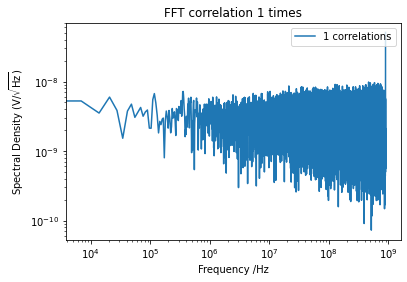

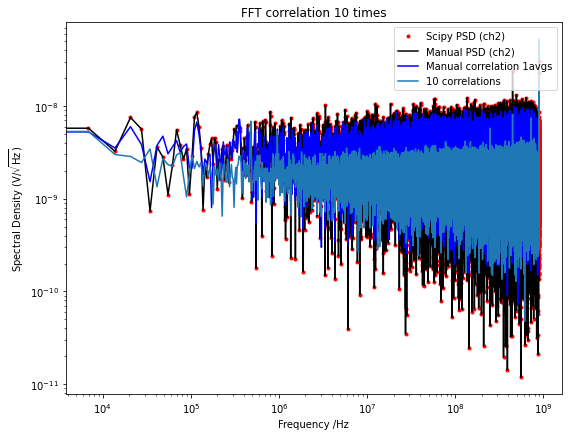

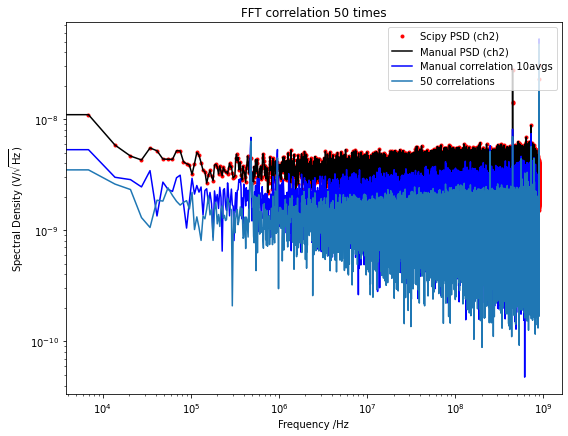

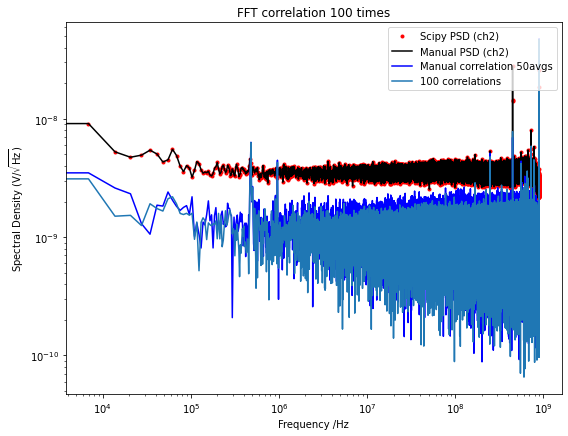

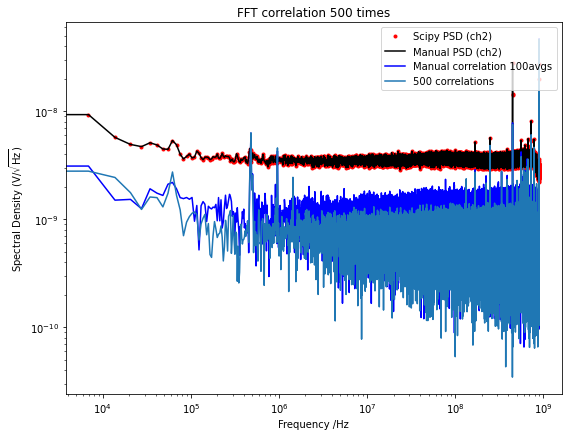

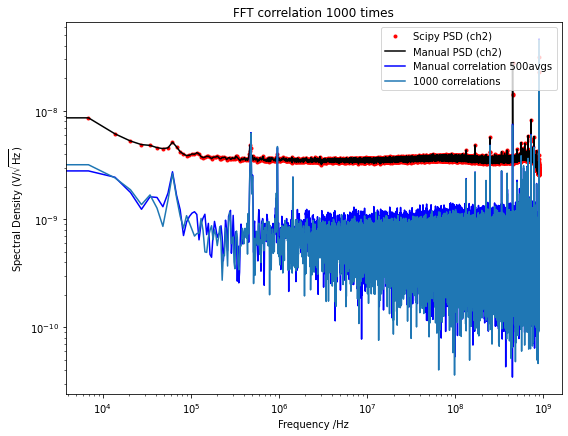

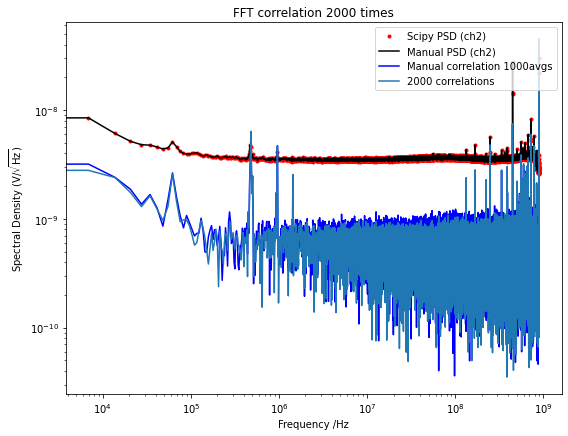

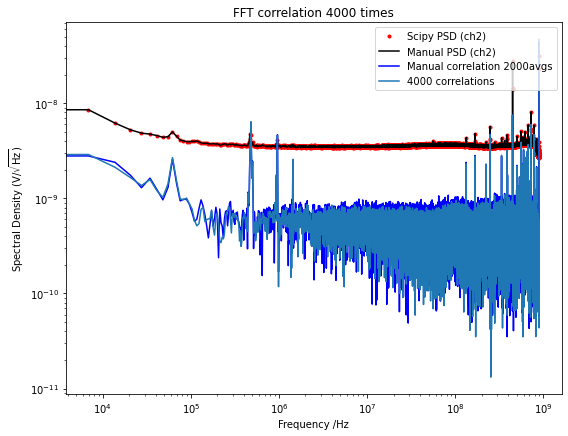

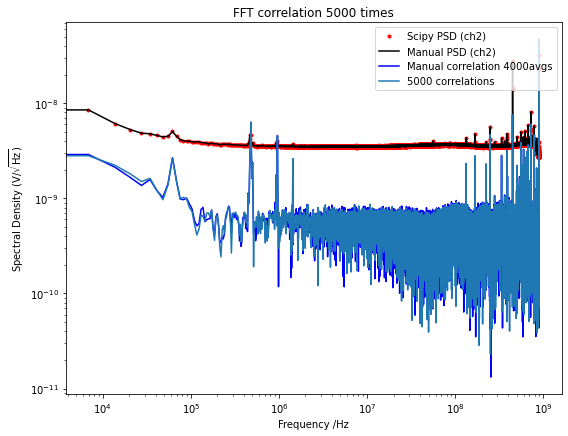

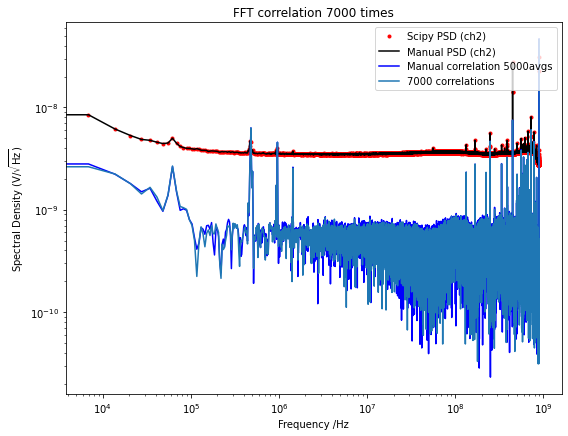

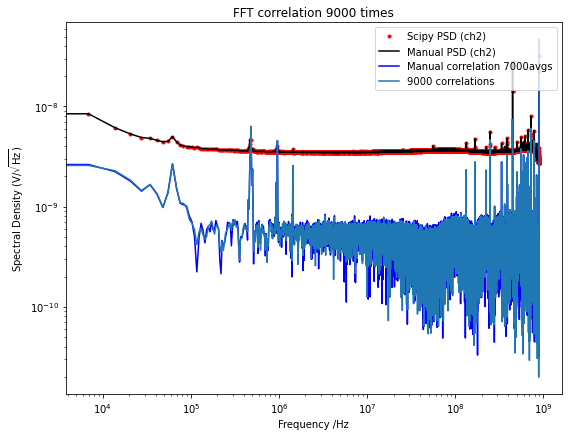

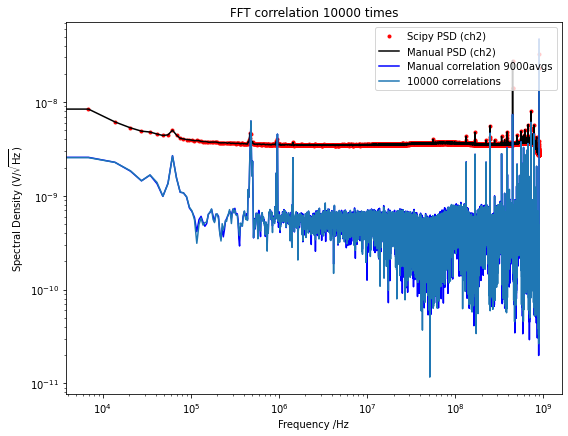

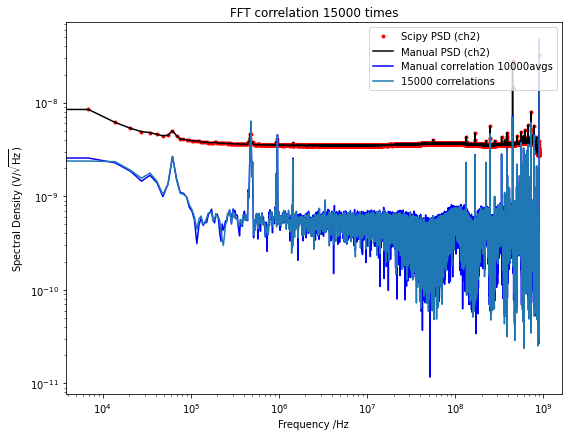

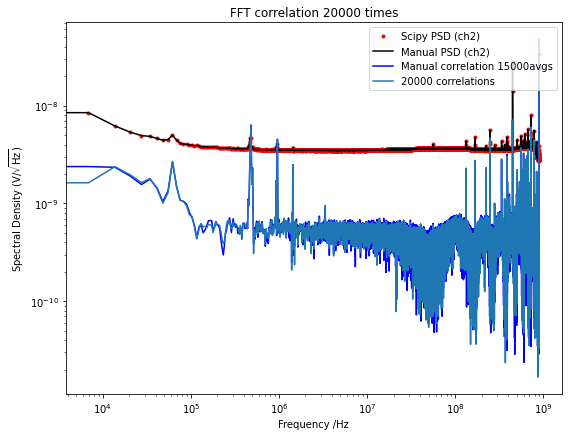

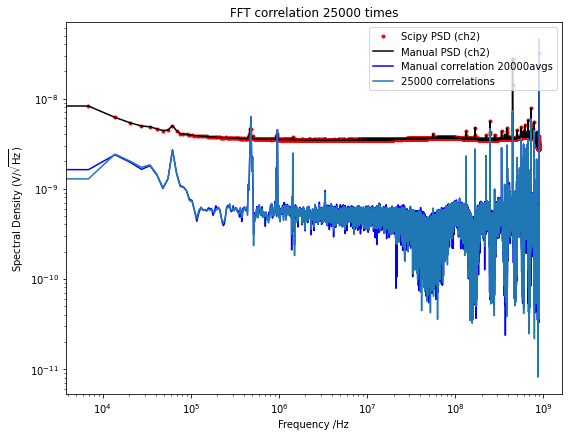

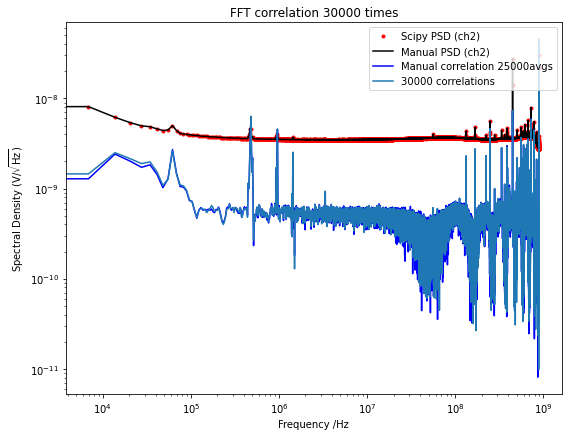

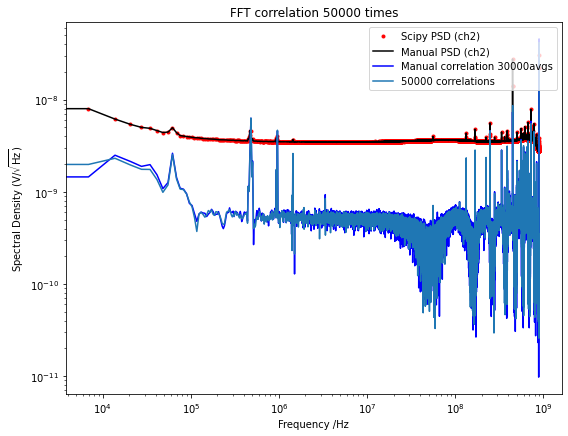

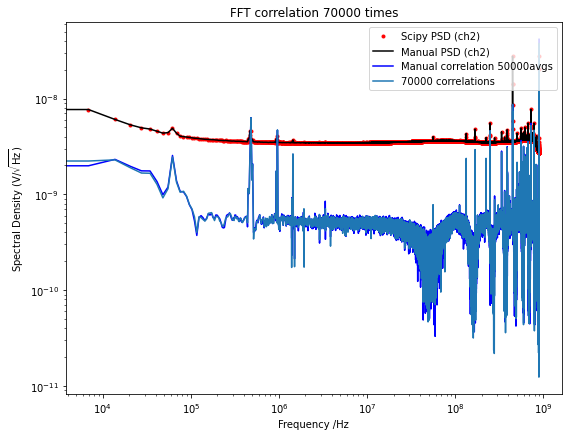

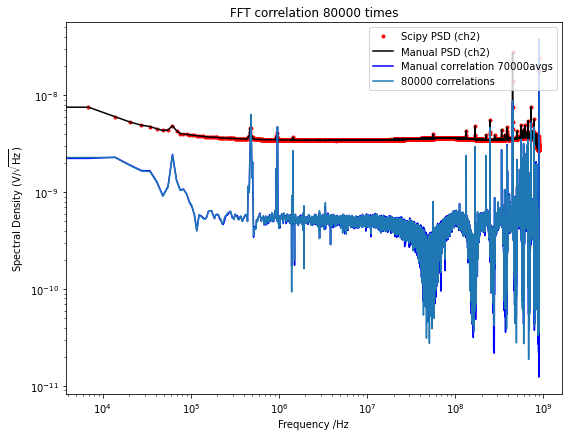

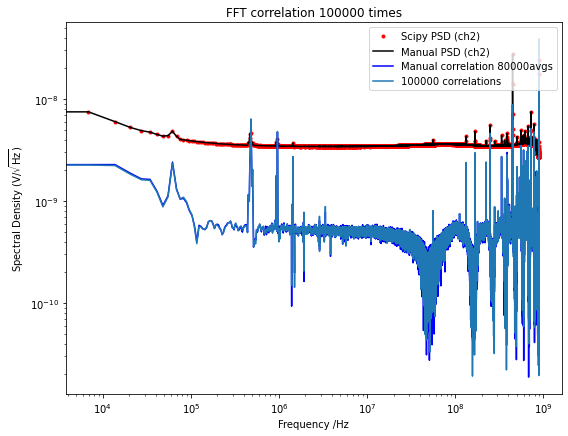

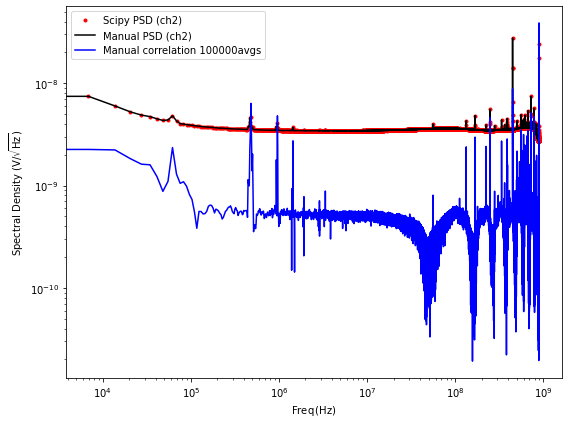

In [9]:
num_records = 1
tic = time.perf_counter()

timeout = 30  # [s]
records = 0
progress = 0

for n in range (1, repeats+1):
    """
    Obtain scope records from the device using an instance of the Scope Module.
    """
    # Tell the module to be ready to acquire data; reset the module's progress to 0.0.
    scopeModule.execute()
    
    print(f'Correlation number : {n}')
    
    # Enable the scope: Now the scope is ready to record data upon receiving triggers.
    daq.setInt('/%s/scopes/0/enable' % device, 1)
    daq.sync()
    
    start = time.time()

    # Wait until the Scope Module has received and processed the desired number of records.

    while (records < num_records) or (progress < 1.0):

        records = scopeModule.getInt("records")
        progress = scopeModule.progress()[0]

        if (time.time() - start) > timeout:
            # Break out of the loop if for some reason we're no longer receiving scope data from the device.
            print("\nScope Module did not return {} records after {} s - forcing stop.".format(num_records, timeout))
            break

    # Read data
    scopeData = scopeModule.read(True)

    # Channel 1 time series
    wave1 = scopeData[wave_nodepath][0][0]['wave'][0]

    # Channel 2 time series
    wave2 = scopeData[wave_nodepath][0][0]['wave'][1]
    
    data = [wave1, wave2]
    
    # Normalize data?
    data[0] = data[0]-np.mean(data[0])
    data[1] = data[1]-np.mean(data[1])
    
    # Calculate PSD
    fft_np_0 = signal.welch(data[0], fs=1.8e9/2**sample_rate, nperseg=scope_length, scaling = "density")
    fft_np_1 = signal.welch(data[1], fs=1.8e9/2**sample_rate, nperseg=scope_length, scaling = "density")
    
    # Calculate FFT
    data_fft_0 = 2*np.fft.fft(signal.windows.hann(len(data[0]))*(data[0]), norm=None)/ len(data[0]) #fft of channel 1
    data_fft_1 = 2*np.fft.fft(signal.windows.hann(len(data[1]))*(data[1]), norm=None)/ len(data[1])  #fft of channel 1
    
    if n == 1: 
        # Store first PSD signals
        fft_np_0_sum = fft_np_0[1]
        fft_np_1_sum = fft_np_1[1]
        
        # Store first FFT signals
        data_fft_0_sum = data_fft_0 
        data_fft_1_sum = data_fft_1 
        
        # Store correlated FFT signal
        corr_fft = np.multiply(data_fft_0, np.conj(data_fft_1))
        
        # Compare data_psd_0 and fft_np_0_sum to check if PSDs are equal?
        data_psd_0 = 2*np.multiply(data_fft_0, np.conj(data_fft_0))[:int(len(data_fft_0)/2)] / step # calculate PSD for chan 1
        data_psd_1 = 2*np.multiply(data_fft_1, np.conj(data_fft_1))[:int(len(data_fft_1)/2)] / step # calculate PSD for chan 2
        
    else: 
        fft_np_0_sum = fft_np_0_sum + fft_np_0[1]
        fft_np_1_sum = fft_np_1_sum + fft_np_1[1]

        data_fft_0_sum = data_fft_0_sum + data_fft_0 # sum ffts
        data_fft_1_sum = data_fft_1_sum + data_fft_1 # sum ffts
        
        corr_fft = corr_fft + np.multiply(data_fft_0, np.conj(data_fft_1)) # sum correlated fft with newly calculated correlated fft
        
        data_psd_0 = data_psd_0 + 2*np.multiply(data_fft_0, np.conj(data_fft_0))[:int(len(data_fft_0)/2)] / step 
        data_psd_1 = data_psd_1 + 2*np.multiply(data_fft_1, np.conj(data_fft_1))[:int(len(data_fft_1)/2)] / step
    
    
    if n in counter:
        manual_corr = np.sqrt(2*np.sqrt(np.multiply(corr_fft/float(n), 
                                        np.conj(corr_fft/float(n)))[:int(len(corr_fft)/2)+1])/ step / hann_scaling)

        plt.loglog(np.arange(0,stop+step,step), manual_corr.real, label=f'{n} correlations')
        plt.title('FFT correlation %d times' % n)
        plt.xlabel(r'Frequency /Hz')
        plt.ylabel(r'Spectral Density $\mathrm{(V/\sqrt{Hz})}$')
        plt.legend(loc='upper right', frameon=True)
        # Save it
        # Find the number of runs existing in the save folder
        #today = datetime.now().strftime('%Y-%m-%d')
        #dirName = r'C:\Users\jitheshs\Data\Cross correlation\%s' % today
        dirName = r'%s\%s' % (saveDir, today)
        idx = len(os.listdir(dirName))
        debug = r'%s\Run %d\%d correlation plot.png'
        print(r'saving in: %d , %s' % (n , debug))
        plt.savefig(r'%s\Run %d\%d correlation plot.png' % (dirName,idx, n))
        #plt.clf()
        
        data_path = r'%s\Run %d' % (dirName,idx)
        
        np.savetxt(data_path + '\data_fft_np_0_' + str(n) + '.dat', np.vstack((fft_np_0[0], np.sqrt(fft_np_0_sum/float(n)))).T, delimiter = ',')
        np.savetxt(data_path + '\data_fft_np_1_' + str(n) + '.dat', np.vstack((fft_np_1[0], np.sqrt(fft_np_1_sum/float(n)))).T, delimiter = ',')
        
        np.savetxt(data_path + '\data_corr_fft_' + str(n) + '.dat', np.vstack((np.arange(0,stop+step,step),manual_corr.real)).T, delimiter = ',')
        
        np.savetxt(data_path + '\data_PSDM0_' + str(n) + '.dat', np.vstack((np.arange(0,stop,step),np.sqrt((data_psd_0.real)/float(n)/hann_scaling))).T, delimiter = ',')
        np.savetxt(data_path + '\data_PSDM1_' + str(n) + '.dat', np.vstack((np.arange(0,stop,step),np.sqrt((data_psd_1.real)/float(n)/hann_scaling))).T, delimiter = ',')
        
        ## ------------------------ Plot and save figure
        
        mpl.rcParams['text.usetex']=False
        mpl.rcParams['text.latex.unicode']=False
        
        fig, ax = plt.subplots(figsize=(8,6))
        
        

        ax.loglog(fft_np_1[0], np.sqrt(fft_np_1_sum/float(n)), 'r.', label = 'Scipy PSD (ch2)') #scipy fft chan 1
        ax.loglog(np.arange(0,stop,step), np.sqrt((data_psd_1)/float(n)/hann_scaling), 'k', label = 'Manual PSD (ch2)')
        ax.loglog(np.arange(0,stop+step,step), manual_corr.real, 'b', label = 'Manual correlation ' + str(n) + 'avgs')
        #ax.axis((1, 40000, 2e-10, 2e-6))
        ax.set_xlabel(r'$\mathrm{Freq}\,\mathrm{(Hz)}$')
        ax.set_ylabel(r'Spectral Density $\mathrm{(V/\sqrt{Hz})}$')
        ax.legend()
        plt.tight_layout()
        plt.savefig(data_path + "\\" + str(n) + '.png')
        #plt.show()
        
    
toc = time.perf_counter()

print('Time taken in seconds outer loop: ', toc-tic)

daq.setInt('/%s/scopes/0/enable' % device, 0)

# Stop the module; to use it again we need to call execute().
scopeModule.finish()